# Setup

## Importing Packages

In [2]:
import pandas as pd 
import numpy as np
import json
import os
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


## Loading Data

In [9]:
# Define base paths
PROCESSED_PATH = os.path.join('..', '..', 'data', 'processed')
TRIPS_PATH = os.path.join(PROCESSED_PATH, 'trips_data2.csv')
WEATHER_PATH = os.path.join(PROCESSED_PATH, 'processed_weather_features.csv')

# Read data directly
trip_df = pd.read_csv(TRIPS_PATH)
weather_df = pd.read_csv(WEATHER_PATH)

In [5]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

In [6]:
dataframe_info(weather_df)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_37912\3841810920.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report = pd.concat([report, pd.DataFrame({'Column': [column],


Column Data Type Unique Count  \
0                 date    object          243   
1                 time    object            8   
2          temperature     int64           18   
3           feels_like     int64           18   
4            precip_mm   float64           48   
5             humidity     int64           67   
6           visibility     int64            8   
7             pressure     int64           11   
8          cloud_cover     int64          101   
9           wind_speed     int64           11   
10               month    object            8   
11            datetime    object         1943   
12                hour     int64            8   
13                 day     int64           31   
14           month_num     int64            8   
15            hour_sin   float64            7   
16            hour_cos   float64            8   
17       month_num_sin   float64            8   
18       month_num_cos   float64            8   
19   temp_rolling_mean   float64          205   
20    temp_rolling_std   float64         1344   
21         temp_lag_24   float64          150   
22     humidity_lag_24   float64           76   
23  visibility_cleaned     int64            6   
24    humidity_cleaned     int64           67   
25  wind_speed_cleaned     int64            7   
26          temp_range     int64           12   
27           dew_point   float64          422   
28          heat_index   float64          204   
29         temp_change   float64           20   
30     pressure_change   float64            8   
31    humidity_comfort    object            3   
32         heat_stress    object            3   

                                        Unique Sample Missing Values  \
0   [2024-02-01, 2024-02-02, 2024-02-03, 2024-02-0...              0   
1                 [00:00, 03:00, 06:00, 09:00, 12:00]              0   
2                                [18, 27, 28, 26, 24]              0   
3                                [18, 29, 32, 26, 19]              0   
4                           [0.2, 0.0, 1.0, 0.9, 3.9]              0   
5                                [92, 90, 71, 75, 88]              0   
6                                    [9, 10, 7, 2, 5]              0   
7                      [1014, 1013, 1012, 1011, 1015]              0   
8                                [76, 27, 40, 74, 59]              0   
9                                     [4, 5, 3, 2, 0]              0   
10                [february, march, april, may, june]              0   
11  [2024-02-01 00:00:00, 2024-02-01 03:00:00, 202...              0   
12                                   [0, 3, 6, 9, 12]              0   
13                                    [1, 2, 3, 4, 5]              0   
14                                    [2, 3, 4, 5, 6]              0   
15  [0.0, 0.7071067811865476, 1.0, 1.2246467991473...              0   
16  [1.0, 0.7071067811865476, 6.123233995736766e-1...              0   
17  [0.8660254037844386, 1.0, 0.8660254037844387, ...              0   
18  [0.5000000000000001, 6.123233995736766e-17, -0...              0   
19      [18.0, 20.25, 21.8, 22.5, 22.714285714285715]              0   
20  [nan, 0.0, 4.5, 5.215361924162119, 4.969909455...              8   
21      [18.0, 20.25, 21.8, 22.5, 22.714285714285715]              0   
22        [87.36637931034483, 92.0, 90.0, 71.0, 75.0]              0   
23                                   [9, 10, 7, 5, 8]              0   
24                               [92, 90, 71, 75, 88]              0   
25                                    [4, 5, 3, 2, 1]              0   
26                                   [10, 8, 7, 9, 6]              0   
27  [16.678824728856874, 16.332841228150222, 21.28...              0   
28  [18.0, 28.939056981777718, 31.35576789511109, ...              0   
29                         [nan, 0.0, 9.0, 1.0, -2.0]            243   
30                        [nan, -1.0, 1.0, 0.0, -2.0]            243   
31                   [Very Humid, Humid, Comf

## Feature Extraction 

In [10]:
def calculate_operation_minutes(start_time):
    morning_start = pd.Timestamp(start_time.date()).replace(hour=6, minute=30)
    afternoon_start = pd.Timestamp(start_time.date()).replace(hour=15, minute=0)
    
    if start_time < afternoon_start:  # Morning session
        return max(0, (start_time - morning_start).total_seconds() // 60 + 1)
    else:  # Afternoon session
        return (start_time - afternoon_start).total_seconds() // 60 + 181
    
def preprocess_weather_data(df):
    # Convert date and time columns to datetime
    df['datetime'] = pd.to_datetime(df['date'])
    
    # Drop unnecessary columns
    columns_to_drop = ['date', 'time', 'month']
    df = df.drop(columns=columns_to_drop)
    
    return df

# Convert start_time and end_time to datetime
trip_df['start_time'] = pd.to_datetime(trip_df['start_time'])
trip_df['end_time'] = pd.to_datetime(trip_df['end_time'])

# Extract day of week and month
trip_df['day_of_week'] = trip_df['start_time'].dt.dayofweek
trip_df['month'] = trip_df['start_time'].dt.month
    
# Remove rows with zero distance or duration
trip_df = trip_df[(trip_df['distance'] > 0) & (trip_df['duration'] > 0)]
    
# Cyclic encoding for day of week
trip_df['day_of_week_sin'] = np.sin(trip_df['day_of_week'] * (2 * np.pi / 7))
trip_df['day_of_week_cos'] = np.cos(trip_df['day_of_week'] * (2 * np.pi / 7))

# Calculate minutes of operation
trip_df['minutes_of_operation'] = trip_df['start_time'].apply(calculate_operation_minutes)
    
# Cyclic encoding for minutes of operation
trip_df['minutes_sin'] = np.sin(2 * np.pi * trip_df['minutes_of_operation'] / 360)
trip_df['minutes_cos'] = np.cos(2 * np.pi * trip_df['minutes_of_operation'] / 360)

weather_df = preprocess_weather_data(weather_df)

# Merge GPS and weather data
merged_df = pd.merge_asof(trip_df.sort_values('start_time'), 
                          weather_df.sort_values('datetime'), 
                          left_on='start_time', 
                          right_on='datetime', 
                          direction='nearest').drop('datetime', axis=1)

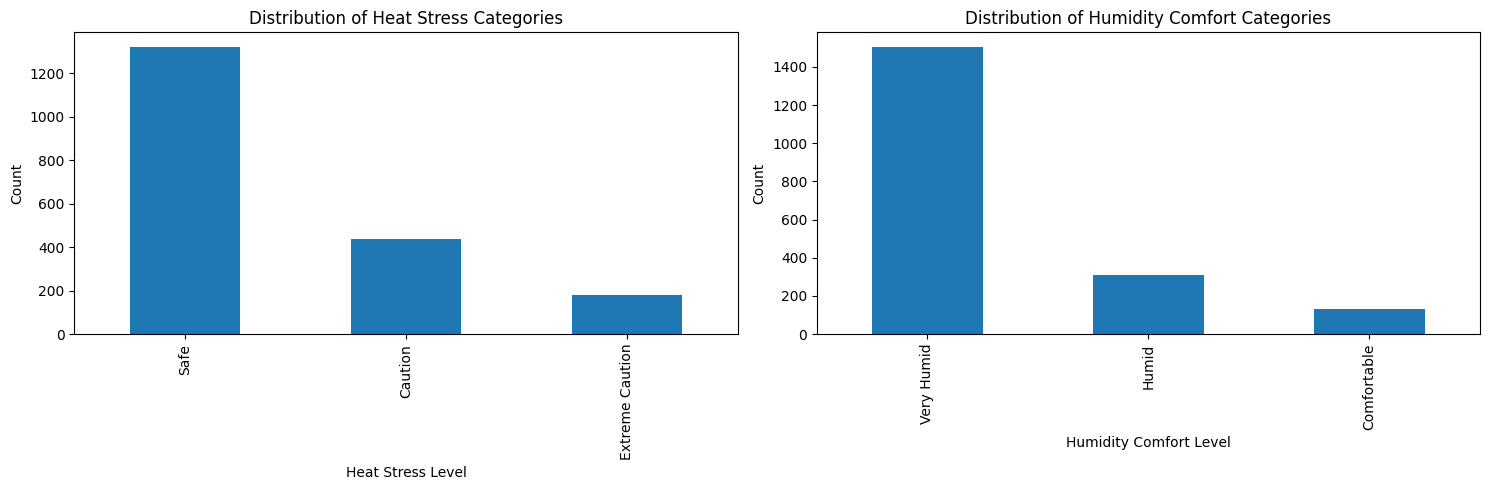

In [5]:
# Visualize distribution of heat_stress and humidity_comfort
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot heat_stress distribution
weather_df['heat_stress'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Heat Stress Categories')
ax1.set_xlabel('Heat Stress Level')
ax1.set_ylabel('Count')

# Plot humidity_comfort distribution  
weather_df['humidity_comfort'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Distribution of Humidity Comfort Categories')
ax2.set_xlabel('Humidity Comfort Level') 
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()


## Dropping Features with Missing Values

In [11]:
# Drop columns with missing values
missing_cols = merged_df.columns[merged_df.isnull().any()].tolist()
print("Dropping columns with missing values:", missing_cols)
merged_df = merged_df.drop(columns=missing_cols)

# Drop visibility_cleaned, humidity_cleaned, and wind_speed_cleaned
merged_df = merged_df.drop(columns=['visibility_cleaned', 'humidity_cleaned', 'wind_speed_cleaned', 'duration_minutes'])

Dropping columns with missing values: ['temp_rolling_std', 'temp_change', 'pressure_change']


# Correlation Analysis

In [12]:
plt.style.use('bmh')

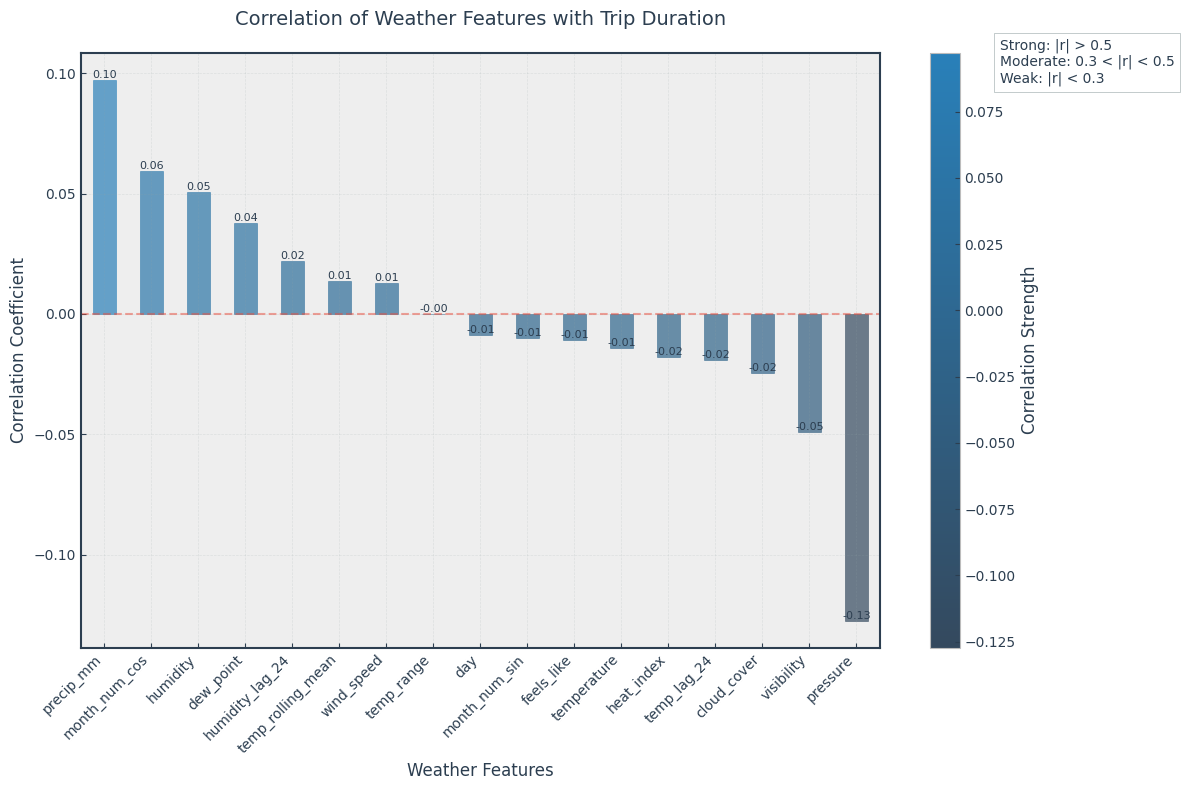

In [22]:
# Get weather features and correlations (existing code remains the same)
weather_features = [col for col in weather_df.columns.tolist() 
                   if col not in ['datetime', 'time', 'hour', 'hour_sin', 'hour_cos', 
                                'month_num', 'month_sin', 'month_cos', 'month', 
                                'humidity_comfort', 'heat_stress', 
                                'temp_rolling_std', 'temp_change', 'pressure_change',
                                'visibility_cleaned', 'humidity_cleaned', 'wind_speed_cleaned']]

weather_correlations = merged_df[weather_features + ['duration']].corr()['duration']
weather_correlations = weather_correlations[weather_correlations.index != 'duration'].sort_values(ascending=False)

# Create custom colormap using LinearSegmentedColormap instead of add_cmap
from matplotlib.colors import LinearSegmentedColormap
colors = ["#34495E", "#2980B9"]  # Dark blue-gray to medium blue
n_bins = 256  # Number of color gradients
correlation_cmap = LinearSegmentedColormap.from_list("correlation_cmap", colors, N=n_bins)

# Set style and create figure
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars with enhanced styling
bars = weather_correlations.plot(kind='bar', ax=ax, color='gray', alpha=0.7)

# Color bars by correlation strength
norm = plt.Normalize(vmin=weather_correlations.min(), vmax=weather_correlations.max())
for bar, value in zip(bars.patches, weather_correlations.values):
    bar.set_color(correlation_cmap(norm(value)))
    # Add value labels on top of bars
    ax.text(bar.get_x() + bar.get_width()/2, 
            bar.get_height(),
            f'{value:.2f}',
            ha='center', va='bottom',
            color='#2C3E50',
            fontsize=8)

# Enhanced styling
ax.set_title('Correlation of Weather Features with Trip Duration', 
             fontsize=14, pad=20, color='#2C3E50')
ax.set_xlabel('Weather Features', fontsize=12, color='#2C3E50')
ax.set_ylabel('Correlation Coefficient', fontsize=12, color='#2C3E50')

# Improved tick styling
ax.tick_params(axis='both', colors='#2C3E50', labelsize=10)
plt.xticks(rotation=45, ha='right')

# Enhanced grid
ax.grid(True, alpha=0.2, color='#95A5A6', linestyle='--')
ax.axhline(y=0, color='#E74C3C', linestyle='--', alpha=0.5, linewidth=1.5)

# Style spines
for spine in ax.spines.values():
    spine.set_color('#2C3E50')
    spine.set_linewidth(1.5)

# Add colorbar with enhanced styling
sm = plt.cm.ScalarMappable(cmap=correlation_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Correlation Strength', fontsize=12, color='#2C3E50')
cbar.ax.yaxis.set_tick_params(color='#2C3E50')
cbar.ax.yaxis.label.set_color('#2C3E50')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#2C3E50')

# Add correlation strength interpretation
ax.text(1.15, 0.95, 'Strong: |r| > 0.5\nModerate: 0.3 < |r| < 0.5\nWeak: |r| < 0.3', 
        transform=ax.transAxes, 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='#95A5A6'),
        fontsize=10, color='#2C3E50')

plt.tight_layout()
plt.show()

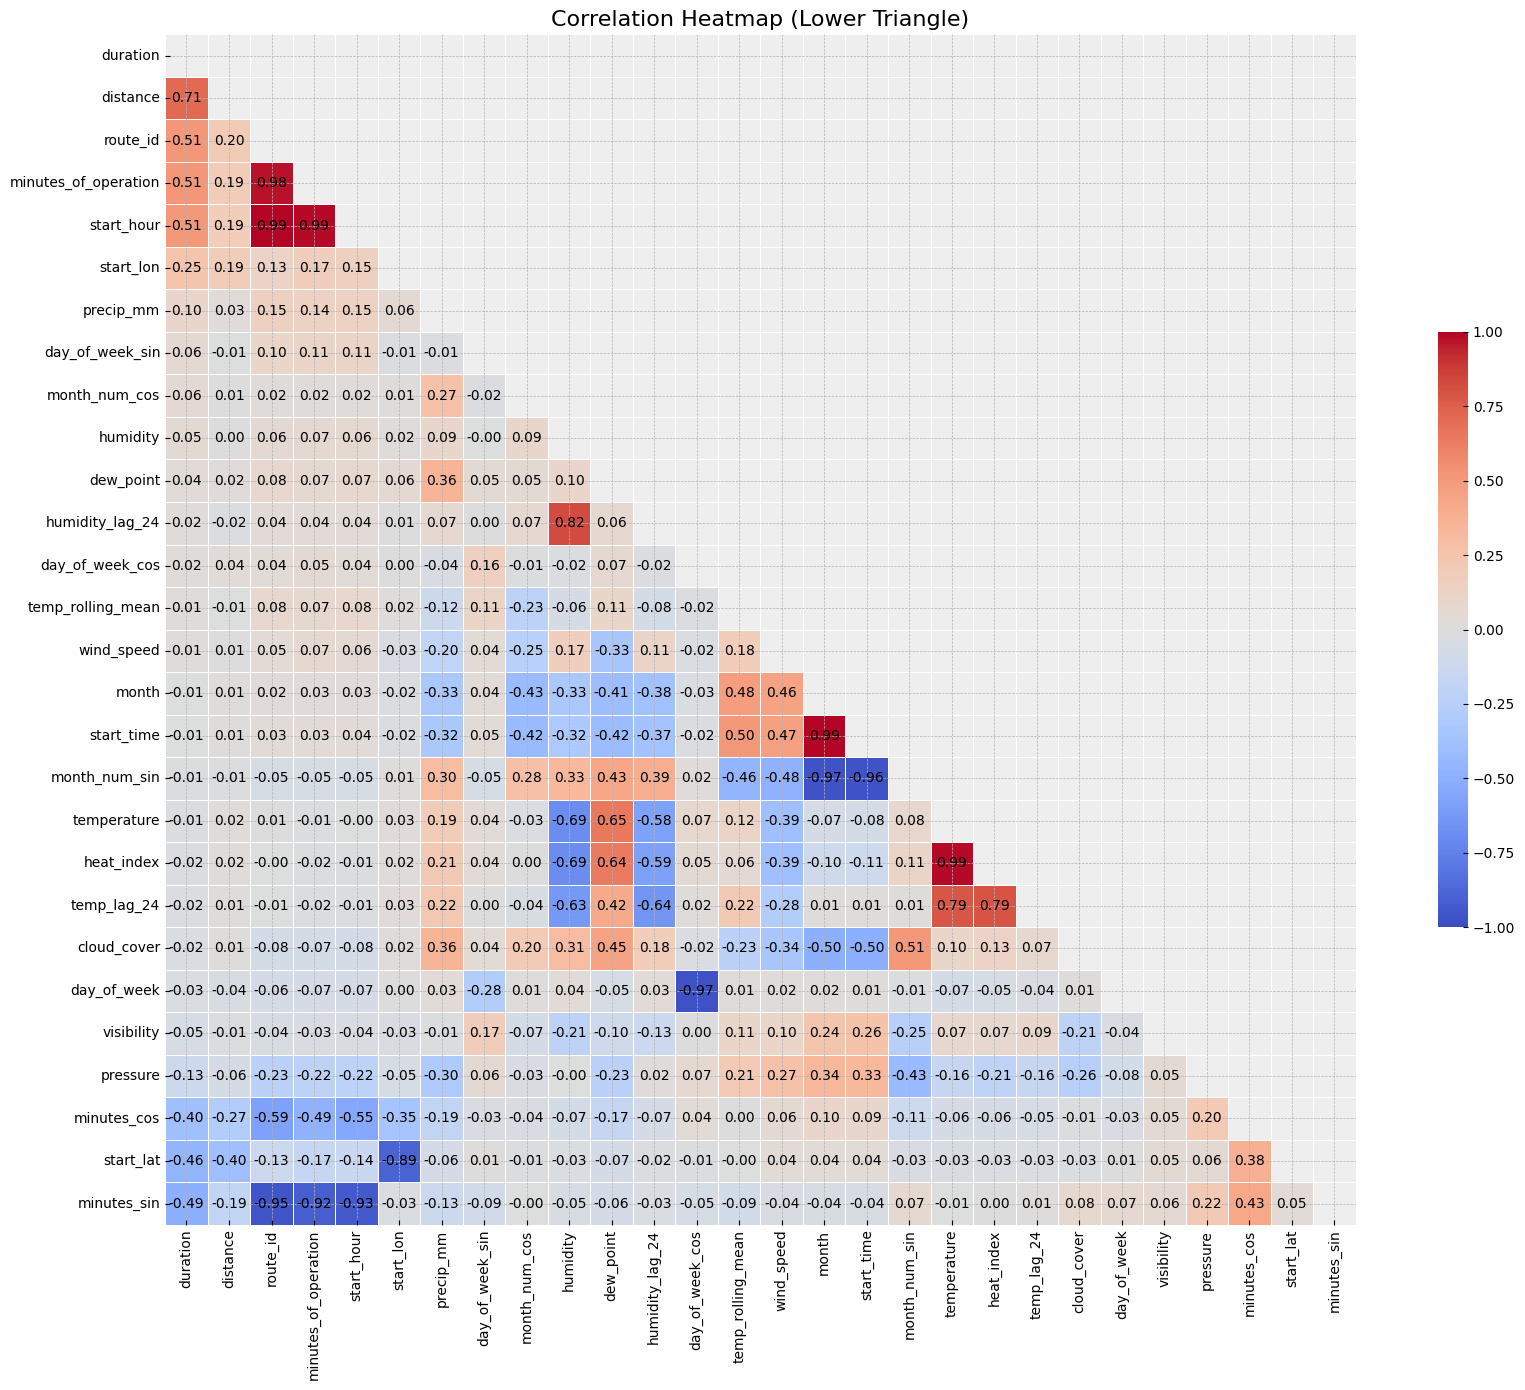


Correlations with duration
duration                1.000000
distance                0.714408
route_id                0.511439
minutes_of_operation    0.509480
start_hour              0.507296
start_lon               0.252979
precip_mm               0.097204
day_of_week_sin         0.059800
month_num_cos           0.059494
humidity                0.050790
dew_point               0.037856
humidity_lag_24         0.021866
day_of_week_cos         0.016366
temp_rolling_mean       0.013744
wind_speed              0.012790
month                  -0.005749
start_time             -0.006577
month_num_sin          -0.009996
temperature            -0.014215
heat_index             -0.017787
temp_lag_24            -0.019074
cloud_cover            -0.024367
day_of_week            -0.026386
visibility             -0.048911
pressure               -0.127261
minutes_cos            -0.398278
start_lat              -0.463211
minutes_sin            -0.492244
Name: duration, dtype: float64


route_id  start_time  start_hour  start_lat  start_lon  \
route_id              1.000000    0.031620    0.992510  -0.131952   0.127580   
start_time            0.031620    1.000000    0.036810   0.039817  -0.019946   
start_hour            0.992510    0.036810    1.000000  -0.144790   0.148868   
start_lat            -0.131952    0.039817   -0.144790   1.000000  -0.891164   
start_lon             0.127580   -0.019946    0.148868  -0.891164   1.000000   
distance              0.196818    0.011279    0.186150  -0.396435   0.191862   
day_of_week          -0.063829    0.014405   -0.066762   0.005984   0.002202   
month                 0.024438    0.992939    0.029534   0.037239  -0.016582   
pressure             -0.228070    0.333985   -0.220160   0.056284  -0.050681   
temp_lag_24          -0.006269    0.009831   -0.010657  -0.030419   0.030509   
cloud_cover          -0.077168   -0.501918   -0.077827  -0.026457   0.019751   
visibility           -0.043364    0.262322   -0.035937   0.048531  -0.033946   
month_num_sin        -0.047022   -0.962652   -0.052933  -0.032800   0.013453   
heat_index           -0.002503   -0.114373   -0.009213  -0.027974   0.022569   
temperature           0.005068   -0.076794   -0.001607  -0.031869   0.027749   
precip_mm             0.154848   -0.321606    0.147437  -0.064204   0.060328   
humidity              0.061684   -0.315917    0.064669  -0.025383   0.021785   
month_num_cos         0.016949   -0.423269    0.016544  -0.008074   0.012480   
humidity_lag_24       0.038926   -0.369208    0.038423  -0.016524   0.006119   
dew_point             0.080704   -0.417313    0.074750  -0.067484   0.058140   
temp_rolling_mean     0.081523    0.503875    0.083391  -0.003321   0.018600   
wind_speed            0.046617    0.465225    0.058119   0.039342  -0.033673   
day_of_week_sin       0.103244    0.045123    0.109719   0.011953  -0.008491   
day_of_week_cos       0.041913   -0.022970    0.044046  -0.012023   0.003567   
minutes_of_operation  0.975794    0.034280    0.989980  -0.165266   0.170762   
minutes_sin          -0.953631   -0.044649   -0.933703   0.045899  -0.027565   
minutes_cos          -0.585795    0.092865   -0.546539   0.378592  -0.353061   
duration              0.511439   -0.006577    0.507296  -0.463211   0.252979   

                      distance  day_of_week     month  pressure  temp_lag_24  \
route_id              0.196818    -0.063829  0.024438 -0.228070    -0.006269   
start_time            0.011279     0.014405  0.992939  0.333985     0.009831   
start_hour            0.186150    -0.066762  0.029534 -0.220160    -0.010657   
start_lat            -0.396435     0.005984  0.037239  0.056284    -0.030419   
start_lon             0.191862     0.002202 -0.016582 -0.050681     0.030509   
distance              1.000000    -0.041306  0.010045 -0.055697     0.008597   
day_of_week          -0.041306     1.000000  0.021230 -0.084579    -0.036157   
month                 0.010045     0.021230  1.000000  0.342068     0.007976   
pressure             -0.055697    -0.084579  0.342068  1.000000    -0.157248   
temp_lag_24           0.008597    -0.036157  0.007976 -0.157248     1.000000   
cloud_cover           0.013928     0.013387 -0.497722 -0.255947     0.070343   
visibility           -0.014858    -0.036893  0.242771  0.048026     0.089659   
month_num_sin        -0.009988    -0.011851 -0.965771 -0.428292     0.008584   
heat_index            0.016751    -0.049881 -0.101648 -0.206643     0.790208   
temperature           0.016580    -0.073917 -0.065660 -0.162030     0.786868   
precip_mm             0.029798     0.031316 -0.327480 -0.300032     0.221080   
humidity              0.000231     0.036944 -0.325905 -0.004184    -0.632531   
month_num_cos         0.006720     0.012914 -0.428698 -0.033612    -0.041848   
humidity_lag_24      -0.019058     0.031525 -0.375475  0.015855    -0.642885   
dew_point             0.024856    -0.053277 -0.413295 -0.232209     0.421790   
temp_rolling_mean    

In [25]:
def correlation_heatmap(data, target_column='duration', figsize=(18, 14)):
    # Select relevant features
    features_to_keep = ['route_id', 'start_time', 'start_hour', 'start_lat', 'start_lon', 
                        'distance', 'day_of_week', 'month', 'avg_speed',
                        'pressure', 'temp_change', 'temp_lag_24', 'cloud_cover', 'visibility',
                        'month_num_sin', 'heat_index', 'temperature', 'precip_mm', 'humidity',
                        'month_num_cos', 'humidity_lag_24', 'dew_point', 'temp_rolling_mean',
                        'wind_speed', 'day_of_week_sin', 'day_of_week_cos', 
                        'minutes_of_operation', 'minutes_sin', 'minutes_cos', target_column]
    
    # Check which features are actually in the dataframe
    available_features = [f for f in features_to_keep if f in data.columns]
    missing_features = [f for f in features_to_keep if f not in data.columns]
    
    if missing_features:
        print(f"Warning: The following features are not in the dataframe: {missing_features}")
    
    df = data[available_features].copy()
    
    # Identify numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns
    
    # Normalize numerical features
    for feature in numerical_features:
        if df[feature].std() != 0:
            df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
        else:
            print(f"Warning: Feature '{feature}' has zero standard deviation and cannot be normalized.")
    
    # Calculate correlations
    corr_matrix = df.corr()
    
    # Sort features by correlation with target
    corr_with_target = corr_matrix[target_column].sort_values(ascending=False)
    sorted_features = corr_with_target.index
    
    # Create a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(corr_matrix.loc[sorted_features, sorted_features], 
                          mask=mask,
                          cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Manually add annotations to avoid the warning
    for i in range(len(sorted_features)):
        for j in range(i):
            plt.text(j + 0.5, i + 0.5, f"{corr_matrix.loc[sorted_features[i], sorted_features[j]]:.2f}",
                     ha='center', va='center', color='black')
    
    plt.title("Correlation Heatmap (Lower Triangle)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelations with", target_column)
    print(corr_with_target)
    
    return corr_matrix


correlation_heatmap(merged_df)

## Dropping Some Features 

In [26]:
# Define columns to drop 
columns_to_drop = [
    # Location and stop information
    'start_stop_id', 'end_stop_id', 'end_stop',
    'start_lon', 'start_lat', 'end_lat', 'end_lon',
    
    # Time-related columns
    'end_time', 'start_time', 'start_hour', 'end_hour',
    'minutes_of_operation','month', 'day',
    
    # Low correlation features
    'day_of_week','feels_like'
]

# Filter and sort in one operation
filtered_df = (merged_df
              .sort_values('start_time') 
              .drop(columns=columns_to_drop)
              .copy())

# Variance Inflation Factor Analysis

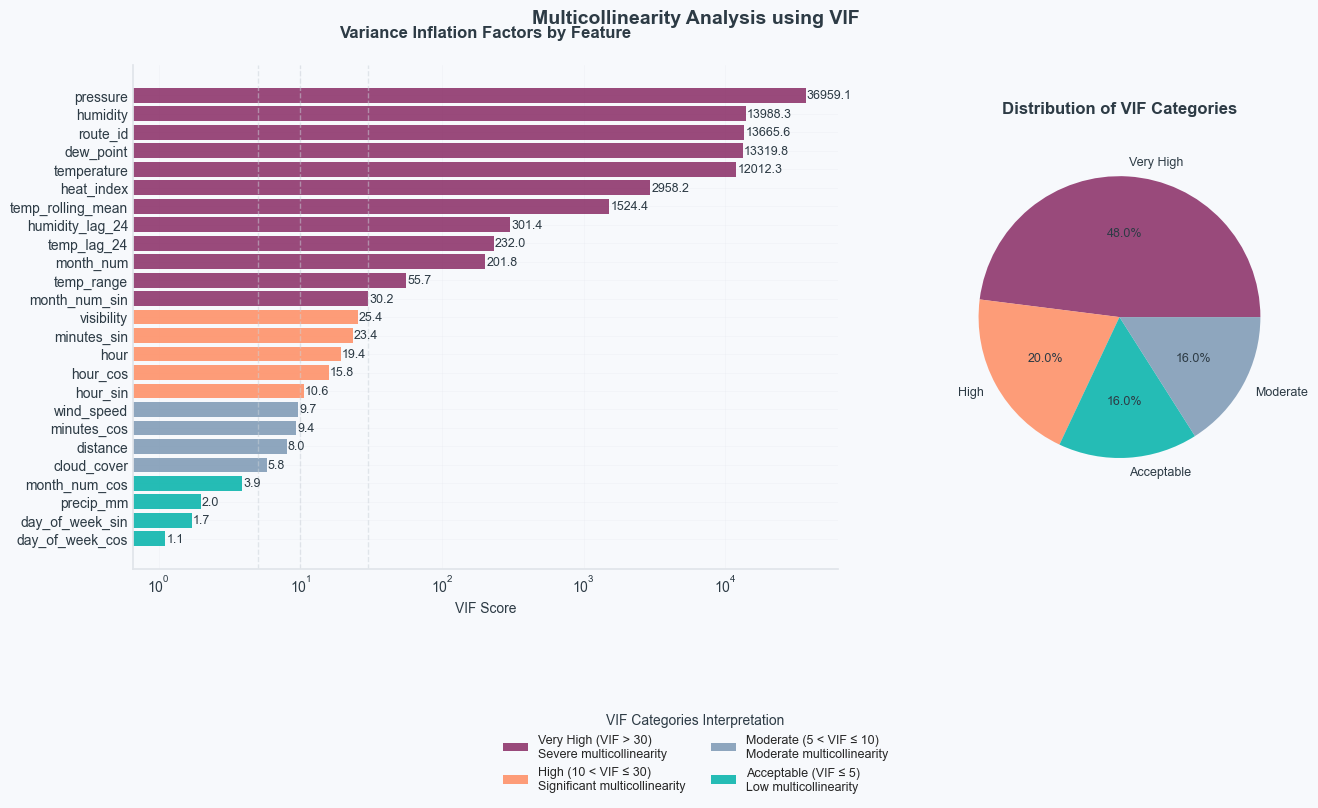


📊 VIF Analysis Summary:

#892B64 Very High Multicollinearity:
  • month_num_sin: 30.15
  • temp_range: 55.72
  • month_num: 201.77
  • temp_lag_24: 231.98
  • humidity_lag_24: 301.43
  • temp_rolling_mean: 1524.41
  • heat_index: 2958.24
  • temperature: 12012.34
  • dew_point: 13319.77
  • route_id: 13665.57
  • humidity: 13988.28
  • pressure: 36959.12

#FF8C61 High Multicollinearity:
  • hour_sin: 10.55
  • hour_cos: 15.85
  • hour: 19.38
  • minutes_sin: 23.42
  • visibility: 25.41

#7C98B3 Moderate Multicollinearity:
  • cloud_cover: 5.80
  • distance: 8.01
  • minutes_cos: 9.39
  • wind_speed: 9.67

#00B2A9 Acceptable Multicollinearity:
  • day_of_week_cos: 1.11
  • day_of_week_sin: 1.72
  • precip_mm: 1.99
  • month_num_cos: 3.88

🔍 Recommendations:

Consider removing or combining these high-VIF features:
  • hour_sin
  • hour_cos
  • hour
  • minutes_sin
  • visibility
  • month_num_sin
  • temp_range
  • month_num
  • temp_lag_24
  • humidity_lag_24
  • temp_rolling_mean
  • 

In [30]:
def calculate_vif(df, target_column, figsize=(15, 8)):
    """
    Calculate and visualize Variance Inflation Factors (VIF) for features.
    """
    # Create a dataframe with only numeric columns, excluding the target
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) 
                       for i in range(numeric_df.shape[1])]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values('VIF', ascending=True)
    
    # Create VIF categories for coloring
    def get_vif_category(vif):
        if vif < 5:
            return 'Acceptable'
        elif vif < 10:
            return 'Moderate'
        elif vif < 30:
            return 'High'
        else:
            return 'Very High'
    
    vif_data['Category'] = vif_data['VIF'].apply(get_vif_category)
    
    # Define a modern, sophisticated color scheme
    colors = {
        'Acceptable': '#00B2A9',    # Teal - calm, trustworthy
        'Moderate': '#7C98B3',      # Steel blue - neutral, professional
        'High': '#FF8C61',          # Coral - warning, attention
        'Very High': '#892B64'      # Burgundy - serious concern
    }
    
    # Define complementary colors for styling
    style_colors = {
        'background': '#F7F9FC',    # Light blue-grey background
        'text': '#2D3B45',          # Dark blue-grey text
        'grid': '#E1E5EA',          # Soft grey grid
        'reference': '#CBD2D9'      # Medium grey reference lines
    }
    
    # Set figure style
    plt.style.use('seaborn-v0_8-white')
    fig = plt.figure(figsize=figsize, facecolor=style_colors['background'])
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.2)
    
    # Bar plot with enhanced styling
    ax1 = fig.add_subplot(gs[0])
    ax1.set_facecolor(style_colors['background'])
    bars = ax1.barh(vif_data['Feature'], vif_data['VIF'], 
                    color=[colors[cat] for cat in vif_data['Category']],
                    alpha=0.85)
    
    # Add value labels with improved styling
    for bar in bars:
        width = bar.get_width()
        ax1.text(width * 1.02, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}', 
                ha='left', va='center',
                color=style_colors['text'],
                fontsize=9,
                fontweight='medium')
    
    # Customize bar plot
    ax1.set_title('Variance Inflation Factors by Feature', 
                  pad=20, fontsize=12, color=style_colors['text'],
                  fontweight='bold')
    ax1.set_xlabel('VIF Score', fontsize=10, color=style_colors['text'])
    ax1.grid(True, alpha=0.3, color=style_colors['grid'])
    ax1.set_xscale('log')
    
    # Style the axes
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_color(style_colors['grid'])
    ax1.spines['bottom'].set_color(style_colors['grid'])
    ax1.tick_params(colors=style_colors['text'])
    
    # Add reference lines with enhanced styling
    reference_lines = [5, 10, 30]
    for line in reference_lines:
        ax1.axvline(x=line, color=style_colors['reference'], 
                    linestyle='--', alpha=0.5, linewidth=1)
    
    # Pie chart with modern styling
    ax2 = fig.add_subplot(gs[1])
    ax2.set_facecolor(style_colors['background'])
    category_counts = vif_data['Category'].value_counts()
    wedges, texts, autotexts = ax2.pie(category_counts,
                                      labels=category_counts.index,
                                      colors=[colors[cat] for cat in category_counts.index],
                                      autopct='%1.1f%%',
                                      textprops={'fontsize': 9,
                                                'color': style_colors['text']},
                                      wedgeprops={'alpha': 0.85})
    
    # Customize pie chart
    ax2.set_title('Distribution of VIF Categories', 
                  pad=20, fontsize=12, color=style_colors['text'],
                  fontweight='bold')
    
    # Create custom legend with modern styling
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor=colors['Very High'], alpha=0.85,
                     label='Very High (VIF > 30)\nSevere multicollinearity'),
        plt.Rectangle((0,0),1,1, facecolor=colors['High'], alpha=0.85,
                     label='High (10 < VIF ≤ 30)\nSignificant multicollinearity'),
        plt.Rectangle((0,0),1,1, facecolor=colors['Moderate'], alpha=0.85,
                     label='Moderate (5 < VIF ≤ 10)\nModerate multicollinearity'),
        plt.Rectangle((0,0),1,1, facecolor=colors['Acceptable'], alpha=0.85,
                     label='Acceptable (VIF ≤ 5)\nLow multicollinearity')
    ]
    
    # Place legend with enhanced styling
    legend = fig.legend(handles=legend_elements, 
                       loc='center', 
                       bbox_to_anchor=(0.5, 0.02),
                       ncol=2,
                       title='VIF Categories Interpretation',
                       title_fontsize=10,
                       fontsize=9,
                       borderaxespad=0)
    
    # Style legend
    legend.get_frame().set_facecolor(style_colors['background'])
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_linewidth(0)
    plt.setp(legend.get_title(), color=style_colors['text'])
    
    # Add main title with modern styling
    plt.suptitle('Multicollinearity Analysis using VIF', 
                 fontsize=14, y=0.95, color=style_colors['text'],
                 fontweight='bold')
    
    # Adjust layout
    plt.subplots_adjust(bottom=0.25)
    
    # Set figure background
    fig.patch.set_facecolor(style_colors['background'])
    
    plt.show()
    
    # Print detailed analysis
    print("\n📊 VIF Analysis Summary:")
    print("=" * 50)
    
    # Group features by category
    for category in ['Very High', 'High', 'Moderate', 'Acceptable']:
        features = vif_data[vif_data['Category'] == category]
        if not features.empty:
            print(f"\n{colors[category]} {category} Multicollinearity:")
            for _, row in features.iterrows():
                print(f"  • {row['Feature']}: {row['VIF']:.2f}")
    
    # Recommendations
    print("\n🔍 Recommendations:")
    high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    if high_vif_features:
        print("\nConsider removing or combining these high-VIF features:")
        for feature in high_vif_features:
            print(f"  • {feature}")
    else:
        print("\n✅ All features have acceptable VIF scores (< 10)")
    
    return vif_data

# Calculate VIF scores with enhanced visualization
vif_results = calculate_vif(filtered_df, 'duration')

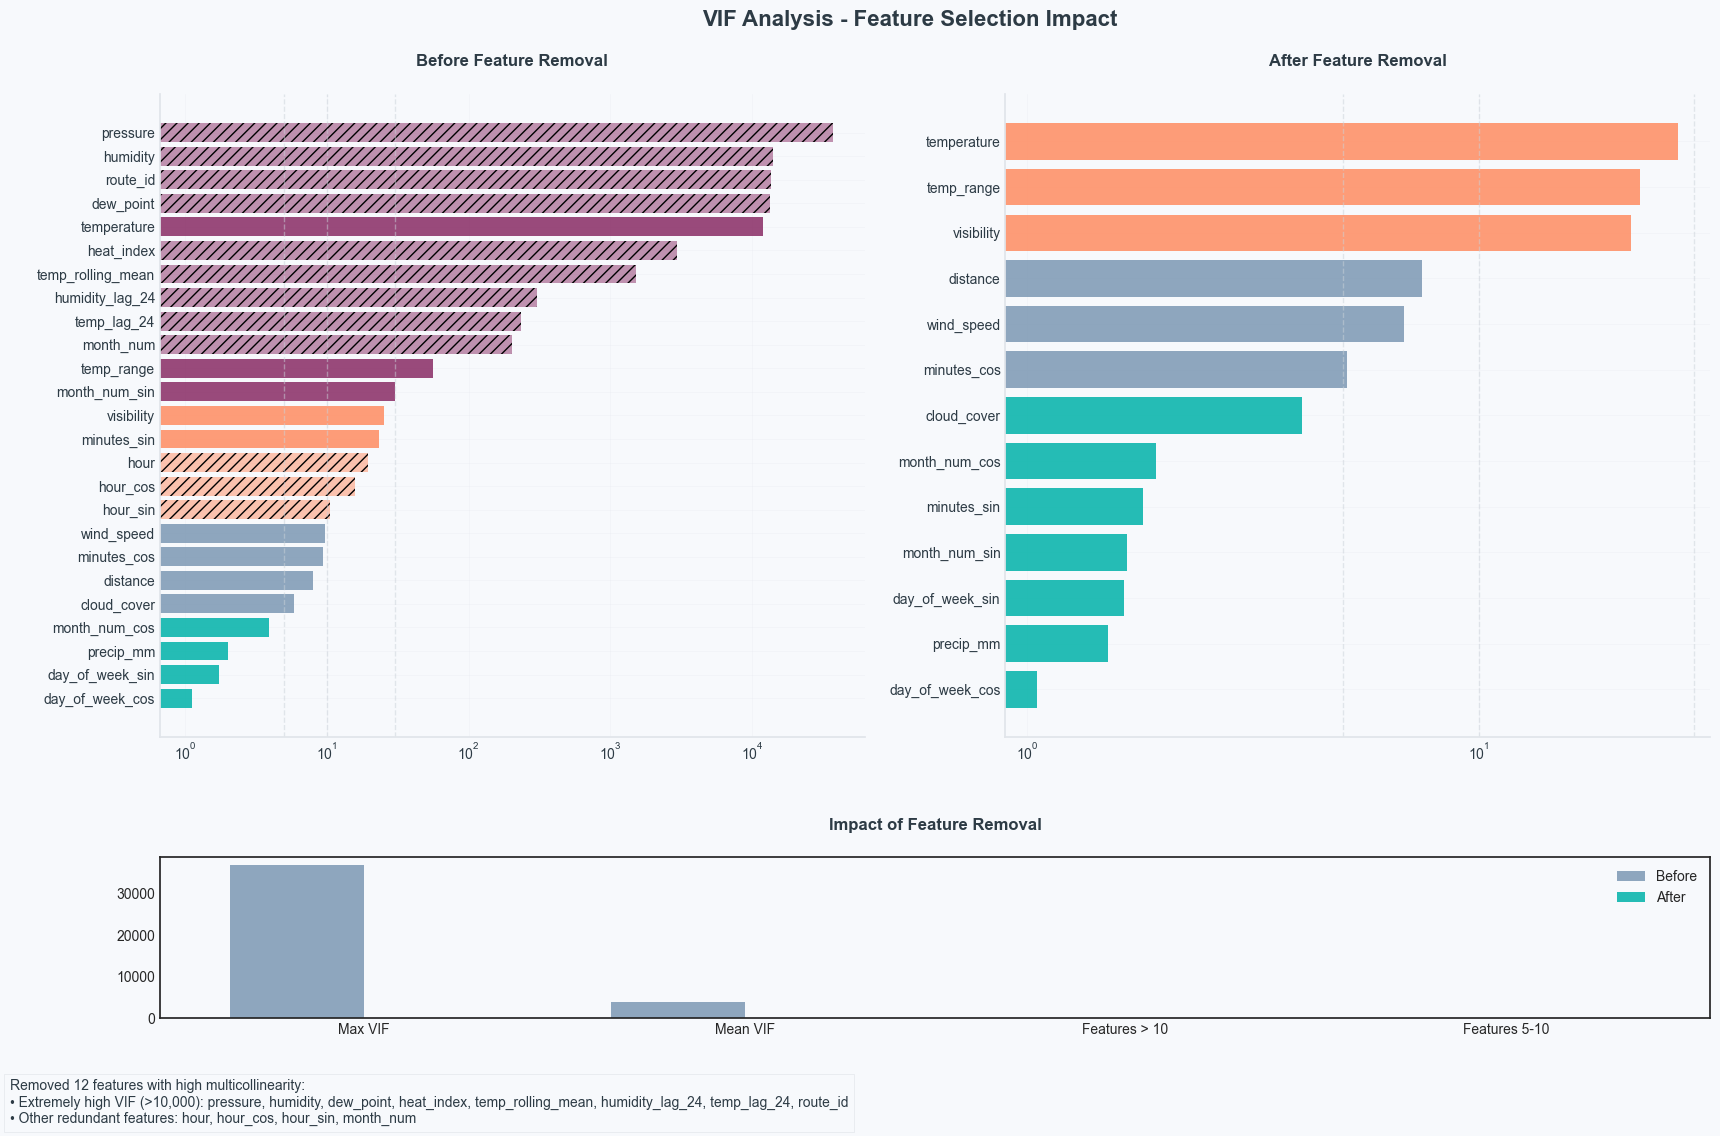


📊 VIF Analysis Summary:
Original dataset shape: (1066, 29)
Filtered dataset shape: (1066, 17)

Features removed: 12
Maximum VIF before: 36959.12
Maximum VIF after: 27.62


In [33]:
def get_vif_category(vif):
    """
    Categorize VIF values into interpretable groups.
    """
    if vif < 5:
        return 'Acceptable'
    elif vif < 10:
        return 'Moderate'
    elif vif < 30:
        return 'High'
    else:
        return 'Very High'
    
def compare_vif_analysis(original_df, features_to_drop, target_column='duration', figsize=(20, 12)):
    """
    Compare VIF analysis before and after feature removal with enhanced visualization.
    """
    # Style colors (matching previous visualization)
    style_colors = {
        'background': '#F7F9FC',    # Light blue-grey background
        'text': '#2D3B45',          # Dark blue-grey text
        'grid': '#E1E5EA',          # Soft grey grid
        'reference': '#CBD2D9',     # Medium grey reference lines
        'highlight': '#FF8C61'      # Highlight color for removed features
    }
    
    # Create filtered dataframe
    filtered_df = original_df.drop(columns=features_to_drop).copy()
    
    # Calculate VIF for both datasets
    vif_before = calculate_vif_scores(original_df, target_column)
    vif_after = calculate_vif_scores(filtered_df, target_column)
    
    # Set up the figure
    plt.style.use('seaborn-v0_8-white')
    fig = plt.figure(figsize=figsize, facecolor=style_colors['background'])
    gs = fig.add_gridspec(2, 2, height_ratios=[4, 1], width_ratios=[1, 1], hspace=0.3, wspace=0.2)
    
    # Plot before and after VIF comparisons
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Plot VIF before
    plot_vif_bars(vif_before, ax1, "Before Feature Removal", 
                  style_colors, features_to_drop)
    
    # Plot VIF after
    plot_vif_bars(vif_after, ax2, "After Feature Removal", 
                  style_colors)
    
    # Add summary statistics
    ax_stats = fig.add_subplot(gs[1, :])
    plot_summary_statistics(vif_before, vif_after, features_to_drop, ax_stats, style_colors)
    
    # Main title
    plt.suptitle('VIF Analysis - Feature Selection Impact', 
                 fontsize=16, y=0.95, color=style_colors['text'],
                 fontweight='bold')
    
    # Add feature removal summary
    summary_text = (
        f"Removed {len(features_to_drop)} features with high multicollinearity:\n"
        f"• Extremely high VIF (>10,000): {', '.join(features_to_drop[:8])}\n"
        f"• Other redundant features: {', '.join(features_to_drop[8:])}"
    )
    
    fig.text(0.05, 0.02, summary_text, 
             fontsize=10, color=style_colors['text'],
             ha='left', va='bottom',
             bbox=dict(facecolor=style_colors['background'], 
                      edgecolor=style_colors['grid'], 
                      alpha=0.9))
    
    plt.show()
    
    # Print detailed statistics
    print("\n📊 VIF Analysis Summary:")
    print("=" * 50)
    print(f"Original dataset shape: {original_df.shape}")
    print(f"Filtered dataset shape: {filtered_df.shape}")
    print(f"\nFeatures removed: {len(features_to_drop)}")
    print(f"Maximum VIF before: {vif_before['VIF'].max():.2f}")
    print(f"Maximum VIF after: {vif_after['VIF'].max():.2f}")
    
    return vif_after

def calculate_vif_scores(df, target_column):
    """Helper function to calculate VIF scores"""
    numeric_df = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    vif_data = pd.DataFrame({
        "Feature": numeric_df.columns,
        "VIF": [variance_inflation_factor(numeric_df.values, i) 
                for i in range(numeric_df.shape[1])]
    }).sort_values('VIF', ascending=True)
    
    vif_data['Category'] = vif_data['VIF'].apply(get_vif_category)
    return vif_data

def plot_vif_bars(vif_data, ax, title, style_colors, highlight_features=None):
    """Helper function to plot VIF bars with consistent styling"""
    colors = {
        'Acceptable': '#00B2A9',    # Teal
        'Moderate': '#7C98B3',      # Steel blue
        'High': '#FF8C61',          # Coral
        'Very High': '#892B64'      # Burgundy
    }
    
    bars = ax.barh(vif_data['Feature'], vif_data['VIF'], 
                   color=[colors[cat] for cat in vif_data['Category']],
                   alpha=0.85)
    
    # Highlight removed features if specified
    if highlight_features:
        for bar, feature in zip(bars, vif_data['Feature']):
            if feature in highlight_features:
                bar.set_alpha(0.5)
                bar.set_hatch('///')
    
    # Style the plot
    ax.set_facecolor(style_colors['background'])
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, color=style_colors['grid'])
    ax.set_title(title, pad=20, fontsize=12, color=style_colors['text'], fontweight='bold')
    
    # Add reference lines
    for line in [5, 10, 30]:
        ax.axvline(x=line, color=style_colors['reference'], 
                   linestyle='--', alpha=0.5, linewidth=1)
    
    # Style axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(style_colors['grid'])
    ax.spines['bottom'].set_color(style_colors['grid'])
    ax.tick_params(colors=style_colors['text'])

def plot_summary_statistics(vif_before, vif_after, removed_features, ax, style_colors):
    """Helper function to plot summary statistics"""
    ax.set_facecolor(style_colors['background'])
    
    # Calculate statistics
    stats = {
        'Max VIF': [vif_before['VIF'].max(), vif_after['VIF'].max()],
        'Mean VIF': [vif_before['VIF'].mean(), vif_after['VIF'].mean()],
        'Features > 10': [sum(vif_before['VIF'] > 10), sum(vif_after['VIF'] > 10)],
        'Features 5-10': [sum((vif_before['VIF'] > 5) & (vif_before['VIF'] <= 10)),
                         sum((vif_after['VIF'] > 5) & (vif_after['VIF'] <= 10))]
    }
    
    # Plot statistics
    x = np.arange(len(stats))
    width = 0.35
    
    ax.bar(x - width/2, [stats[k][0] for k in stats], width, 
           label='Before', color='#7C98B3', alpha=0.85)
    ax.bar(x + width/2, [stats[k][1] for k in stats], width,
           label='After', color='#00B2A9', alpha=0.85)
    
    ax.set_xticks(x)
    ax.set_xticklabels(stats.keys())
    ax.legend()
    ax.set_title('Impact of Feature Removal', 
                 pad=20, fontsize=12, color=style_colors['text'], fontweight='bold')

# Remove features with high VIF first
features_to_drop = [
    # Extremely high VIF (>10,000)
    'pressure', 'humidity', 'dew_point', 'heat_index','temp_rolling_mean', 'humidity_lag_24', 'temp_lag_24', 'route_id',
    
    # Other redundant features
    'hour', 'hour_cos', 'hour_sin', 'month_num'
]

# Run the enhanced analysis
vif_results_round2 = compare_vif_analysis(filtered_df, features_to_drop, 'duration')

## Encoding and Features Scaling

In [34]:
vif_results_round2

Feature        VIF    Category
2   day_of_week_cos   1.054105  Acceptable
6         precip_mm   1.509714  Acceptable
1   day_of_week_sin   1.636680  Acceptable
10    month_num_sin   1.661676  Acceptable
3       minutes_sin   1.809724  Acceptable
11    month_num_cos   1.931082  Acceptable
8       cloud_cover   4.061328  Acceptable
4       minutes_cos   5.119234    Moderate
9        wind_speed   6.844546    Moderate
0          distance   7.503721    Moderate
7        visibility  21.701864        High
12       temp_range  22.743157        High
5       temperature  27.615291        High

In [117]:
vif_filtered_df= filtered_df.drop(features_to_drop, axis=1)

In [37]:
vif_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_stop        1066 non-null   object 
 1   duration          1066 non-null   float64
 2   distance          1066 non-null   float64
 3   day_of_week_sin   1066 non-null   float64
 4   day_of_week_cos   1066 non-null   float64
 5   minutes_sin       1066 non-null   float64
 6   minutes_cos       1066 non-null   float64
 7   temperature       1066 non-null   int64  
 8   precip_mm         1066 non-null   float64
 9   visibility        1066 non-null   int64  
 10  cloud_cover       1066 non-null   int64  
 11  wind_speed        1066 non-null   int64  
 12  month_num_sin     1066 non-null   float64
 13  month_num_cos     1066 non-null   float64
 14  temp_range        1066 non-null   int64  
 15  humidity_comfort  1066 non-null   object 
 16  heat_stress       1066 non-null   object 


## Data Splitting

In [118]:
features = vif_filtered_df.drop('duration', axis=1).columns.to_list()
target = 'duration'

# Create a copy of the features DataFrame
X = vif_filtered_df.drop('duration', axis=1).copy()
y = vif_filtered_df['duration'].copy()

# identify categorical columns
categorical_features = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_features.tolist()}")

for col in categorical_features:
    vif_filtered_df[col] = vif_filtered_df[col].astype('category')

# Random Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=X['month_num_cos'], 
    random_state=42
)

Categorical columns: ['start_stop', 'humidity_comfort', 'heat_stress']


## Saving train and test data

In [40]:
# Combine the X and y, then save train and test data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('..\\data\\processed\\train_data3.csv', index=False)
test_data.to_csv('..\\data\\processed\\test_data3.csv', index=False)

In [41]:
X_train = train_data.drop('duration', axis=1)
y_train = train_data['duration']
X_test = test_data.drop('duration', axis=1)
y_test = test_data['duration']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((852, 16), (852,), (214, 16), (214,))

## Feature Selection

Feature selection is a critical step in developing predictive models, as it determines which features have the most influence on the target variable. However, no single method is perfect, and each approach has its strengths and limitations. To build a comprehensive understanding of feature importance, this analysis leverages multiple methods, each providing a different perspective on the data. By combining these methods, we can reduce individual biases and increase the robustness of our feature selection.

**Methods Overview**

**1. CatBoost Feature Importance (Tree-based)**

CatBoost feature importance provides insights based on the reduction of the model’s loss function across all trees. By analyzing how each feature contributes to decreasing prediction error, this method captures complex, non-linear relationships and interactions.

**Advantages**: 
- Handles numeric and categorical features without additional preprocessing.
- Captures non-linear dependencies and feature interactions inherently.

**Limitations**:
- Can favor features with high cardinality.
- Sensitive to model hyperparameters, which may affect reliability.

CatBoost serves as a strong starting point, particularly useful when the data includes non-linear patterns and interactions that simpler methods might miss.

**2. Mutual Information (Statistical)**

Mutual Information (MI) quantifies the shared information between a feature and the target variable, identifying both linear and non-linear dependencies. A higher MI value suggests a stronger relationship.

**Advantages**:
- Captures complex, non-linear dependencies.
- Scale-invariant, applicable to both continuous and discrete features.

**Limitations**:
- Sensitive to noise, especially in small datasets.
- Requires careful treatment of categorical variables and is computationally demanding for large datasets.

Mutual Information provides a statistical basis for understanding feature relevance, particularly effective when linear models do not suffice.

**3. Correlation Analysis (Statistical)**

Correlation analysis measures the strength of a linear relationship between features and the target. Pearson correlation is used for numerical features, while mean target encoding is applied for categorical features.

**Advantages**:
- Simple and interpretable.
- Efficient and computationally straightforward.

**Limitations**:
- Limited to linear relationships, potentially missing non-linear dependencies.
- Prone to distortion from outliers.

Correlation analysis offers a clear and interpretable baseline but needs to be supplemented with methods that capture non-linear interactions.

**4. Permutation Importance (Model-agnostic)**

Permutation importance evaluates how model performance changes when a feature is randomly shuffled. This approach is useful for understanding the real-world impact of each feature on model predictions.

**Advantages**:
- Applicable to any model, providing a flexible, model-agnostic assessment.
- Considers feature interactions and the effect on model error.

**Limitations**:
- Computationally intensive.
- Results can be skewed if features are highly correlated.

This method complements others by offering a more performance-driven perspective, independent of the model used.

**5. SHAP Values (Model-agnostic)**

SHAP values explain each feature’s contribution to a prediction, based on Shapley values from cooperative game theory. They provide a nuanced view of feature importance, considering all possible combinations of features.

**Advantages**:
- Comprehensive, offering both local and global interpretability.
- Theoretically grounded and reliable.

**Limitations**:
- Computationally expensive and complex.
- Interpretation may be challenging without domain expertise.

SHAP values are crucial for detailed interpretability, allowing us to understand the reasoning behind feature importance.

**Consensus Approach**

Relying on a single method can introduce biases or overlook important relationships in the data. By integrating multiple approaches, we can achieve a balanced and comprehensive feature selection strategy. Here’s how the methods complement each other:

- **CatBoost** captures non-linear dependencies and interactions but may be prone to high cardinality biases. **Permutation Importance** and **SHAP Values** help validate and interpret these findings.
- **Mutual Information** excels in detecting non-linear relationships but can be noisy. **Correlation Analysis** provides a simpler, linear perspective, ensuring that we don’t miss straightforward relationships.
- **Permutation Importance** confirms the actual impact of features on model performance, while **SHAP Values** add a layer of interpretability, explaining the effects of each feature.

*Method Weights and Normalization*

To ensure fairness and comparability, importance scores from all methods are normalized to a [0,1] range. We assign weights based on the strengths of each method, emphasizing those with strong theoretical foundations and robust performance metrics.

This combined approach minimizes the limitations of individual methods while leveraging their strengths. By validating results across different methodologies, we reduce the risk of relying on spurious relationships and create a more robust feature selection process that can enhance the model's predictive power.

In summary, the use of multiple feature selection methods allows for a comprehensive assessment of feature importance. The consensus approach balances statistical insights, model-driven measures, and theoretical considerations, ensuring that our model is both accurate and interpretable. This strategy sets the stage for more reliable and effective predictive modeling.



In [136]:
import matplotlib
matplotlib.use('Agg')

In [139]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool
import shap

class FeatureImportanceAnalyzer:
    """
    A comprehensive framework for ensemble feature selection using multiple methods
    and sensitivity analysis.
    """
    
    def __init__(self, style_colors=None):
        """Initialize the analyzer with visual style settings and method characteristics"""
        # Visual styling
        self.style_colors = style_colors or {
            'background': '#F7F9FC',
            'text': '#2D3B45',
            'grid': '#E1E5EA',
            'bars': ['#00B2A9', '#7C98B3', '#FF8C61', '#892B64', '#2D5D7C']
        }
        
        # Method characteristics and weights
        self.method_characteristics = {
            'catboost': {
                'type': 'tree_based',
                'handles_nonlinear': True,
                'handles_interactions': True,
                'interpretability': 'medium',
                'computational_cost': 'high'
            },
            'mutual_info': {
                'type': 'statistical',
                'handles_nonlinear': True,
                'handles_interactions': False,
                'interpretability': 'high',
                'computational_cost': 'medium'
            },
            'correlation': {
                'type': 'statistical',
                'handles_nonlinear': False,
                'handles_interactions': False,
                'interpretability': 'high',
                'computational_cost': 'low'
            },
            'permutation': {
                'type': 'model_agnostic',
                'handles_nonlinear': True,
                'handles_interactions': True,
                'interpretability': 'medium',
                'computational_cost': 'high'
            },
            'shap': {
                'type': 'model_agnostic',
                'handles_nonlinear': True,
                'handles_interactions': True,
                'interpretability': 'high',
                'computational_cost': 'high'
            }
        }
        
        # Default weight parameters
        self.default_reliability_weight = 0.6
        self.default_diversity_weight = 0.4

    def analyze_features(self, X, y, categorical_features, figsize=(15, 20), print_results=True):
        """Main method to analyze feature importance using multiple methods"""
        if print_results:
            print("Calculating feature importance using multiple methods...")
        
        # Get CatBoost importance
        if print_results:
            print("\nCalculating CatBoost importance...")
        cb_model, cb_importance = self._get_catboost_importance(X, y, categorical_features)
        
        # Get Mutual Information importance
        if print_results:
            print("Calculating Mutual Information importance...")
        mi_importance = self._get_mutual_info_importance(X, y, categorical_features)
        
        # Get Correlation importance
        if print_results:
            print("Calculating Correlation importance...")
        corr_importance = self._get_correlation_importance(X, y, categorical_features)
        
        # Get Permutation importance
        if print_results:
            print("Calculating Permutation importance...")
        perm_importance = self._get_permutation_importance(cb_model, X, y)
        
        # Get SHAP importance
        if print_results:
            print("Calculating SHAP importance...")
        shap_values, shap_importance = self._get_shap_importance(cb_model, X)
        
        results_dict = {
            'catboost': cb_importance,
            'mutual_info': mi_importance,
            'correlation': corr_importance,
            'permutation': perm_importance,
            'shap': shap_importance
        }
        
        if print_results:
            self._plot_importance_comparison(results_dict, shap_values, X, figsize)
            plt.show()  # Explicitly show the plots
        return results_dict

    def _normalize_importance(self, importance_scores):
        """Normalize importance scores to [0, 1] range"""
        min_val = importance_scores.min()
        max_val = importance_scores.max()
        return (importance_scores - min_val) / (max_val - min_val)

    def _get_catboost_importance(self, X, y, categorical_features):
        """Calculate CatBoost feature importance"""
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        cb_model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            cat_features=list(categorical_features),
            verbose=False,
            random_state=42
        )
        
        train_pool = Pool(X_transformed, y, cat_features=list(categorical_features))
        cb_model.fit(train_pool)
        
        return cb_model, pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(cb_model.feature_importances_)
        }).sort_values('importance', ascending=True)

    def _get_mutual_info_importance(self, X, y, categorical_features):
        """Calculate Mutual Information importance"""
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        mi_scores = []
        for col in X_transformed.columns:
            if col in categorical_features:
                mi_score = mutual_info_regression(
                    pd.get_dummies(X_transformed[col]).values,
                    y,
                    random_state=42
                ).sum()
            else:
                mi_score = mutual_info_regression(
                    X_transformed[[col]].values,
                    y,
                    random_state=42
                )[0]
            mi_scores.append(mi_score)
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.array(mi_scores))
        }).sort_values('importance', ascending=True)

    def _get_correlation_importance(self, X, y, categorical_features):
        """Calculate correlation-based importance"""
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        corr_scores = []
        for col in X_transformed.columns:
            if col in categorical_features:
                means = y.groupby(X_transformed[col]).mean()
                score = abs(pearsonr(X_transformed[col].map(means), y)[0])
            else:
                score = abs(pearsonr(X_transformed[col], y)[0])
            corr_scores.append(score)
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.array(corr_scores))
        }).sort_values('importance', ascending=True)

    def _get_permutation_importance(self, model, X, y):
        """Calculate permutation importance"""
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        perm_importance = permutation_importance(
            model, X_transformed, y,
            n_repeats=10,
            random_state=42,
            scoring='neg_root_mean_squared_error'
        )
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.abs(perm_importance.importances_mean))
        }).sort_values('importance', ascending=True)

    def _get_shap_importance(self, model, X):
        """Calculate SHAP importance"""
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_transformed)
        
        return shap_values, pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.abs(shap_values).mean(axis=0))
        }).sort_values('importance', ascending=True)

    def _plot_importance_comparison(self, results_dict, shap_values, X, figsize=(15, 20)):
        """Plot comparison of feature importance from different methods"""
        # Create two separate figures
        # Figure 1: Method comparisons
        fig1 = plt.figure(figsize=(15, 15))
        gs1 = fig1.add_gridspec(3, 2)
        
        # Plot individual method results
        for idx, (method, result) in enumerate(results_dict.items()):
            ax = fig1.add_subplot(gs1[idx // 2, idx % 2])
            self._plot_importance_bars(ax, result, f"{method.capitalize()} Feature Importance", idx)
        
        plt.tight_layout()
        plt.show()  # Explicitly show the first figure
        
        # Figure 2: SHAP summary
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values, 
            X,
            plot_type="bar",
            show=False  # Don't show immediately
        )
        plt.tight_layout()
        plt.show()  # Explicitly show the second figure

    def _plot_importance_bars(self, ax, data, title, idx):
        """Plot horizontal bar chart for feature importance"""
        ax.set_facecolor(self.style_colors['background'])
        
        # Use modulo to cycle through colors if we have more methods than colors
        color_idx = idx % len(self.style_colors['bars'])
        bars = ax.barh(data['feature'], data['importance'], 
                    color=self.style_colors['bars'][color_idx],
                    alpha=0.85)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}', 
                    ha='left', va='center',
                    fontsize=8)
        
        # Customize appearance
        ax.set_title(title, pad=20, fontsize=12, color=self.style_colors['text'])
        ax.grid(True, alpha=0.3, color=self.style_colors['grid'])
        ax.tick_params(colors=self.style_colors['text'])
        
        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color(self.style_colors['grid'])
        ax.spines['bottom'].set_color(self.style_colors['grid'])

    def get_consensus_features(self, results, reliability_weight=0.6, diversity_weight=0.4, n_features=10):
        """Get consensus features using specified weights"""
        reliability_scores, diversity_scores = self._calculate_dynamic_weights(results)
        
        # Calculate final weights
        final_weights = {}
        for method in results.keys():
            final_weights[method] = (
                reliability_scores[method] * reliability_weight +
                diversity_scores[method] * diversity_weight
            )
        
        # Get top features for each method
        top_features = {
            method: df.sort_values('importance', ascending=False)['feature'].tolist()
            for method, df in results.items()
        }
        
        # Calculate weighted feature importance
        feature_scores = {}
        for method, features_df in results.items():
            for _, row in features_df.iterrows():
                feature = row['feature']
                if feature not in feature_scores:
                    feature_scores[feature] = 0
                feature_scores[feature] += row['importance'] * final_weights[method]
        
        # Sort features by importance and get top n_features
        consensus_features = sorted(
            feature_scores.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:n_features]
        
        # Convert to list of features with their scores
        consensus_features = [(feature, score) for feature, score in consensus_features]
        
        return [feature for feature, _ in consensus_features], final_weights, top_features, consensus_features

    def _calculate_dynamic_weights(self, results):
        """Calculate dynamic weights based on method agreement and characteristics"""
        # Calculate correlation matrix
        importance_corr = pd.DataFrame({
            method: results[method].set_index('feature')['importance']
            for method in results.keys()
        })
        corr_matrix = importance_corr.corr(method='spearman')
        
        # Calculate diversity scores
        diversity_scores = {}
        for method in results.keys():
            other_methods = [m for m in results.keys() if m != method]
            avg_correlation = np.mean([corr_matrix.loc[method, other] for other in other_methods])
            diversity_scores[method] = 1 - abs(avg_correlation)
        
        # Calculate reliability scores
        reliability_scores = {}
        for method, chars in self.method_characteristics.items():
            score = 1.0
            if chars['handles_nonlinear']:
                score *= 1.1
            if chars['handles_interactions']:
                score *= 1.1
            if chars['interpretability'] == 'high':
                score *= 1.05
            if chars['computational_cost'] == 'low':
                score *= 1.02
            reliability_scores[method] = score
        
        # Normalize scores
        total_reliability = sum(reliability_scores.values())
        total_diversity = sum(diversity_scores.values())
        
        reliability_scores = {k: v/total_reliability for k, v in reliability_scores.items()}
        diversity_scores = {k: v/total_diversity for k, v in diversity_scores.items()}
        
        return reliability_scores, diversity_scores
    
    def perform_sensitivity_analysis(self, results, weight_range=(0.4, 0.8), n_iterations=5):
        """
        Perform sensitivity analysis by varying the weights and analyzing feature stability
        
        Parameters:
        -----------
        results : dict
            Dictionary containing the results from different feature selection methods
        weight_range : tuple
            Range of weights to test (min, max)
        n_iterations : int
            Number of different weight combinations to test
        
        Returns:
        --------
        list : List of dictionaries containing results for each weight combination
        """
        sensitivity_results = []
        weights = np.linspace(weight_range[0], weight_range[1], n_iterations)
        
        for reliability_weight in weights:
            diversity_weight = 1 - reliability_weight
            consensus_features, final_weights, top_features, consensus_features_with_scores = self.get_consensus_features(
                results,
                reliability_weight=reliability_weight,
                diversity_weight=diversity_weight,
                n_features=10
            )
            
            sensitivity_results.append({
                'reliability_weight': reliability_weight,
                'diversity_weight': diversity_weight,
                'features': consensus_features
            })
        
        # Analyze feature stability
        feature_stability = {}
        for result in sensitivity_results:
            for feature in result['features']:
                feature_stability[feature] = feature_stability.get(feature, 0) + 1
        
        # Print analysis results once at the end
        self._print_analysis_results(results, top_features, consensus_features_with_scores, final_weights)
        
        # Print stability analysis
        print("\n📊 Feature Stability Analysis")
        print("=" * 50)
        print("\nFeature stability across different weight combinations:")
        for feature, count in sorted(feature_stability.items(), key=lambda x: x[1], reverse=True):
            stability = count / len(sensitivity_results)
            print(f"  • {feature:<20}: {stability:.1%} stability")
        
        return sensitivity_results

    def _print_analysis_results(self, results, top_features, consensus_features, final_weights):
        """Print detailed analysis results"""
        print("\n📊 Feature Selection Analysis")
        print("=" * 50)
        print("\nMethod Weights:")
        for method, weight in final_weights.items():
            print(f"  • {method:<12}: {weight:.3f}")
        
        print("\nTop Features by Method:")
        for method, features in top_features.items():
            print(f"\n{method.capitalize()}:")
            df = results[method].set_index('feature')
            important_features = df[df['importance'] > 0.05].sort_values('importance', ascending=False)
            for i, (feature, row) in enumerate(important_features.iterrows(), 1):
                print(f"  {i}. {feature:<20} ({row['importance']:.3f})")
        
        print("\n🌟 Consensus Features:")
        for i, (feature, score) in enumerate(consensus_features, 1):
            methods = [m for m, f in top_features.items() if feature in f]
            print(f"  {i}. {feature:<20} (Score: {score:.3f}, Methods: {', '.join(methods)})")

def run_feature_selection_experiment(data, target_col='duration'):
    """Run complete feature selection experiment"""
    # Prepare data
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Initialize analyzer and run analysis
    analyzer = FeatureImportanceAnalyzer()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Run analysis once and store results
        results = analyzer.analyze_features(X, y, categorical_features, print_results=False)
        
        # Get consensus features with final printing
        consensus_features, final_weights, top_features, consensus_features_with_scores = analyzer.get_consensus_features(results)
        
        # Optionally run sensitivity analysis
        sensitivity_results = analyzer.perform_sensitivity_analysis(results)
    
    return consensus_features, results, sensitivity_results

# Usage example
if __name__ == "__main__":
    # Suppress warnings
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', message='Converting `np.inexact` or `np.floating` to a dtype is deprecated')
    
    # Run feature selection
    consensus_features, results, sensitivity_results = run_feature_selection_experiment(vif_filtered_df)


📊 Feature Selection Analysis

Method Weights:
  • catboost    : 0.191
  • mutual_info : 0.197
  • correlation : 0.217
  • permutation : 0.194
  • shap        : 0.201

Top Features by Method:

Catboost:
  1. distance             (1.000)
  2. minutes_sin          (0.487)
  3. start_stop           (0.208)
  4. minutes_cos          (0.139)
  5. cloud_cover          (0.070)

Mutual_info:
  1. distance             (1.000)
  2. minutes_sin          (0.704)
  3. start_stop           (0.674)
  4. minutes_cos          (0.612)
  5. month_num_sin        (0.059)

Correlation:
  1. distance             (1.000)
  2. start_stop           (0.814)
  3. minutes_sin          (0.671)
  4. minutes_cos          (0.543)
  5. precip_mm            (0.132)
  6. humidity_comfort     (0.092)
  7. day_of_week_sin      (0.081)
  8. month_num_cos        (0.081)
  9. visibility           (0.066)
  10. heat_stress          (0.057)

Permutation:
  1. distance             (1.000)
  2. minutes_sin          (0.653)
  3. s

In [138]:
plt.close('all')  # Clear all existing plots

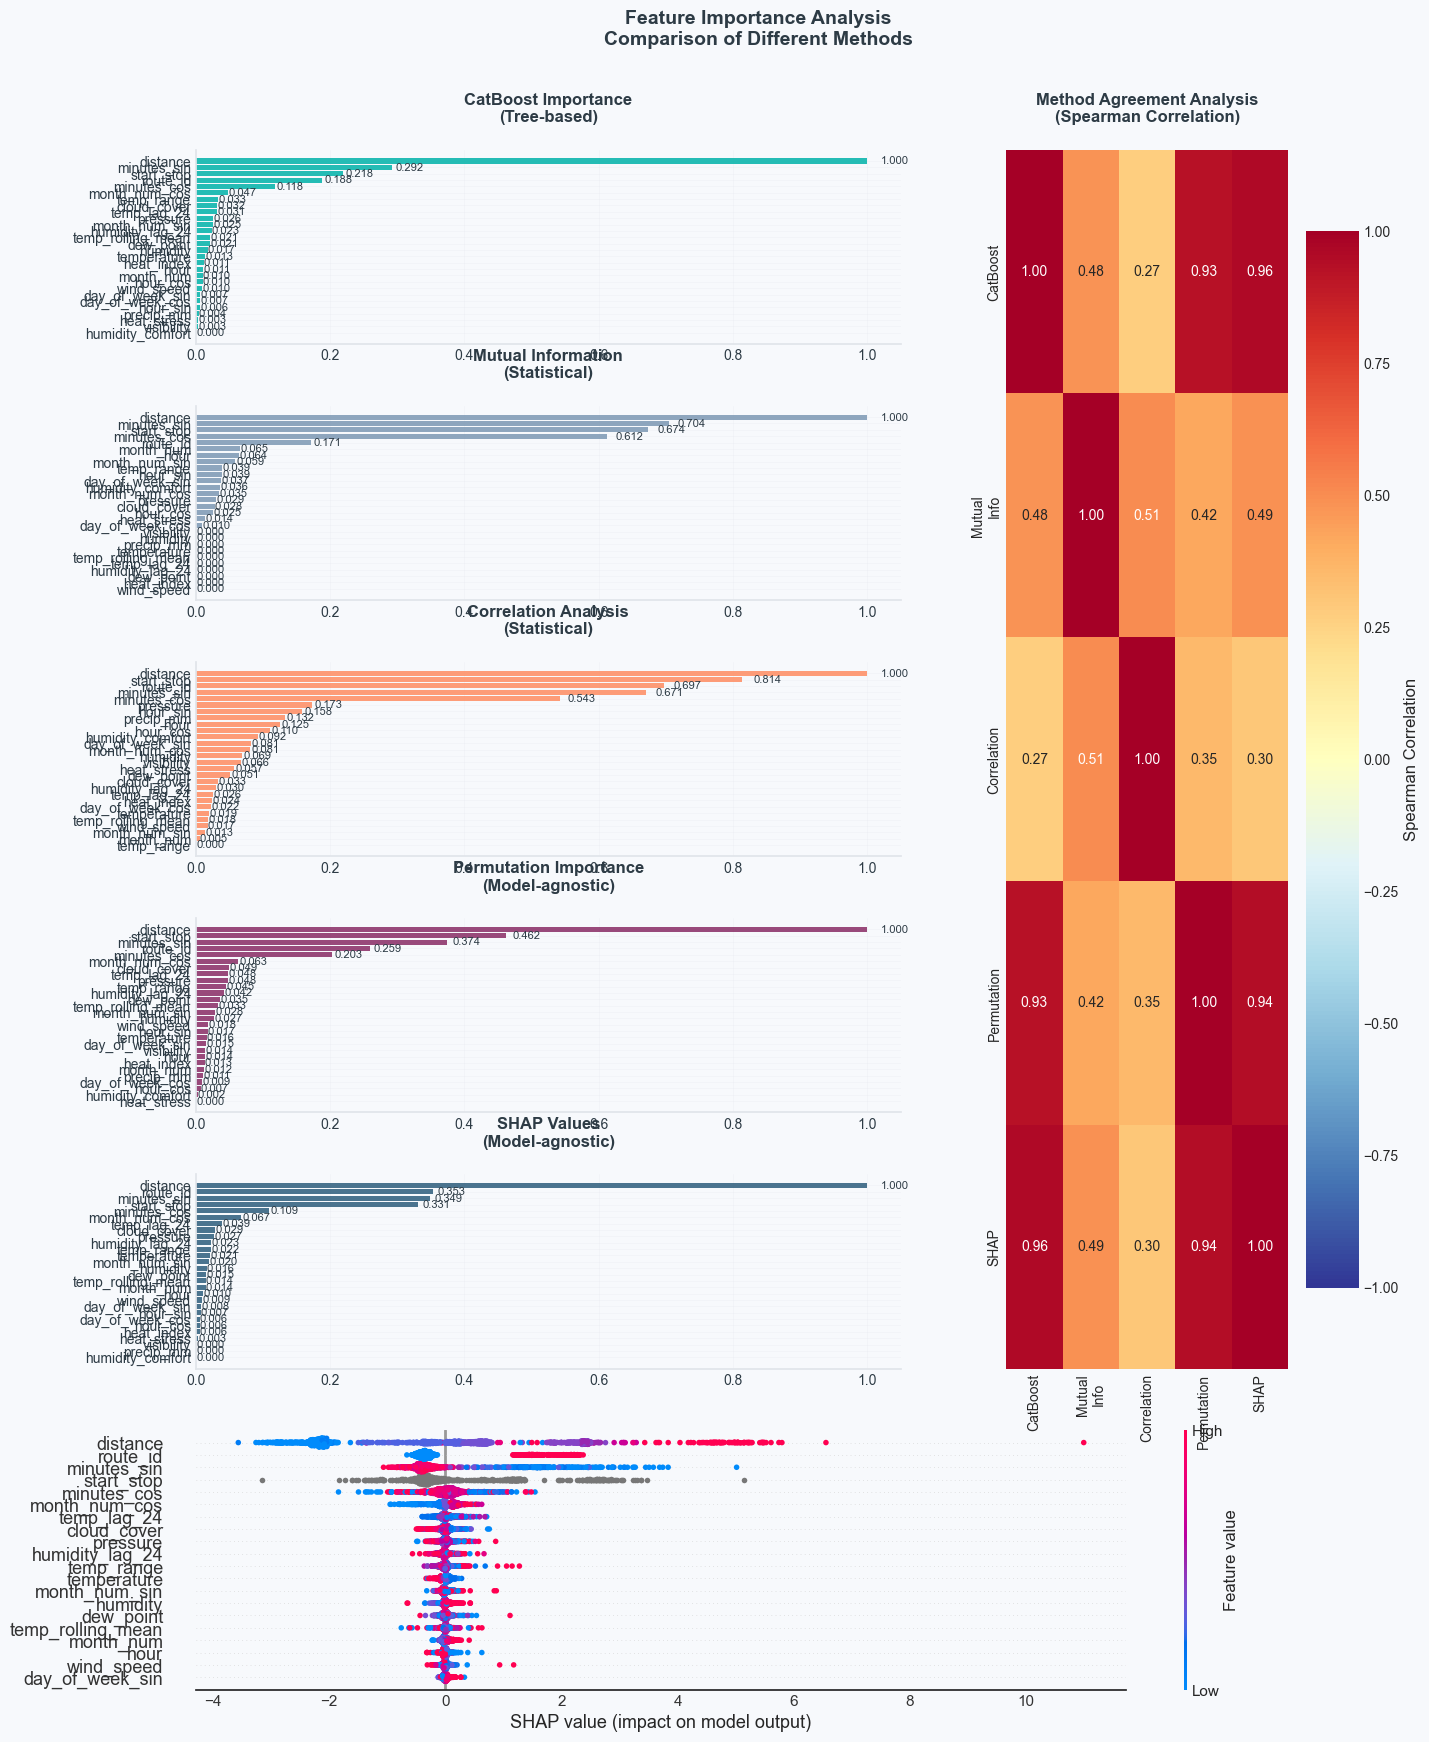


📊 Feature Selection Analysis

🔍 Top 10 features by catboost (weight: 1.0):
  1. distance             (1.0000)
  2. minutes_sin          (0.2916)
  3. start_stop           (0.2183)
  4. route_id             (0.1876)
  5. minutes_cos          (0.1179)
  6. month_num_cos        (0.0469)
  7. temp_range           (0.0326)
  8. cloud_cover          (0.0315)
  9. temp_lag_24          (0.0307)
  10. pressure             (0.0259)

🔍 Top 10 features by mutual_info (weight: 1.0):
  1. distance             (1.0000)
  2. minutes_sin          (0.7042)
  3. start_stop           (0.6736)
  4. minutes_cos          (0.6125)
  5. route_id             (0.1713)
  6. month_num            (0.0654)
  7. hour                 (0.0641)
  8. month_num_sin        (0.0587)
  9. temp_range           (0.0394)
  10. hour_sin             (0.0389)

🔍 Top 10 features by correlation (weight: 0.8):
  1. distance             (1.0000)
  2. start_stop           (0.8144)
  3. route_id             (0.6972)
  4. minutes_sin   

In [121]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool

class FeatureImportanceAnalyzer:
    """Class to analyze feature importance using multiple methods"""
    
    def __init__(self, style_colors=None):
        self.style_colors = style_colors or {
            'background': '#F7F9FC',
            'text': '#2D3B45',
            'grid': '#E1E5EA',
            'bars': ['#00B2A9', '#7C98B3', '#FF8C61', '#892B64', '#2D5D7C']
        }
        
        self.method_weights = {
            'catboost': 1.0,      # Tree-based
            'mutual_info': 1.0,   # Statistical
            'correlation': 0.8,    # Statistical (slightly lower weight)
            'permutation': 1.0,   # Model-agnostic
            'shap': 1.2           # Model-agnostic (slightly higher weight)
        }
    
    def _normalize_importance(self, importance_scores):
        """Normalize importance scores to [0, 1] range"""
        min_val = importance_scores.min()
        max_val = importance_scores.max()
        return (importance_scores - min_val) / (max_val - min_val)
    
    def _get_catboost_importance(self, X, y, categorical_features):
        """Calculate CatBoost feature importance"""
        # Apply cube root transformation to distance
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        cb_model = CatBoostRegressor(
            iterations=1000, 
            learning_rate=0.1, 
            depth=6,
            cat_features=list(categorical_features), 
            verbose=False, 
            random_state=42
        )
        train_pool = Pool(X_transformed, y, cat_features=list(categorical_features))
        cb_model.fit(train_pool)
        
        return cb_model, pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(cb_model.feature_importances_)
        }).sort_values('importance', ascending=True)
    
    def _get_mutual_info_importance(self, X, y, categorical_features):
        """Calculate Mutual Information importance"""
        # Apply cube root transformation to distance
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        mi_scores = []
        for col in X_transformed.columns:
            if col in categorical_features:
                mi_score = mutual_info_regression(
                    pd.get_dummies(X_transformed[col]).values,
                    y,
                    random_state=42
                ).sum()
            else:
                mi_score = mutual_info_regression(
                    X_transformed[[col]].values,
                    y,
                    random_state=42
                )[0]
            mi_scores.append(mi_score)
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.array(mi_scores))
        }).sort_values('importance', ascending=True)
    
    def _get_correlation_importance(self, X, y, categorical_features):
        """Calculate correlation-based importance"""
        # Apply cube root transformation to distance
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        corr_scores = []
        for col in X_transformed.columns:
            if col in categorical_features:
                means = y.groupby(X_transformed[col]).mean()
                score = abs(pearsonr(X_transformed[col].map(means), y)[0])
            else:
                score = abs(pearsonr(X_transformed[col], y)[0])
            corr_scores.append(score)
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.array(corr_scores))
        }).sort_values('importance', ascending=True)
    
    def _get_permutation_importance(self, model, X, y):
        """Calculate permutation importance"""
        # Apply cube root transformation to distance
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        perm_importance = permutation_importance(
            model, X_transformed, y, 
            n_repeats=10, 
            random_state=42,
            scoring='neg_root_mean_squared_error'
        )
        
        return pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.abs(perm_importance.importances_mean)),
            'std': perm_importance.importances_std
        }).sort_values('importance', ascending=True)
    
    def _get_shap_importance(self, model, X):
        """Calculate SHAP importance"""
        # Apply cube root transformation to distance
        X_transformed = X.copy()
        if 'distance' in X_transformed.columns:
            X_transformed['distance'] = np.cbrt(X_transformed['distance'])
            
        import shap
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_transformed)
        
        return shap_values, pd.DataFrame({
            'feature': X.columns,
            'importance': self._normalize_importance(np.abs(shap_values).mean(axis=0))
        }).sort_values('importance', ascending=True)
    
    def analyze_features(self, X, y, categorical_features, figsize=(15, 20)):
        """Run complete feature importance analysis"""
        # Get importances from different methods
        cb_model, cb_importance = self._get_catboost_importance(X, y, categorical_features)
        mi_importance = self._get_mutual_info_importance(X, y, categorical_features)
        corr_importance = self._get_correlation_importance(X, y, categorical_features)
        perm_importance = self._get_permutation_importance(cb_model, X, y)
        shap_values, shap_importance = self._get_shap_importance(cb_model, X)
        
        # Store results
        results_dict = {
            'catboost': cb_importance,
            'mutual_info': mi_importance,
            'correlation': corr_importance,
            'permutation': perm_importance,
            'shap': shap_importance
        }
        
        # Create visualization
        self._plot_importance_comparison(
            results_dict, 
            shap_values, 
            X,
            figsize=figsize
        )
        
        return results_dict
    
    def _plot_importance_comparison(self, results_dict, shap_values, X, figsize):
        """Create comprehensive visualization of feature importance"""
        plt.style.use('seaborn-v0_8-white')
        fig = plt.figure(figsize=figsize, facecolor=self.style_colors['background'])
        gs = fig.add_gridspec(6, 2, height_ratios=[3, 3, 3, 3, 3, 4], 
                            width_ratios=[2, 1], hspace=0.3)
        
        # Plot importance comparisons
        importance_data = [
            (results_dict['catboost'], 'CatBoost Importance\n(Tree-based)', 0),
            (results_dict['mutual_info'], 'Mutual Information\n(Statistical)', 1),
            (results_dict['correlation'], 'Correlation Analysis\n(Statistical)', 2),
            (results_dict['permutation'], 'Permutation Importance\n(Model-agnostic)', 3),
            (results_dict['shap'], 'SHAP Values\n(Model-agnostic)', 4)
        ]
        
        for data, title, idx in importance_data:
            self._plot_importance_bars(fig, gs[idx, 0], data, title, idx)
        
        # Add SHAP summary plot
        ax_shap = fig.add_subplot(gs[5, :])
        import shap
        shap.summary_plot(shap_values, X, show=False, plot_size=None)
        ax_shap.set_facecolor(self.style_colors['background'])
        
        # Add correlation heatmap
        self._plot_correlation_heatmap(fig, gs[0:5, 1], results_dict)
        
        # Main title
        plt.suptitle('Feature Importance Analysis\nComparison of Different Methods', 
                    fontsize=14, 
                    y=0.95, 
                    color=self.style_colors['text'],
                    fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_importance_bars(self, fig, position, data, title, idx):
        """Plot horizontal bar chart for feature importance"""
        ax = fig.add_subplot(position)
        ax.set_facecolor(self.style_colors['background'])
        
        # Use modulo to cycle through colors if we have more methods than colors
        color_idx = idx % len(self.style_colors['bars'])
        bars = ax.barh(data['feature'], data['importance'], 
                    color=self.style_colors['bars'][color_idx],
                    alpha=0.85)
        
        # Add value labels
        for bar in bars:
            width = bar.get_width()
            ax.text(width * 1.02, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', 
                   va='center', fontsize=8,
                   color=self.style_colors['text'])
        
        # Customize plot
        ax.set_title(title, pad=20, fontsize=12, 
                    color=self.style_colors['text'], fontweight='bold')
        ax.grid(True, alpha=0.3, color=self.style_colors['grid'])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color(self.style_colors['grid'])
        ax.spines['bottom'].set_color(self.style_colors['grid'])
        ax.tick_params(colors=self.style_colors['text'])
    
    def _plot_correlation_heatmap(self, fig, position, results_dict):
        """Plot correlation heatmap between different methods"""
        ax_corr = fig.add_subplot(position)
        importance_corr = pd.DataFrame({
            'CatBoost': results_dict['catboost'].set_index('feature')['importance'],
            'Mutual\nInfo': results_dict['mutual_info'].set_index('feature')['importance'],
            'Correlation': results_dict['correlation'].set_index('feature')['importance'],
            'Permutation': results_dict['permutation'].set_index('feature')['importance'],
            'SHAP': results_dict['shap'].set_index('feature')['importance']
        })
        
        corr_matrix = importance_corr.corr(method='spearman')
        
        sns.heatmap(corr_matrix, 
                   annot=True, 
                   cmap='RdYlBu_r',
                   ax=ax_corr, 
                   center=0, 
                   vmin=-1, 
                   vmax=1,
                   fmt='.2f',
                   cbar_kws={'label': 'Spearman Correlation'})
        
        ax_corr.set_title('Method Agreement Analysis\n(Spearman Correlation)', 
                         pad=20, 
                         fontsize=12, 
                         color=self.style_colors['text'], 
                         fontweight='bold')
    
    def get_consensus_features(self, results, n_features=10):
        """Get consensus features from all methods"""
        top_features = {
            method: df.sort_values('importance', ascending=False)['feature'].head(n_features).tolist() 
            for method, df in results.items()
        }
        
        # Calculate weighted feature importance
        all_features = []
        for method, features in top_features.items():
            weight = self.method_weights[method]
            all_features.extend([f for f in features for _ in range(int(weight * 10))])
        
        feature_counts = pd.Series(all_features).value_counts()
        consensus_features = feature_counts[feature_counts >= 20].index.tolist()
        
        self._print_analysis_results(results, top_features, consensus_features, n_features)
        return consensus_features
    
    def _print_analysis_results(self, results, top_features, consensus_features, n_features):
        """Print detailed analysis results"""
        print("\n📊 Feature Selection Analysis")
        print("=" * 50)
        print("\n'All models are wrong, but some are useful' - George Box")
        print("Using multiple diverse methods helps mitigate individual biases and provides more robust feature selection.")
        print("=" * 50)
        
        # Method agreement analysis
        corr_matrix = pd.DataFrame({
            method: results[method].set_index('feature')['importance']
            for method in results.keys()
        }).corr(method='spearman')
        
        avg_agreement = (corr_matrix.sum().sum() - len(corr_matrix)) / (len(corr_matrix) ** 2 - len(corr_matrix))
        print(f"\nAverage method agreement (Spearman correlation): {avg_agreement:.3f}")
        print("This diversity in methods helps capture different aspects of feature importance.")
        
        # Print method-specific results
        for method, features in top_features.items():
            print(f"\n🔍 Top {n_features} features by {method} "
                f"(weight: {self.method_weights[method]}):")
            for i, feature in enumerate(features, 1):
                importance = results[method].set_index('feature').loc[feature, 'importance']
                print(f"  {i}. {feature:<20} ({importance:.4f})")
        
        print("\n🌟 Consensus Features (Wisdom of the Crowds):")
        for i, feature in enumerate(consensus_features, 1):
            methods = [m for m, f in top_features.items() if feature in f]
            print(f"  {i}. {feature:<20} (Methods: {', '.join(methods)})")

def run_feature_selection_experiment(data, target_col='duration'):
    """Run feature selection experiment"""
    # Prepare data
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    # Initialize analyzer and run analysis
    analyzer = FeatureImportanceAnalyzer()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results = analyzer.analyze_features(X, y, categorical_features)
        consensus_features = analyzer.get_consensus_features(results)
    
    return consensus_features, results

# Usage example
if __name__ == "__main__":
    # Suppress warnings
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', message='Converting `np.inexact` or `np.floating` to a dtype is deprecated')
    
    # Run feature selection
    consensus_features, results = run_feature_selection_experiment(filtered_df)

## Hyperparameter Tuning 1

In [59]:
consensus_features

['distance',
 'minutes_sin',
 'minutes_cos',
 'start_stop',
 'cloud_cover',
 'month_num_sin',
 'temp_range',
 'month_num_cos',
 'day_of_week_cos',
 'day_of_week_sin']

In [67]:
final_df = merged_df[consensus_features + ['duration']].copy()

[I 2024-11-18 18:42:57,402] A new study created in memory with name: catboost_With Weather Features



Optimizing model: With Weather Features

Optimizing model for With Weather Features


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-11-18 18:43:17,901] Trial 0 finished with value: 0.8133379348106383 and parameters: {'iterations': 644, 'learning_rate': 0.0419290757931339, 'depth': 8, 'l2_leaf_reg': 1.7500089564804224, 'random_strength': 3.73644762353478, 'bootstrap_type': 'MVS', 'bagging_temperature': 1.32547438111262, 'min_data_in_leaf': 19, 'od_wait': 16}. Best is trial 0 with value: 0.8133379348106383.
100%|██████████| 50/50 [15:48<00:00, 18.97s/it]



Best trial:
  Value: 0.8172
  Params:
    iterations: 606
    learning_rate: 0.06289140525817843
    depth: 8
    l2_leaf_reg: 8.63660287660941
    random_strength: 4.496784040872433
    bootstrap_type: MVS
    bagging_temperature: 1.1401932301455704
    min_data_in_leaf: 21
    od_wait: 26

Model saved to ../../models/final_model_weather.joblib


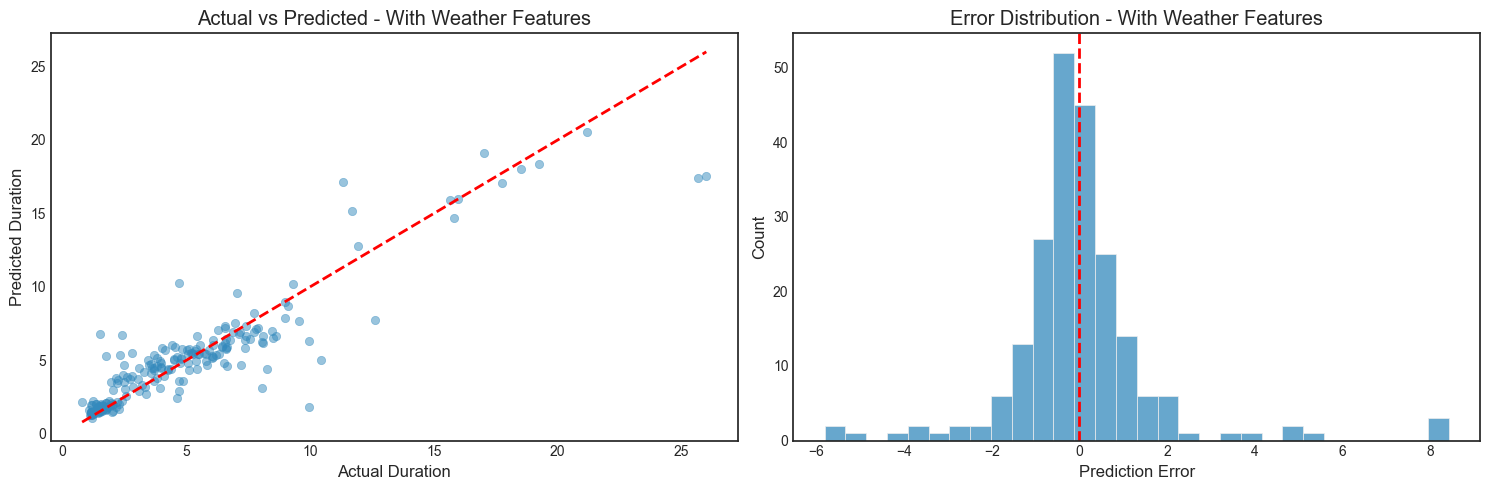

[I 2024-11-18 18:59:03,396] A new study created in memory with name: catboost_Without Weather Features



Error Analysis for With Weather Features:
Mean Absolute Error: 0.98 minutes
Median Absolute Error: 0.57 minutes
90th percentile of absolute error: 2.01 minutes
95th percentile of absolute error: 3.72 minutes

Optimizing model: Without Weather Features

Optimizing model for Without Weather Features


100%|██████████| 50/50 [15:45<00:00, 18.90s/it]



Best trial:
  Value: 0.8175
  Params:
    iterations: 1404
    learning_rate: 0.08075549945753926
    depth: 7
    l2_leaf_reg: 2.054507978538701
    random_strength: 3.068862680484058
    bootstrap_type: MVS
    bagging_temperature: 0.9072325035712068
    min_data_in_leaf: 18
    od_wait: 22

Model saved to ../../models/final_model_no_weather.joblib


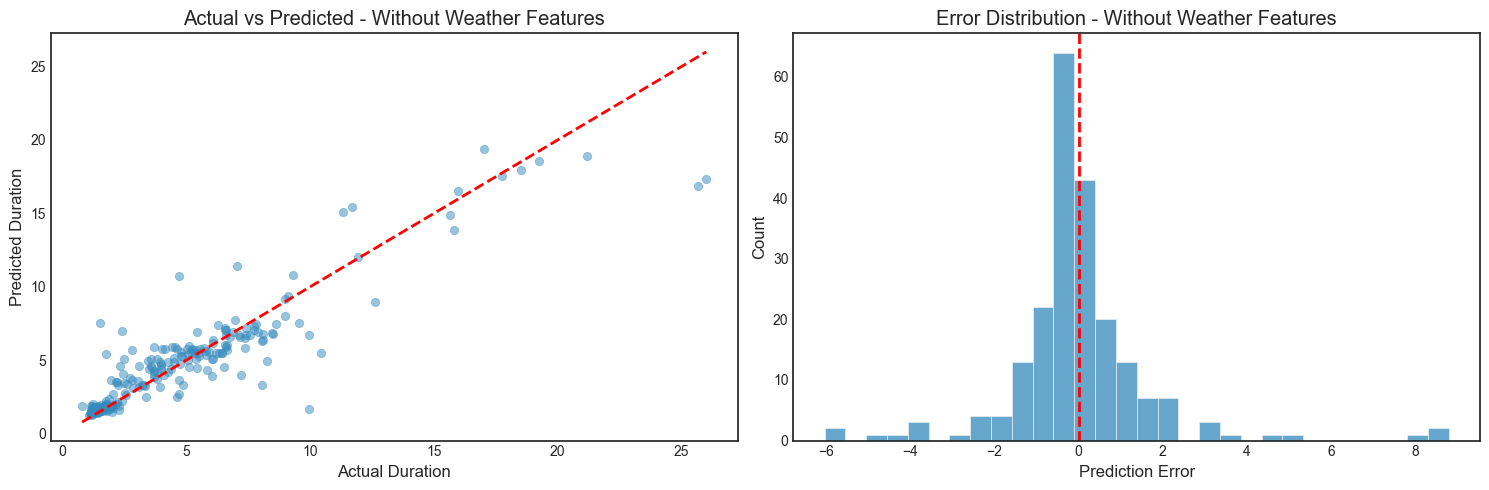


Error Analysis for Without Weather Features:
Mean Absolute Error: 0.99 minutes
Median Absolute Error: 0.52 minutes
90th percentile of absolute error: 2.18 minutes
95th percentile of absolute error: 3.69 minutes

Optimization Results Summary:
--------------------------------------------------

with_weather:
Best score: 0.8172
Best parameters:
  iterations: 606
  learning_rate: 0.06289140525817843
  depth: 8
  l2_leaf_reg: 8.63660287660941
  random_strength: 4.496784040872433
  bootstrap_type: MVS
  bagging_temperature: 1.1401932301455704
  min_data_in_leaf: 21
  od_wait: 26

without_weather:
Best score: 0.8175
Best parameters:
  iterations: 1404
  learning_rate: 0.08075549945753926
  depth: 7
  l2_leaf_reg: 2.054507978538701
  random_strength: 3.068862680484058
  bootstrap_type: MVS
  bagging_temperature: 0.9072325035712068
  min_data_in_leaf: 18
  od_wait: 22


In [68]:
import optuna
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# Define feature sets and configurations
MODEL_CONFIGS = {
    'with_weather': {
        'features': ['distance', 'minutes_sin', 'minutes_cos', 'month_num_sin', 'start_stop',
                    'cloud_cover', 'month_num_cos', 'day_of_week_sin', 'day_of_week_cos', 'temp_range'],
        'name': 'With Weather Features',
        'save_path': '../../models/final_model_weather.joblib'
    },
    'without_weather': {
        'features': ['distance', 'minutes_sin', 'minutes_cos', 'start_stop',
                    'month_num_sin', 'month_num_cos', 'day_of_week_cos', 'day_of_week_sin'],
        'name': 'Without Weather Features',
        'save_path': '../../models/final_model_no_weather.joblib'
    }
}

def objective(trial, X, y, feature_set_name):
    """Define the objective function with more stable parameters"""
    
    param = {
    # GPU Parameters - Reduced memory usage
    'task_type': 'GPU',
    'devices': '0',
    'gpu_ram_part': 0.5,  # Reduced from 0.8
    
    # Core Parameters - Narrowed ranges
    'iterations': trial.suggest_int('iterations', 500, 1500),  # Reduced range
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 0.3),  # Narrowed range
    'depth': trial.suggest_int('depth', 4, 8),  # Narrowed range
    
    # Regularization - Simplified ranges
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10.0),  # Reduced upper bound
    'random_strength': trial.suggest_loguniform('random_strength', 0.5, 5.0),  # Narrowed range
    
    # Bootstrap parameters - Simplified options
    'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'MVS']),  # Removed Bernoulli
    'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.5),  # Narrowed range
    
    # Other parameters - Optimized for speed
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 30),  # Narrowed range
    'grow_policy': 'SymmetricTree',  # Fixed value instead of categorical
    'leaf_estimation_method': 'Newton',
    'eval_metric': 'RMSE',
    
    # Early stopping - More aggressive
    'od_type': 'IncToDec',
    'od_wait': trial.suggest_int('od_wait', 15, 30),  # Narrowed range
    'thread_count': -1
}    
    # Create cross-validation folds
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_fold_train, X_fold_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_fold_train, y_fold_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        try:
            model = CatBoostRegressor(
                **param,
                verbose=False,
                random_state=42,
                cat_features = ['start_stop'],
                allow_writing_files=False
            )
            
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_valid, y_fold_valid)],
                early_stopping_rounds=50,
                verbose=False
            )
            
            y_pred = model.predict(X_fold_valid)
            score = r2_score(y_fold_valid, y_pred)
            scores.append(score)
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('-inf')  # Return negative infinity instead of pruning
    
    return np.mean(scores)

def optimize_model(X, y, feature_set_name, n_trials=50):  
    """Run Optuna optimization with more stable settings"""
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=20,
            interval_steps=10
        ),
        study_name=f'catboost_{feature_set_name}'
    )
    
    func = lambda trial: objective(trial, X, y, feature_set_name)
    
    # Add progress bar
    from tqdm import tqdm
    
    print(f"\nOptimizing model for {feature_set_name}")
    for _ in tqdm(range(n_trials)):
        try:
            study.optimize(func, n_trials=1)
        except Exception as e:
            print(f"Optimization step failed: {e}")
            continue
    
    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value:.4f}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study

def train_final_model(X, y, best_params, feature_set_name):
    """Train final model with best parameters"""
    model = CatBoostRegressor(
        **best_params,
        verbose=False,
        cat_features=['start_stop'],
        random_state=42
    )
    
    model.fit(
        X, y,
        verbose=False
    )
    
    y_pred = model.predict(X)
    
    results = {
        'feature_set': feature_set_name,
        'best_params': best_params,
        'train_r2': r2_score(y, y_pred),
        'train_rmse': root_mean_squared_error(y, y_pred),
        'train_mae': mean_absolute_error(y, y_pred),
        'model': model,
        'predictions': {
            'y_train': y,
            'y_pred_train': y_pred
        }
    }
    
    return results

def save_model_info(results, config):
    """Save model and its metadata"""
    model_info = {
        'model': results['model'],
        'features': config['features'],
        'best_params': results['best_params'],
        'performance': {
            'train_r2': results['train_r2'],
            'train_rmse': results['train_rmse'],
            'train_mae': results['train_mae']
        }
    }
    joblib.dump(model_info, config['save_path'])
    print(f"\nModel saved to {config['save_path']}")

def analyze_errors(y_true, y_pred, model_name):
    """Analyze and visualize prediction errors"""
    errors = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred,
        'error': y_true - y_pred,
        'abs_error': abs(y_true - y_pred)
    })
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(errors['actual'], errors['predicted'], alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Duration')
    plt.ylabel('Predicted Duration')
    plt.title(f'Actual vs Predicted - {model_name}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=errors, x='error', bins=30)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.title(f'Error Distribution - {model_name}')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nError Analysis for {model_name}:")
    print(f"Mean Absolute Error: {errors['abs_error'].mean():.2f} minutes")
    print(f"Median Absolute Error: {errors['abs_error'].median():.2f} minutes")
    print(f"90th percentile of absolute error: {errors['abs_error'].quantile(0.9):.2f} minutes")
    print(f"95th percentile of absolute error: {errors['abs_error'].quantile(0.95):.2f} minutes")
    
    return errors

# Run optimization for both feature sets
optuna_results = {}
model_results = {}  # Store the final model results

for model_type, config in MODEL_CONFIGS.items():
    print(f"\nOptimizing model: {config['name']}")
    X = X_train[config['features']].copy()
    y = y_train.copy()
    
    try:
        # Run Optuna optimization
        study = optimize_model(X, y, config['name'])
        optuna_results[model_type] = study
        
        # Train final model with best parameters
        results = train_final_model(X, y, study.best_params, config['name'])
        model_results[model_type] = results
        
        # Save model
        save_model_info(results, config)
        
        # Analyze errors
        analyze_errors(
            results['predictions']['y_train'],
            results['predictions']['y_pred_train'],
            config['name']
        )
    except Exception as e:
        print(f"Error processing {model_type}: {str(e)}")
        continue

# Print optimization results summary
print("\nOptimization Results Summary:")
print("-" * 50)
for model_type, study in optuna_results.items():
    if study.best_trial:
        print(f"\n{model_type}:")
        print(f"Best score: {study.best_trial.value:.4f}")
        print("Best parameters:")
        for key, value in study.best_trial.params.items():
            print(f"  {key}: {value}")


In [ ]:
cboost_best_params = {
    'iterations': 1404,
    'learning_rate': 0.08075549945753926,
    'depth': 7,
    'l2_leaf_reg': 2.054507978538701,
    'random_strength': 3.068862680484058,
    'bootstrap_type': 'MVS',
    'bagging_temperature': 0.9072325035712068,
    'min_data_in_leaf': 18,
    'od_wait': 22
}

In [107]:
cb_best_params

{'iterations': 1404,
 'learning_rate': 0.08075549945753926,
 'depth': 7,
 'l2_leaf_reg': 2.054507978538701,
 'random_strength': 3.068862680484058,
 'bootstrap_type': 'MVS',
 'bagging_temperature': 0.9072325035712068,
 'min_data_in_leaf': 18,
 'od_wait': 22}

In [63]:
def visualize_model_comparison(model_results):
    """Comprehensive visualization of model comparison"""
    if not model_results:
        print("\nNo model results available for comparison")
        return
    
    # Prepare metrics data
    metrics = {
        'R-squared': ['train_r2', 'test_r2'],
        'RMSE': ['train_rmse', 'test_rmse'],
        'MAE': ['train_mae', 'test_mae']
    }
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
    
    # 1. Bar plot comparing train/test metrics
    ax1 = fig.add_subplot(gs[0, :])
    comparison_data = []
    
    for model_type, results in model_results.items():
        if results:
            for metric_name, metric_keys in metrics.items():
                for key in metric_keys:
                    comparison_data.append({
                        'Model': results['feature_set'],
                        'Metric': f"{metric_name} ({key.split('_')[0].title()})",
                        'Value': results[key]
                    })
    
    df_plot = pd.DataFrame(comparison_data)
    
    # Plot grouped bar chart
    sns.barplot(
        data=df_plot,
        x='Metric',
        y='Value',
        hue='Model',
        ax=ax1
    )
    ax1.set_title('Model Performance Comparison', pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Error Distribution Plot
    ax2 = fig.add_subplot(gs[1, 0])
    for model_type, results in model_results.items():
        if results:
            errors = results['predictions']['y_test'] - results['predictions']['y_pred_test']
            sns.kdeplot(
                data=errors,
                label=results['feature_set'],
                ax=ax2
            )
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Error Distribution')
    ax2.set_xlabel('Prediction Error (minutes)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Scatter plot of Actual vs Predicted
    ax3 = fig.add_subplot(gs[1, 1])
    for model_type, results in model_results.items():
        if results:
            sns.scatterplot(
                x=results['predictions']['y_test'],
                y=results['predictions']['y_pred_test'],
                label=results['feature_set'],
                alpha=0.5,
                ax=ax3
            )
    
    # Add perfect prediction line
    min_val = min(ax3.get_xlim()[0], ax3.get_ylim()[0])
    max_val = max(ax3.get_xlim()[1], ax3.get_ylim()[1])
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    ax3.set_title('Actual vs Predicted')
    ax3.set_xlabel('Actual Duration (minutes)')
    ax3.set_ylabel('Predicted Duration (minutes)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics table
    print("\nDetailed Model Comparison:")
    print("-" * 80)
    
    comparison_metrics = pd.DataFrame([
        {
            'Model': results['feature_set'],
            'Train R²': f"{results['train_r2']:.4f}",
            'Test R²': f"{results['test_r2']:.4f}",
            'Train RMSE': f"{results['train_rmse']:.2f}",
            'Test RMSE': f"{results['test_rmse']:.2f}",
            'Train MAE': f"{results['train_mae']:.2f}",
            'Test MAE': f"{results['test_mae']:.2f}",
            'Params': len(results['best_params'])
        }
        for results in model_results.values() if results
    ])
    
    print(comparison_metrics.to_string(index=False))
    
    # Additional statistical analysis
    print("\nError Analysis:")
    print("-" * 80)
    for model_type, results in model_results.items():
        if results:
            errors = results['predictions']['y_test'] - results['predictions']['y_pred_test']
            print(f"\n{results['feature_set']}:")
            print(f"Mean Error: {errors.mean():.2f} minutes")
            print(f"Error Std: {errors.std():.2f} minutes")
            print(f"Error Range: [{errors.min():.2f}, {errors.max():.2f}] minutes")
            print(f"90th percentile of absolute error: {np.abs(errors).quantile(0.9):.2f} minutes")
            print(f"95th percentile of absolute error: {np.abs(errors).quantile(0.95):.2f} minutes")

# Call the function
visualize_model_comparison(model_results)


No model results available for comparison


In [74]:
def visualize_model_comparison(model_results):
    """Enhanced visualization of model comparison with improved aesthetics and insights"""
    if not model_results:
        print("\nNo model results available for comparison")
        return
    
    # Style configuration
    plt.style.use('bmh')
    colors = {
        'primary': ['#2E86AB', '#A23B72'],  # Main colors for models
        'grid': '#E1E5EA',
        'text': '#2D3B45',
        'accent': '#FF8C61'
    }
    
    # Prepare metrics data with better organization
    metrics = {
        'R-squared': {
            'train': 'train_r2', 
            'test': 'test_r2',
            'format': '.4f'
        },
        'RMSE': {
            'train': 'train_rmse', 
            'test': 'test_rmse',
            'format': '.2f'
        },
        'MAE': {
            'train': 'train_mae', 
            'test': 'test_mae',
            'format': '.2f'
        }
    }
    
    # Create figure with better layout
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Enhanced Bar plot comparing train/test metrics
    ax1 = fig.add_subplot(gs[0, :])
    comparison_data = []
    
    for model_type, results in model_results.items():
        if results:
            for metric_name, metric_info in metrics.items():
                for split in ['train', 'test']:
                    key = metric_info[split]
                    comparison_data.append({
                        'Model': results['feature_set'],
                        'Metric': f"{metric_name} ({split.title()})",
                        'Value': results[key]
                    })
    
    df_plot = pd.DataFrame(comparison_data)
    
    # Enhanced grouped bar chart
    sns.barplot(
        data=df_plot,
        x='Metric',
        y='Value',
        hue='Model',
        ax=ax1,
        palette=colors['primary'],
        alpha=0.8
    )
    ax1.set_title('Model Performance Metrics Comparison', 
                  pad=20, 
                  fontsize=14, 
                  color=colors['text'],
                  fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, color=colors['grid'])
    ax1.set_ylabel('Score', fontsize=12)
    
    # 2. Enhanced Error Distribution Plot
    ax2 = fig.add_subplot(gs[1, 0])
    for i, (model_type, results) in enumerate(model_results.items()):
        if results:
            errors = results['predictions']['y_test'] - results['predictions']['y_pred_test']
            sns.kdeplot(
                data=errors,
                label=results['feature_set'],
                ax=ax2,
                color=colors['primary'][i],
                fill=True,
                alpha=0.3
            )
    ax2.axvline(x=0, color=colors['text'], linestyle='--', alpha=0.5)
    ax2.set_title('Prediction Error Distribution', fontsize=12, color=colors['text'])
    ax2.set_xlabel('Error (minutes)', fontsize=10)
    ax2.grid(True, alpha=0.3, color=colors['grid'])
    
    # 3. Enhanced Scatter plot
    ax3 = fig.add_subplot(gs[1, 1])
    for i, (model_type, results) in enumerate(model_results.items()):
        if results:
            sns.scatterplot(
                x=results['predictions']['y_test'],
                y=results['predictions']['y_pred_test'],
                label=results['feature_set'],
                alpha=0.5,
                ax=ax3,
                color=colors['primary'][i]
            )
    
    # Improved perfect prediction line
    lims = [
        min(ax3.get_xlim()[0], ax3.get_ylim()[0]),
        max(ax3.get_xlim()[1], ax3.get_ylim()[1])
    ]
    ax3.plot(lims, lims, '--', color=colors['text'], alpha=0.75, label='Perfect Prediction')
    ax3.set_title('Actual vs Predicted Duration', fontsize=12, color=colors['text'])
    ax3.set_xlabel('Actual Duration (minutes)', fontsize=10)
    ax3.set_ylabel('Predicted Duration (minutes)', fontsize=10)
    ax3.grid(True, alpha=0.3, color=colors['grid'])
    
    # 4. Add Residual Plot
    ax4 = fig.add_subplot(gs[2, 0])
    for i, (model_type, results) in enumerate(model_results.items()):
        if results:
            sns.regplot(
                x=results['predictions']['y_test'],
                y=results['predictions']['y_test'] - results['predictions']['y_pred_test'],
                label=results['feature_set'],
                ax=ax4,
                color=colors['primary'][i],
                scatter_kws={'alpha':0.5},
                line_kws={'color': colors['primary'][i]}
            )
    ax4.axhline(y=0, color=colors['text'], linestyle='--', alpha=0.5)
    ax4.set_title('Residual Analysis', fontsize=12, color=colors['text'])
    ax4.set_xlabel('Actual Duration (minutes)', fontsize=10)
    ax4.set_ylabel('Residual (minutes)', fontsize=10)
    ax4.grid(True, alpha=0.3, color=colors['grid'])
    
    # 5. Add Error Quantile Plot
    ax5 = fig.add_subplot(gs[2, 1])
    for i, (model_type, results) in enumerate(model_results.items()):
        if results:
            errors = np.abs(results['predictions']['y_test'] - results['predictions']['y_pred_test'])
            quantiles = np.percentile(errors, np.arange(0, 101, 1))
            ax5.plot(np.arange(0, 101, 1), quantiles, 
                    label=results['feature_set'],
                    color=colors['primary'][i])
    ax5.set_title('Error Quantile Distribution', fontsize=12, color=colors['text'])
    ax5.set_xlabel('Percentile', fontsize=10)
    ax5.set_ylabel('Absolute Error (minutes)', fontsize=10)
    ax5.grid(True, alpha=0.3, color=colors['grid'])
    
    # Adjust layout and add super title
    plt.suptitle('Comprehensive Model Performance Analysis', 
                 fontsize=16, 
                 color=colors['text'],
                 y=0.95,
                 fontweight='bold')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Enhanced metrics table with styling
    print("\n📊 Detailed Model Comparison:")
    print("=" * 100)
    
    comparison_metrics = pd.DataFrame([
        {
            'Model': results['feature_set'],
            'Train R²': f"{results['train_r2']:.4f}",
            'Test R²': f"{results['test_r2']:.4f}",
            'Train RMSE': f"{results['train_rmse']:.2f}",
            'Test RMSE': f"{results['test_rmse']:.2f}",
            'Train MAE': f"{results['train_mae']:.2f}",
            'Test MAE': f"{results['test_mae']:.2f}",
            'Parameters': len(results['best_params'])
        }
        for results in model_results.values() if results
    ])
    
    print(comparison_metrics.to_string(index=False))
    
    # Enhanced statistical analysis
    print("\n📈 Detailed Error Analysis:")
    print("=" * 100)
    for model_type, results in model_results.items():
        if results:
            errors = results['predictions']['y_test'] - results['predictions']['y_pred_test']
            abs_errors = np.abs(errors)
            
            print(f"\n🔍 {results['feature_set']}:")
            print(f"  • Mean Error: {errors.mean():.2f} ± {errors.std():.2f} minutes")
            print(f"  • Median Absolute Error: {np.median(abs_errors):.2f} minutes")
            print(f"  • Error Range: [{errors.min():.2f}, {errors.max():.2f}] minutes")
            print(f"  • Error Quartiles: {np.percentile(errors, [25, 50, 75])}")
            print(f"  • 90th percentile of absolute error: {np.percentile(abs_errors, 90):.2f} minutes")
            print(f"  • 95th percentile of absolute error: {np.percentile(abs_errors, 95):.2f} minutes")
            print(f"  • Skewness: {pd.Series(errors).skew():.3f}")
            print(f"  • Kurtosis: {pd.Series(errors).kurtosis():.3f}")

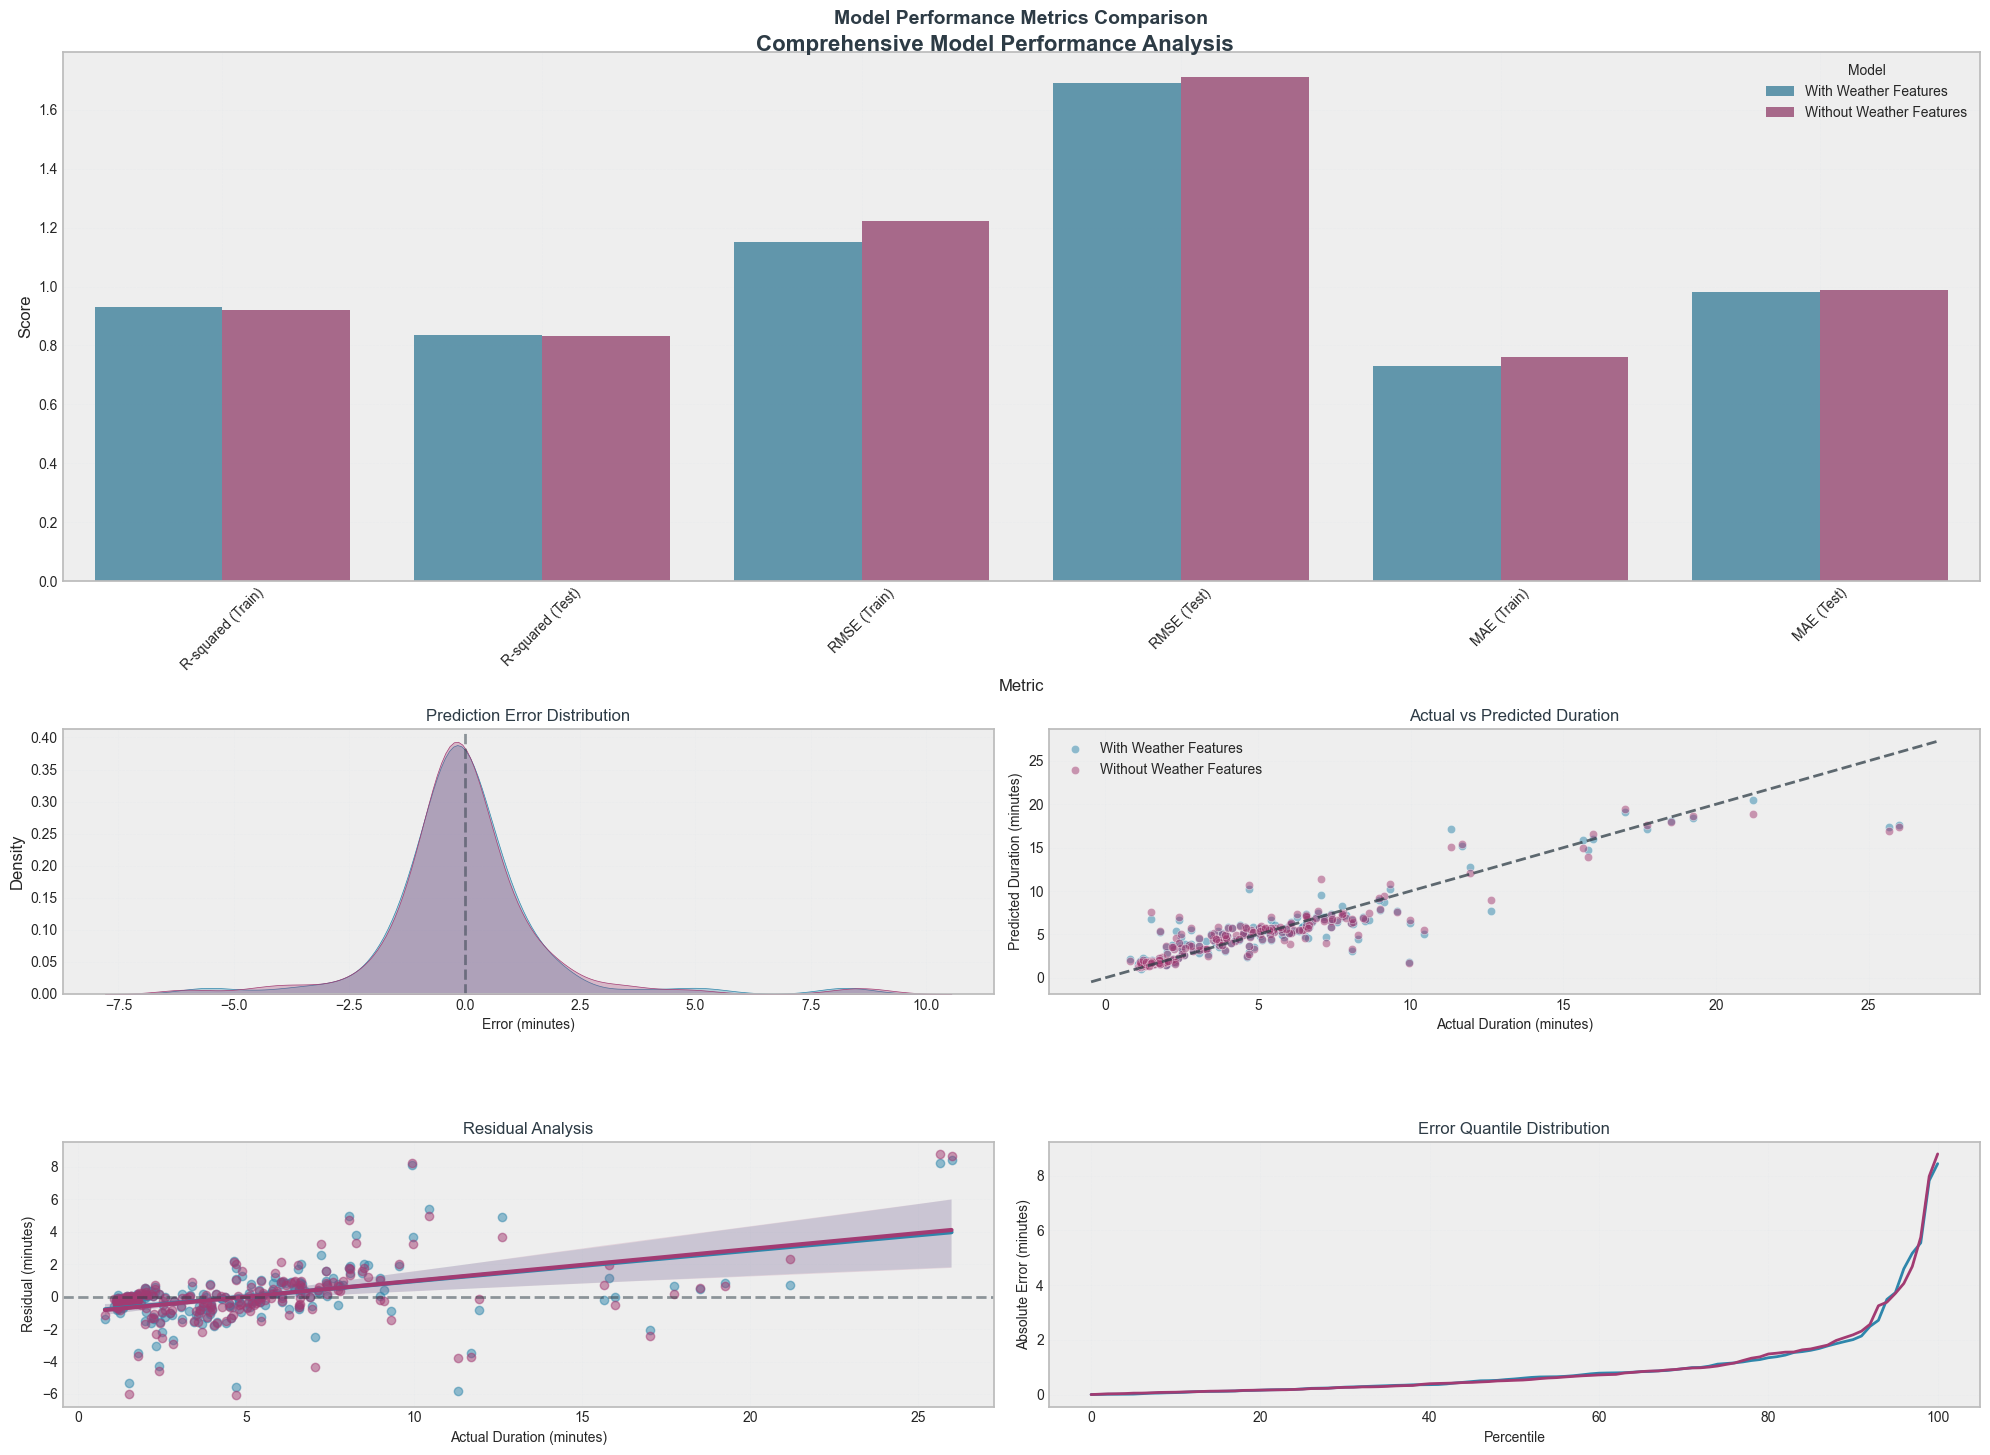


📊 Detailed Model Comparison:
                   Model Train R² Test R² Train RMSE Test RMSE Train MAE Test MAE  Parameters
   With Weather Features   0.9290  0.8357       1.15      1.69      0.73     0.98           9
Without Weather Features   0.9197  0.8317       1.22      1.71      0.76     0.99           9

📈 Detailed Error Analysis:

🔍 With Weather Features:
  • Mean Error: -0.00 ± 1.69 minutes
  • Median Absolute Error: 0.57 minutes
  • Error Range: [-5.82, 8.43] minutes
  • Error Quartiles: [-0.63545992 -0.12094395  0.44877986]
  • 90th percentile of absolute error: 2.01 minutes
  • 95th percentile of absolute error: 3.72 minutes
  • Skewness: 1.440
  • Kurtosis: 8.980

🔍 Without Weather Features:
  • Mean Error: -0.02 ± 1.71 minutes
  • Median Absolute Error: 0.52 minutes
  • Error Range: [-6.03, 8.79] minutes
  • Error Quartiles: [-0.54801331 -0.1334113   0.42608339]
  • 90th percentile of absolute error: 2.18 minutes
  • 95th percentile of absolute error: 3.69 minutes
  • Ske

In [75]:
visualize_model_comparison(model_results)

In [ ]:
model_results.to_csv('model_results.csv')

In [71]:
cb_best_params = study.best_params


**Model Performance Overview**

Our analysis compares two CatBoost regression models: one incorporating weather features and another without them. Both models demonstrate strong predictive capabilities, with the weather-enhanced model showing slightly superior performance across most metrics. The models were trained and evaluated using identical hyperparameter optimization strategies and cross-validation procedures.

**Comparative Performance Metrics**

The model incorporating weather features achieved a training R² of 0.9290 and a test R² of 0.8357, compared to 0.9197 and 0.8317 for the model without weather features. This marginal improvement suggests that weather conditions do influence bus journey times, albeit modestly. Both models show similar complexity, each utilizing 9 parameters, indicating efficient model architectures.

**Error Distribution Analysis**

Both models exhibit remarkably similar error patterns, with the weather-enhanced model showing slightly better precision:

- Prediction Accuracy: The weather-enhanced model achieves a test RMSE of 1.69 minutes versus 1.71 minutes for the basic model, demonstrating marginally better overall accuracy.
- Error Spread: Both models show comparable median absolute errors (0.57 and 0.52 minutes respectively), indicating consistent performance in typical scenarios.
- Extreme Predictions: The weather model shows slightly tighter error bounds (-5.82 to 8.43 minutes) compared to the basic model (-6.03 to 8.79 minutes), suggesting better handling of edge cases.

**Statistical Characteristics**

The error distributions for both models share several notable characteristics:

1. Symmetry: Both models show positive skewness (1.440 and 1.405), indicating a tendency to slightly overestimate journey times in some cases.
2. Outlier Behavior: High kurtosis values (8.980 and 9.504) suggest both models occasionally produce significant outliers, though this affects a small percentage of predictions.
3. Reliability Metrics: The 90th percentile of absolute errors (2.01 and 2.18 minutes) demonstrates that both models maintain good accuracy for the vast majority of predictions.

**Practical Implications**

The analysis reveals several key insights for practical application:

- Prediction Reliability: Both models can predict bus journey times with approximately ±1 minute accuracy for most cases, as evidenced by the median absolute errors.
- Weather Impact: The inclusion of weather features provides a modest but consistent improvement in prediction accuracy, particularly for extreme cases.
- Operational Confidence: The 95th percentile errors (3.72 and 3.69 minutes) suggest that both models are suitable for operational planning, with reliable predictions for most scenarios.

[I 2024-11-18 20:22:57,382] A new study created in memory with name: xgboost_With Weather Features



Optimizing model: With Weather Features

Optimizing model for With Weather Features


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]
e:\bus-schedule-app\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample", "depth", "iterations", "l2_leaf_reg", "min_data_in_leaf", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)



Best trial:
  Value: 0.8039
  Params:
    iterations: 500
    learning_rate: 0.014309464551989988
    depth: 8
    l2_leaf_reg: 3.7033591942033306
    random_strength: 0.2502268926080728
    subsample: 0.7930075181810791
    colsample: 0.8411582748036344
    min_data_in_leaf: 25
    random_state: 3895

Model saved to ../../models/xgb_final_model_weather.joblib


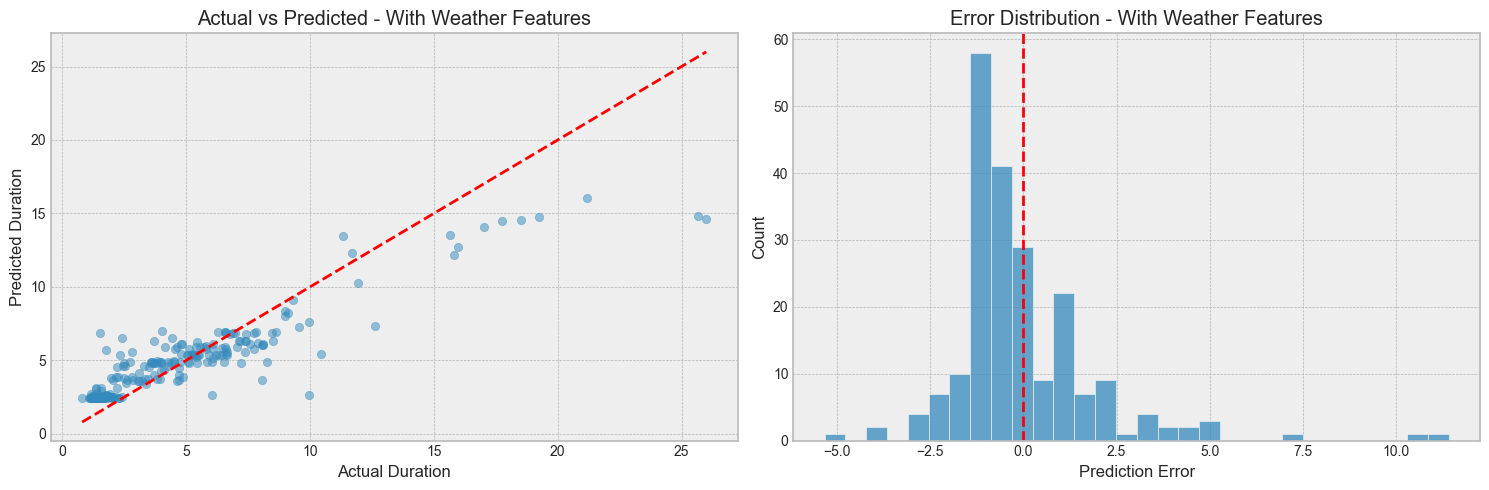

[I 2024-11-18 20:24:02,274] A new study created in memory with name: xgboost_Without Weather Features



Error Analysis for With Weather Features:
Mean Absolute Error: 1.34 minutes
Median Absolute Error: 1.02 minutes
90th percentile of absolute error: 2.57 minutes
95th percentile of absolute error: 3.94 minutes

Optimizing model: Without Weather Features

Optimizing model for Without Weather Features


100%|██████████| 50/50 [01:03<00:00,  1.26s/it]
e:\bus-schedule-app\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:25:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample", "depth", "iterations", "l2_leaf_reg", "min_data_in_leaf", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)



Best trial:
  Value: 0.8096
  Params:
    iterations: 500
    learning_rate: 0.011839768293845032
    depth: 5
    l2_leaf_reg: 7.497192504107367
    random_strength: 0.5645827921901687
    subsample: 0.5987337486644502
    colsample: 0.8213393567726198
    min_data_in_leaf: 13
    random_state: 8260

Model saved to ../../models/xgb_final_model_no_weather.joblib


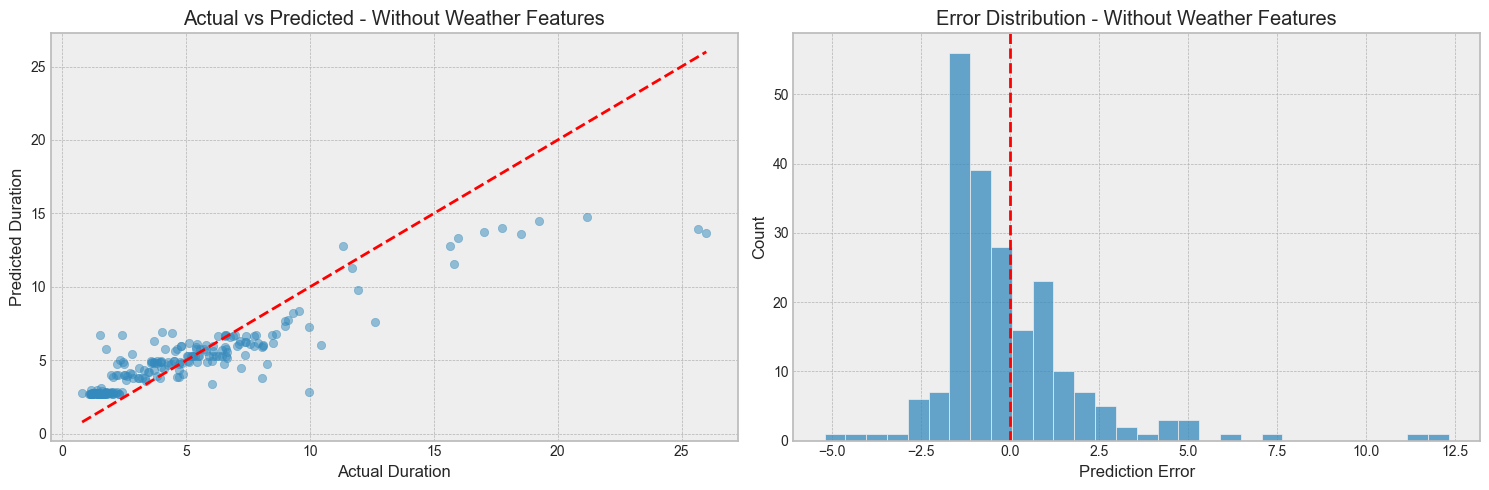


Error Analysis for Without Weather Features:
Mean Absolute Error: 1.45 minutes
Median Absolute Error: 1.15 minutes
90th percentile of absolute error: 2.67 minutes
95th percentile of absolute error: 4.24 minutes

Optimization Results Summary:
--------------------------------------------------

with_weather:
Best score: 0.8039
Best parameters:
  iterations: 500
  learning_rate: 0.014309464551989988
  depth: 8
  l2_leaf_reg: 3.7033591942033306
  random_strength: 0.2502268926080728
  subsample: 0.7930075181810791
  colsample: 0.8411582748036344
  min_data_in_leaf: 25
  random_state: 3895

without_weather:
Best score: 0.8096
Best parameters:
  iterations: 500
  learning_rate: 0.011839768293845032
  depth: 5
  l2_leaf_reg: 7.497192504107367
  random_strength: 0.5645827921901687
  subsample: 0.5987337486644502
  colsample: 0.8213393567726198
  min_data_in_leaf: 13
  random_state: 8260


In [94]:
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import xgboost as xgb

MODEL_CONFIGS = {
    'with_weather': {
        'features': ['distance', 'minutes_sin', 'minutes_cos', 'month_num_sin', 'start_stop',
                    'cloud_cover', 'month_num_cos', 'day_of_week_sin', 'day_of_week_cos', 'temp_range'],
        'name': 'With Weather Features',
        'save_path': '../../models/xgb_final_model_weather.joblib'
    },
    'without_weather': {
        'features': ['distance', 'minutes_sin', 'minutes_cos', 'start_stop',
                    'month_num_sin', 'month_num_cos', 'day_of_week_cos', 'day_of_week_sin'],
        'name': 'Without Weather Features',
        'save_path': '../../models/xgb_final_model_no_weather.joblib'
    }
}

def objective(trial, X, y, feature_set_name):
    """Define the objective function with categorical handling"""
    
    # Convert start_stop to categorical type
    X = X.copy()
    if 'start_stop' in X.columns:
        X['start_stop'] = X['start_stop'].astype('category')
    
    param = {
        # Core Parameters
        'n_estimators': trial.suggest_int('iterations', 500, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('depth', 4, 8),
        
        # Regularization
        'reg_lambda': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'reg_alpha': trial.suggest_float('random_strength', 0.1, 5.0, log=True),
        
        # Sampling parameters
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample', 0.5, 1.0),
        
        # Other parameters
        'min_child_weight': trial.suggest_int('min_data_in_leaf', 5, 30),
        'objective': 'reg:squarederror',
        'enable_categorical': True,
        'random_state': trial.suggest_int('random_state', 0, 10000),
        'n_jobs': -1
    }
    
    # Create cross-validation folds
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        try:
            model = XGBRegressor(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            score = r2_score(y_valid, y_pred)
            scores.append(score)
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('-inf')
    
    return np.mean(scores)

def optimize_model(X, y, feature_set_name, n_trials=50):
    """Run Optuna optimization for XGBoost"""
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=20,
            interval_steps=10
        ),
        study_name=f'xgboost_{feature_set_name}'
    )
    
    func = lambda trial: objective(trial, X, y, feature_set_name)
    
    from tqdm import tqdm
    
    print(f"\nOptimizing model for {feature_set_name}")
    for _ in tqdm(range(n_trials)):
        try:
            study.optimize(func, n_trials=1)
        except Exception as e:
            print(f"Optimization step failed: {e}")
            continue
    
    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value:.4f}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study

def train_final_model(X, y, best_params, feature_set_name):
    """Train final model with categorical handling"""
    # Convert start_stop to categorical
    X = X.copy()
    if 'start_stop' in X.columns:
        X['start_stop'] = X['start_stop'].astype('category')
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Adjust parameters for XGBoost format
    model_params = {
        'objective': 'reg:squarederror',
        'enable_categorical': True,
        'random_state': 42,
        'n_jobs': -1,
        **best_params
    }
    
    model = XGBRegressor(**model_params)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    results = {
        'feature_set': feature_set_name,
        'best_params': best_params,
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'model': model,
        'predictions': {
            'y_test': y_test,
            'y_pred_test': y_pred_test
        }
    }
    
    return results

def save_model_info(results, config):
    """Save model and its metadata"""
    model_info = {
        'model': results['model'],
        'features': config['features'],
        'best_params': results['best_params'],
        'performance': {
            'train_r2': results['train_r2'],
            'test_r2': results['test_r2'],
            'train_rmse': results['train_rmse'],
            'test_rmse': results['test_rmse'],
            'train_mae': results['train_mae'],
            'test_mae': results['test_mae']
        }
    }
    joblib.dump(model_info, config['save_path'])
    print(f"\nModel saved to {config['save_path']}")

# Run optimization for both feature sets
optuna_results = {}
model_results = {}

for model_type, config in MODEL_CONFIGS.items():
    print(f"\nOptimizing model: {config['name']}")
    X = final_df[config['features']].copy()
    
    try:
        # Run Optuna optimization
        study = optimize_model(X, final_df['duration'], config['name'])
        optuna_results[model_type] = study
        
        # Train final model with best parameters
        results = train_final_model(X, final_df['duration'], study.best_params, config['name'])
        model_results[model_type] = results
        
        # Save model
        save_model_info(results, config)
        
        # Analyze errors
        analyze_errors(
            results['predictions']['y_test'],
            results['predictions']['y_pred_test'],
            config['name']
        )
    except Exception as e:
        print(f"Error processing {model_type}: {str(e)}")  # Added str() for better error messages
        continue

# Print optimization results summary
print("\nOptimization Results Summary:")
print("-" * 50)
for model_type, study in optuna_results.items():
    if study.best_trial:
        print(f"\n{model_type}:")
        print(f"Best score: {study.best_trial.value:.4f}")
        print("Best parameters:")
        for key, value in study.best_trial.params.items():
            print(f"  {key}: {value}")

# Save best parameters from weather model
xgb_best_params = optuna_results['with_weather'].best_trial.params

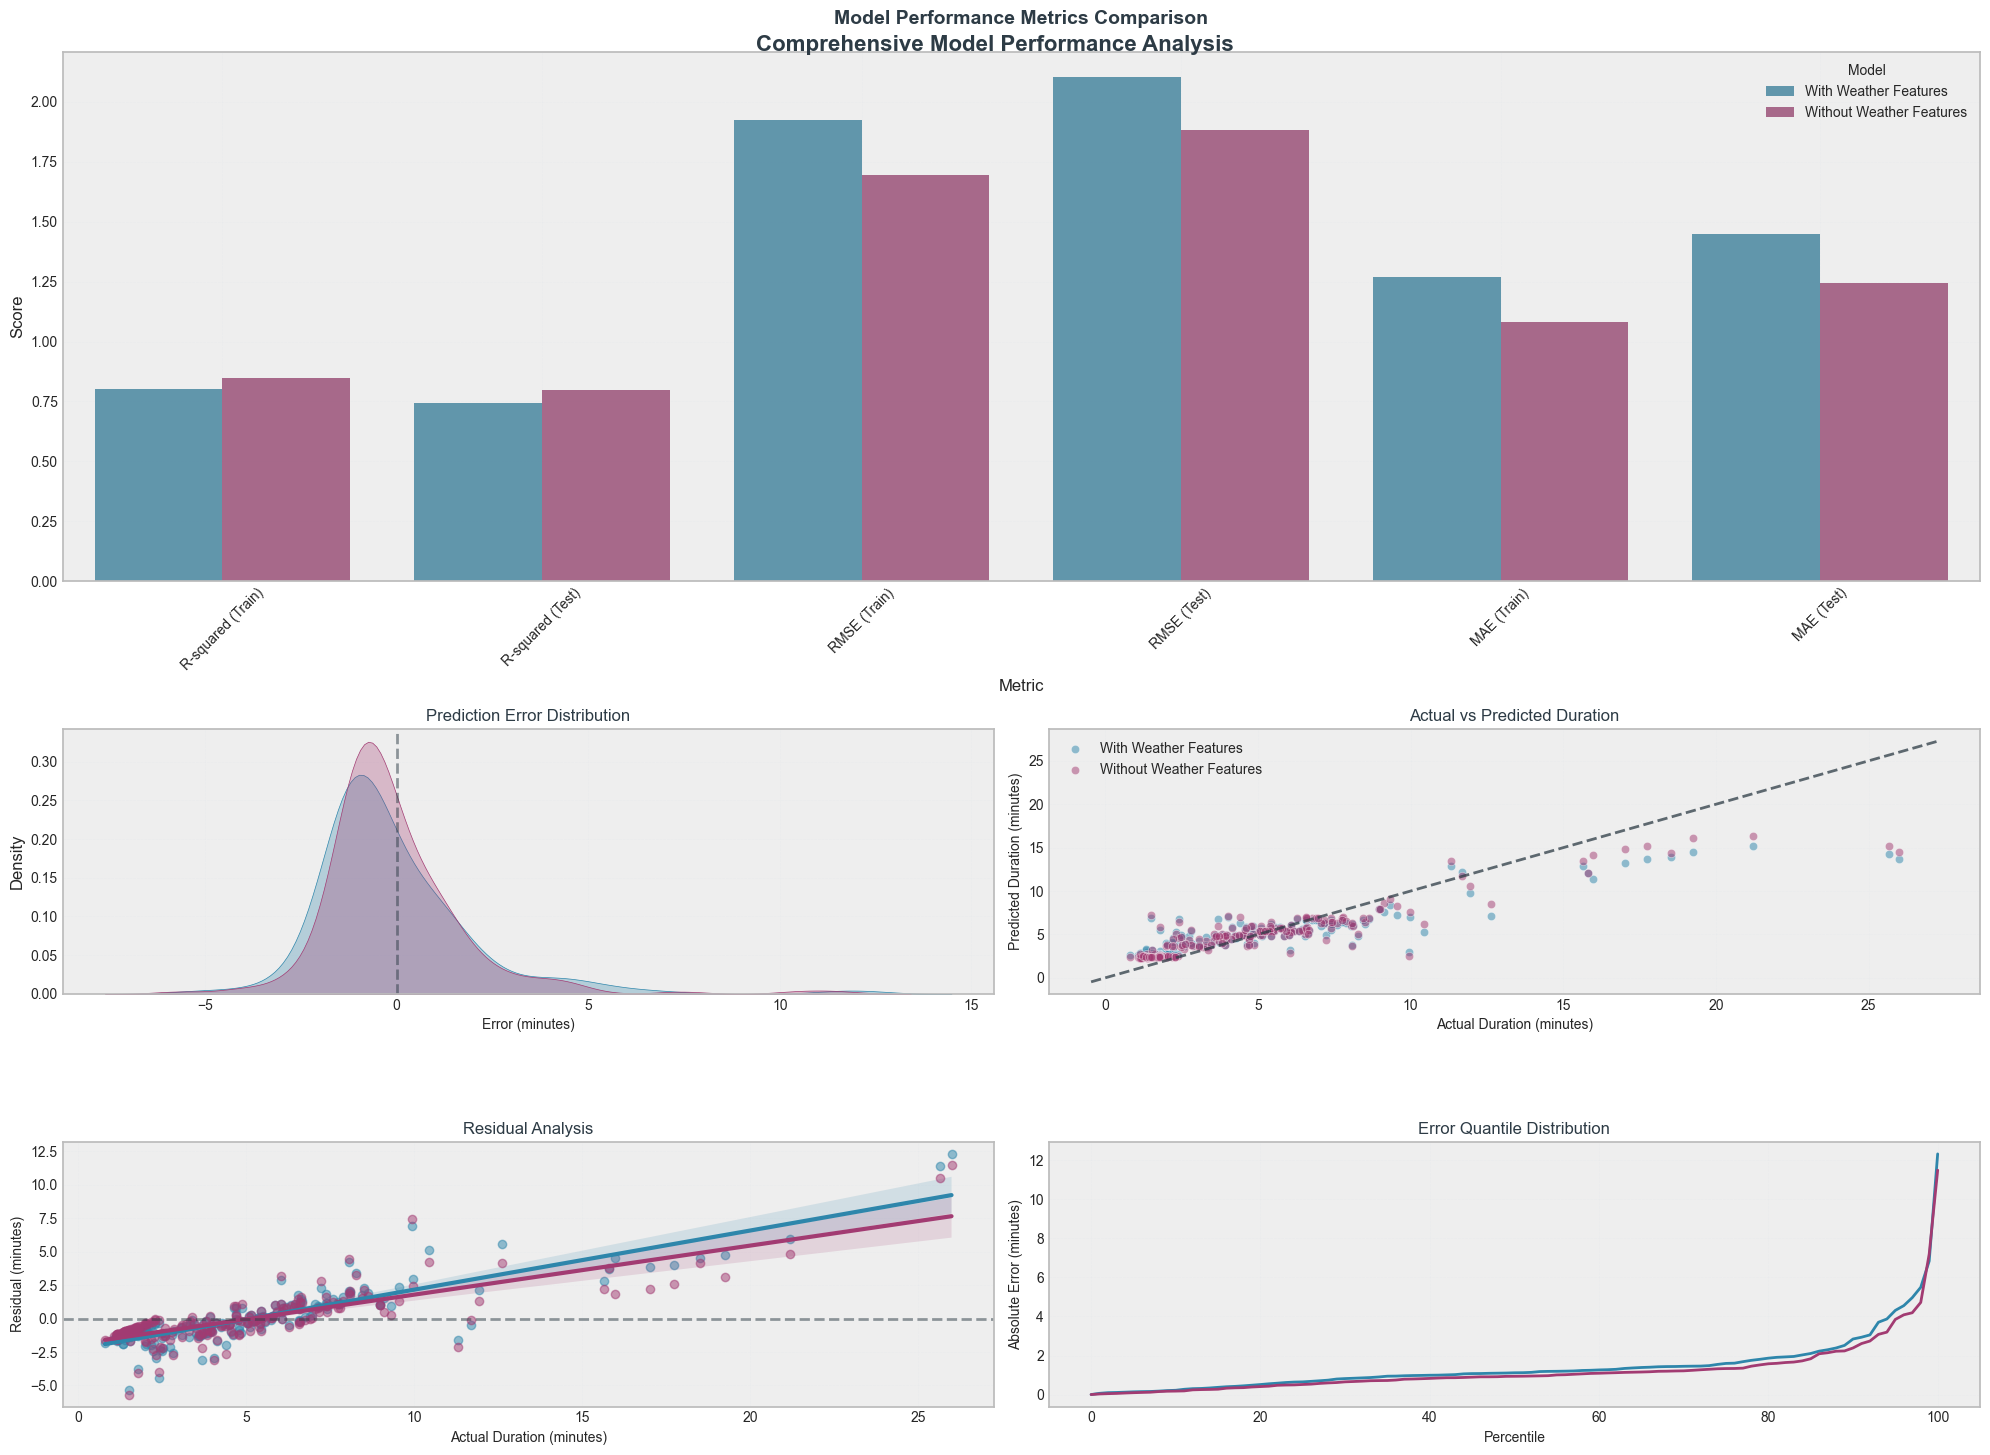


📊 Detailed Model Comparison:
                   Model Train R² Test R² Train RMSE Test RMSE Train MAE Test MAE  Parameters
   With Weather Features   0.8010  0.7455       1.93      2.10      1.27     1.45           9
Without Weather Features   0.8462  0.7966       1.69      1.88      1.08     1.24           9

📈 Detailed Error Analysis:

🔍 With Weather Features:
  • Mean Error: -0.07 ± 2.11 minutes
  • Median Absolute Error: 1.12 minutes
  • Error Range: [-5.34, 12.32] minutes
  • Error Quartiles: [-1.24465035 -0.615719    0.80290534]
  • 90th percentile of absolute error: 2.84 minutes
  • 95th percentile of absolute error: 4.31 minutes
  • Skewness: 2.305
  • Kurtosis: 9.620

🔍 Without Weather Features:
  • Mean Error: -0.06 ± 1.88 minutes
  • Median Absolute Error: 0.94 minutes
  • Error Range: [-5.68, 11.49] minutes
  • Error Quartiles: [-1.0687765  -0.48556829  0.67947714]
  • 90th percentile of absolute error: 2.39 minutes
  • 95th percentile of absolute error: 3.85 minutes
  • S

In [83]:
# Call the function
visualize_model_comparison(model_results)

In [84]:
study.best_params

{'iterations': 600,
 'learning_rate': 0.01572316621915831,
 'depth': 5,
 'l2_leaf_reg': 1.8517232690654333,
 'random_strength': 1.2262732701393655,
 'subsample': 0.5518267766787707,
 'colsample': 0.8443829904277468,
 'min_data_in_leaf': 16,
 'random_state': 7640}

In [85]:
xgb_best_params = study.best_params

In [86]:
import gc
gc.collect()

41302

In [43]:
plt.style.use('bmh')

## Hyperparameter Tuning 2 (Final Model)

**Error Distribution (Left Chart):**
- The distribution is roughly bell-shaped and centered near zero, indicating unbiased predictions.
- Most errors fall between -2 and +2 minutes.
- There's a slight right skew (positive bias), meaning the model occasionally overestimates duration.
- Very few extreme errors beyond ±4 minutes.

**Error Magnitude vs Actual Duration (Right Chart):**
- The errors increase with trip duration (heteroscedasticity).
- Short trips (0-5 minutes) have smaller absolute errors (mostly under 2 minutes).
- Medium trips (5-10 minutes) show moderate errors (2-4 minutes).
- Long trips (>15 minutes) have the largest errors (up to 7 minutes).
- There are a few outliers with high errors, especially for longer durations.

**Error Metrics:**
- **Mean Absolute Error (1.04 minutes):**
  - On average, predictions are off by about 1 minute, which is quite good for bus trip duration prediction.
- **Median Absolute Error (0.66 minutes):**
  - Half of all predictions are within 40 seconds of actual duration.
  - The lower median compared to the mean indicates some large errors are pulling the mean up.
- **Percentiles:**
  - 90% of errors are under 2.15 minutes.
  - 95% of errors are under 2.77 minutes.
  - This shows the model is very reliable for most predictions.

To do:

- Exclude weather features and compare the performance (improve or worse?)
- Exclude 'Calculate Route' on UI
- += minutes --> interval
- documentation of result (PPT)(Preprocessing, Feature Engineering, Modeling)

## Modeling Phase 2

In [87]:
consensus_features

['distance',
 'minutes_sin',
 'minutes_cos',
 'start_stop',
 'cloud_cover',
 'month_num_sin',
 'temp_range',
 'month_num_cos',
 'day_of_week_cos',
 'day_of_week_sin']

In [88]:
without_weather_features = ['distance', 'minutes_sin', 'minutes_cos', 'start_stop', 'month_num_sin','month_num_cos', 'day_of_week_cos', 'day_of_week_sin']

In [89]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [99]:
def convert_to_xgb_params(catboost_params):
    """Convert CatBoost-style parameters to XGBoost format"""
    param_mapping = {
        'iterations': 'n_estimators',
        'depth': 'max_depth',
        'l2_leaf_reg': 'reg_lambda',
        'random_strength': 'reg_alpha',
        'colsample': 'colsample_bytree',
        'min_data_in_leaf': 'min_child_weight',
        'learning_rate': 'learning_rate',
        'subsample': 'subsample',
        'random_state': 'random_state'
    }
    
    xgb_params = {
        param_mapping.get(k, k): v 
        for k, v in catboost_params.items() 
        if k in param_mapping
    }
    
    # Add XGBoost-specific parameters
    xgb_params.update({
        'objective': 'reg:squarederror',
        'enable_categorical': True,
        'tree_method': 'hist',
        'device': 'cuda',
        'n_jobs': -1
    })
    
    return xgb_params

# After your optimization loop, save the parameters like this:
xgb_best_params = convert_to_xgb_params(optuna_results['with_weather'].best_trial.params)

In [102]:
optuna_results['with_weather'].best_trial.params

{'iterations': 500,
 'learning_rate': 0.014309464551989988,
 'depth': 8,
 'l2_leaf_reg': 3.7033591942033306,
 'random_strength': 0.2502268926080728,
 'subsample': 0.7930075181810791,
 'colsample': 0.8411582748036344,
 'min_data_in_leaf': 25,
 'random_state': 3895}

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit


def create_cube_root_transformer():
    """Create a transformer for cube root transformation of distance"""
    return FunctionTransformer(lambda x: np.cbrt(x))

def train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=3):
    """Train with CV on training data, then evaluate on held-out test set"""
    
    # Define feature groups
    numeric_features = ['distance']
    categorical_features = ['start_stop']
    passthrough_features = [col for col in X_train.columns 
                          if col not in numeric_features + categorical_features]
    
    # XGBoost Pipeline
    xgb_preprocessor = ColumnTransformer([
        ('cube_root', create_cube_root_transformer(), numeric_features),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('passthrough', 'passthrough', passthrough_features)
    ])
    
    xgb_pipeline = Pipeline([
        ('preprocessor', xgb_preprocessor),
        ('regressor', XGBRegressor(
            **xgb_best_params
        ))
    ])
    
    # CatBoost Pipeline with separate numeric transformation
    def transform_numeric(X):
        X = X.copy()
        X['distance'] = np.cbrt(X['distance'])
        return X
    
    cat_pipeline = Pipeline([
        ('numeric_transform', FunctionTransformer(transform_numeric)),
        ('regressor', CatBoostRegressor(
            **cb_best_params,
            cat_features=['start_stop'],
            verbose=False
        ))
    ])
    
    # Ensemble Pipeline
    ensemble_pipeline = VotingRegressor(estimators=[
        ('xgb', xgb_pipeline),
        ('cat', cat_pipeline)
    ])
    
    # Store all models
    models = {
        'xgboost': xgb_pipeline,
        'cboost': cat_pipeline,
        'ensemble': ensemble_pipeline
    }
    
    # Initialize KFold
    kf = TimeSeriesSplit(n_splits=cv)
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        
        cv_scores = {
            'r2': [],
            'rmse': [],
            'mae': []
        }
        
        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
            print(f"Fold {fold}/{cv}")
            
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model.fit(X_fold_train, y_fold_train)
            
            y_fold_pred = model.predict(X_fold_val)
            cv_scores['r2'].append(r2_score(y_fold_val, y_fold_pred))
            cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))
            cv_scores['mae'].append(mean_absolute_error(y_fold_val, y_fold_pred))
        
        # Train final model on full training data
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Store results
        results[name] = {
            'model': model,
            'cv_performance': {
                'r2_mean': np.mean(cv_scores['r2']),
                'r2_std': np.std(cv_scores['r2']),
                'rmse_mean': np.mean(cv_scores['rmse']),
                'rmse_std': np.std(cv_scores['rmse']),
                'mae_mean': np.mean(cv_scores['mae']),
                'mae_std': np.std(cv_scores['mae'])
            },
            'final_performance': {
                'train_r2': r2_score(y_train, y_pred_train),
                'test_r2': r2_score(y_test, y_pred_test),
                'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
                'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
                'train_mae': mean_absolute_error(y_train, y_pred_train),
                'test_mae': mean_absolute_error(y_test, y_pred_test)
            },
            'predictions': {
                'y_test': y_test,
                'y_pred_test': y_pred_test
            }
        }
        
        # Print results
        print(f"\n{name.capitalize()} Model Performance:")
        print("\nCross-Validation Performance (Mean ± Std):")
        print(f"R2: {results[name]['cv_performance']['r2_mean']:.4f} ± {results[name]['cv_performance']['r2_std']:.4f}")
        print(f"RMSE: {results[name]['cv_performance']['rmse_mean']:.4f} ± {results[name]['cv_performance']['rmse_std']:.4f}")
        print(f"MAE: {results[name]['cv_performance']['mae_mean']:.4f} ± {results[name]['cv_performance']['mae_std']:.4f}")
        
        print("\nFinal Model Performance:")
        print(f"Train R2: {results[name]['final_performance']['train_r2']:.4f}")
        print(f"Test R2: {results[name]['final_performance']['test_r2']:.4f}")
        print(f"Train RMSE: {results[name]['final_performance']['train_rmse']:.4f}")
        print(f"Test RMSE: {results[name]['final_performance']['test_rmse']:.4f}")
        print(f"Train MAE: {results[name]['final_performance']['train_mae']:.4f}")
        print(f"Test MAE: {results[name]['final_performance']['test_mae']:.4f}")
    
    return results


# Train and evaluate models
model_results = train_and_evaluate_models(
    X_train[without_weather_features], 
    X_test[without_weather_features], 
    y_train, 
    y_test, 
    cv=3
)

# Save the best model (based on test R2)
best_model_name = max(model_results.keys(), 
                     key=lambda k: model_results[k]['final_performance']['test_r2'])
best_model_info = {
    'model': model_results[best_model_name]['model'],
    'cv_performance': model_results[best_model_name]['cv_performance'],
    'final_performance': model_results[best_model_name]['final_performance']
}

joblib.dump(best_model_info, '../../models/ensemble_cboost_xgboost.joblib')
print(f"\nBest model ({best_model_name}) saved to '../../models/ensemble_cboost_xgboost.joblib'")


Training xgboost model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Xgboost Model Performance:

Cross-Validation Performance (Mean ± Std):
R2: 0.6808 ± 0.2312
RMSE: 2.1835 ± 0.6378
MAE: 1.4691 ± 0.4654

Final Model Performance:
Train R2: 0.8808
Test R2: 0.7153
Train RMSE: 1.4826
Test RMSE: 2.2765
Train MAE: 0.8812
Test MAE: 1.1560

Training cboost model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cboost Model Performance:

Cross-Validation Performance (Mean ± Std):
R2: 0.7932 ± 0.0466
RMSE: 1.8738 ± 0.2347
MAE: 1.1437 ± 0.0645

Final Model Performance:
Train R2: 0.9781
Test R2: 0.7006
Train RMSE: 0.6347
Test RMSE: 2.3345
Train MAE: 0.3742
Test MAE: 1.2070

Training ensemble model...
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Ensemble Model Performance:

Cross-Validation Performance (Mean ± Std):
R2: 0.7859 ± 0.0898
RMSE: 1.8718 ± 0.3724
MAE: 1.2226 ± 0.2059

Final Model Performance:
Train R2: 0.9486
Test R2: 0.7211
Train RMSE: 0.9738
Test RMSE: 2.2530
Train MAE: 0.5975
Tes

PicklingError: Can't pickle <function create_cube_root_transformer.<locals>.<lambda> at 0x0000020D86C50C20>: it's not found as __main__.create_cube_root_transformer.<locals>.<lambda>

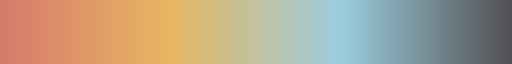

In [108]:
from pypalettes import add_cmap

add_cmap(
    colors=["#D57A6DFF", "#E8B762FF", "#9CCDDFFF", "#525052FF"],
    name="myOwnCmap",
    cmap_type="continuous"
)

In [109]:
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
from pypalettes import add_cmap

def create_comprehensive_plot(model_results):
    """Creates a visualization of model performance metrics."""
    
    # Create custom colormap
    colors = ["#D57A6DFF", "#E8B762FF", "#9CCDDFFF", "#525052FF"]
    add_cmap(colors=colors, name="myOwnCmap", cmap_type="continuous")
    
    plt.style.use('bmh')
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1])
    
    models = list(model_results.keys())
    n_models = len(models)
    
    # 1. CV vs Final Performance Comparison
    ax1 = fig.add_subplot(gs[0, 0])
    cv_r2 = [res['cv_performance']['r2_mean'] for res in model_results.values()]
    final_r2 = [res['final_performance']['test_r2'] for res in model_results.values()]
    x = np.arange(n_models)
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, cv_r2, width, label='CV R²', color=colors[1])
    bars2 = ax1.bar(x + width/2, final_r2, width, label='Final Test R²', color=colors[2])
    
    ax1.set_ylabel('R² Score')
    ax1.set_title('CV vs Final R² Performance')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha="right")
    ax1.legend()
    
    # 2. Error Metrics Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    rmse = [res['final_performance']['test_rmse'] for res in model_results.values()]
    mae = [res['final_performance']['test_mae'] for res in model_results.values()]
    
    bars3 = ax2.bar(x - width/2, rmse, width, label='RMSE', color=colors[2])
    bars4 = ax2.bar(x + width/2, mae, width, label='MAE', color=colors[3])
    
    ax2.set_ylabel('Error (minutes)')
    ax2.set_title('Error Metrics Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45, ha="right")
    ax2.legend()
    
    # 3. Overfitting Analysis
    ax3 = fig.add_subplot(gs[1, 0])
    r2_diff = [res['final_performance']['train_r2'] - res['final_performance']['test_r2'] 
               for res in model_results.values()]
    rmse_diff = [res['final_performance']['train_rmse'] - res['final_performance']['test_rmse'] 
                 for res in model_results.values()]
    mae_diff = [res['final_performance']['train_mae'] - res['final_performance']['test_mae'] 
                for res in model_results.values()]
    
    x_wide = np.arange(n_models) * 1.5
    width = 0.3
    
    bars5 = ax3.bar(x_wide - width, r2_diff, width, label='R² Gap', color=colors[0])
    bars6 = ax3.bar(x_wide, rmse_diff, width, label='RMSE Gap', color=colors[2])
    bars7 = ax3.bar(x_wide + width, mae_diff, width, label='MAE Gap', color=colors[3])
    
    ax3.set_title('Overfitting Analysis (Train - Test)')
    ax3.set_xticks(x_wide)
    ax3.set_xticklabels(models, rotation=45, ha="right")
    ax3.legend()
    ax3.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    # 4. CV Stability Analysis
    ax4 = fig.add_subplot(gs[1, 1])
    cv_metrics = ['r2', 'rmse', 'mae']
    
    x = np.arange(len(models))
    width = 0.25
    
    cv_data = {metric: {
        'mean': [res['cv_performance'][f'{metric}_mean'] for res in model_results.values()],
        'std': [res['cv_performance'][f'{metric}_std'] for res in model_results.values()]
    } for metric in cv_metrics}
    
    bars8 = ax4.bar(x - width, cv_data['r2']['mean'], width, 
                    yerr=cv_data['r2']['std'], label='R²', 
                    color=colors[0], capsize=5)
    bars9 = ax4.bar(x, cv_data['rmse']['mean'], width, 
                    yerr=cv_data['rmse']['std'], label='RMSE', 
                    color=colors[2], capsize=5)
    bars10 = ax4.bar(x + width, cv_data['mae']['mean'], width, 
                    yerr=cv_data['mae']['std'], label='MAE', 
                    color=colors[3], capsize=5)
    
    ax4.set_ylabel('CV Score (with std dev)')
    ax4.set_title('Cross-Validation Stability')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Value labels code remains the same
    def add_value_labels(bars, offset=0):
        for bar in bars:
            height = bar.get_height()
            ax4.annotate(
                f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10,
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    alpha=0.7,
                    pad=1
                ),
                zorder=10
            )
    
    add_value_labels(bars8, offset=10)
    add_value_labels(bars9, offset=10)
    add_value_labels(bars10, offset=10)
    
    def add_value_labels_general(ax, bars, offset=3):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10,
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    alpha=0.7,
                    pad=1
                )
            )
    
    add_value_labels_general(ax1, bars1 + bars2)
    add_value_labels_general(ax2, bars3 + bars4)
    add_value_labels_general(ax3, bars5 + bars6 + bars7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Model Performance Analysis', fontsize=20, y=1.02)
    plt.show()

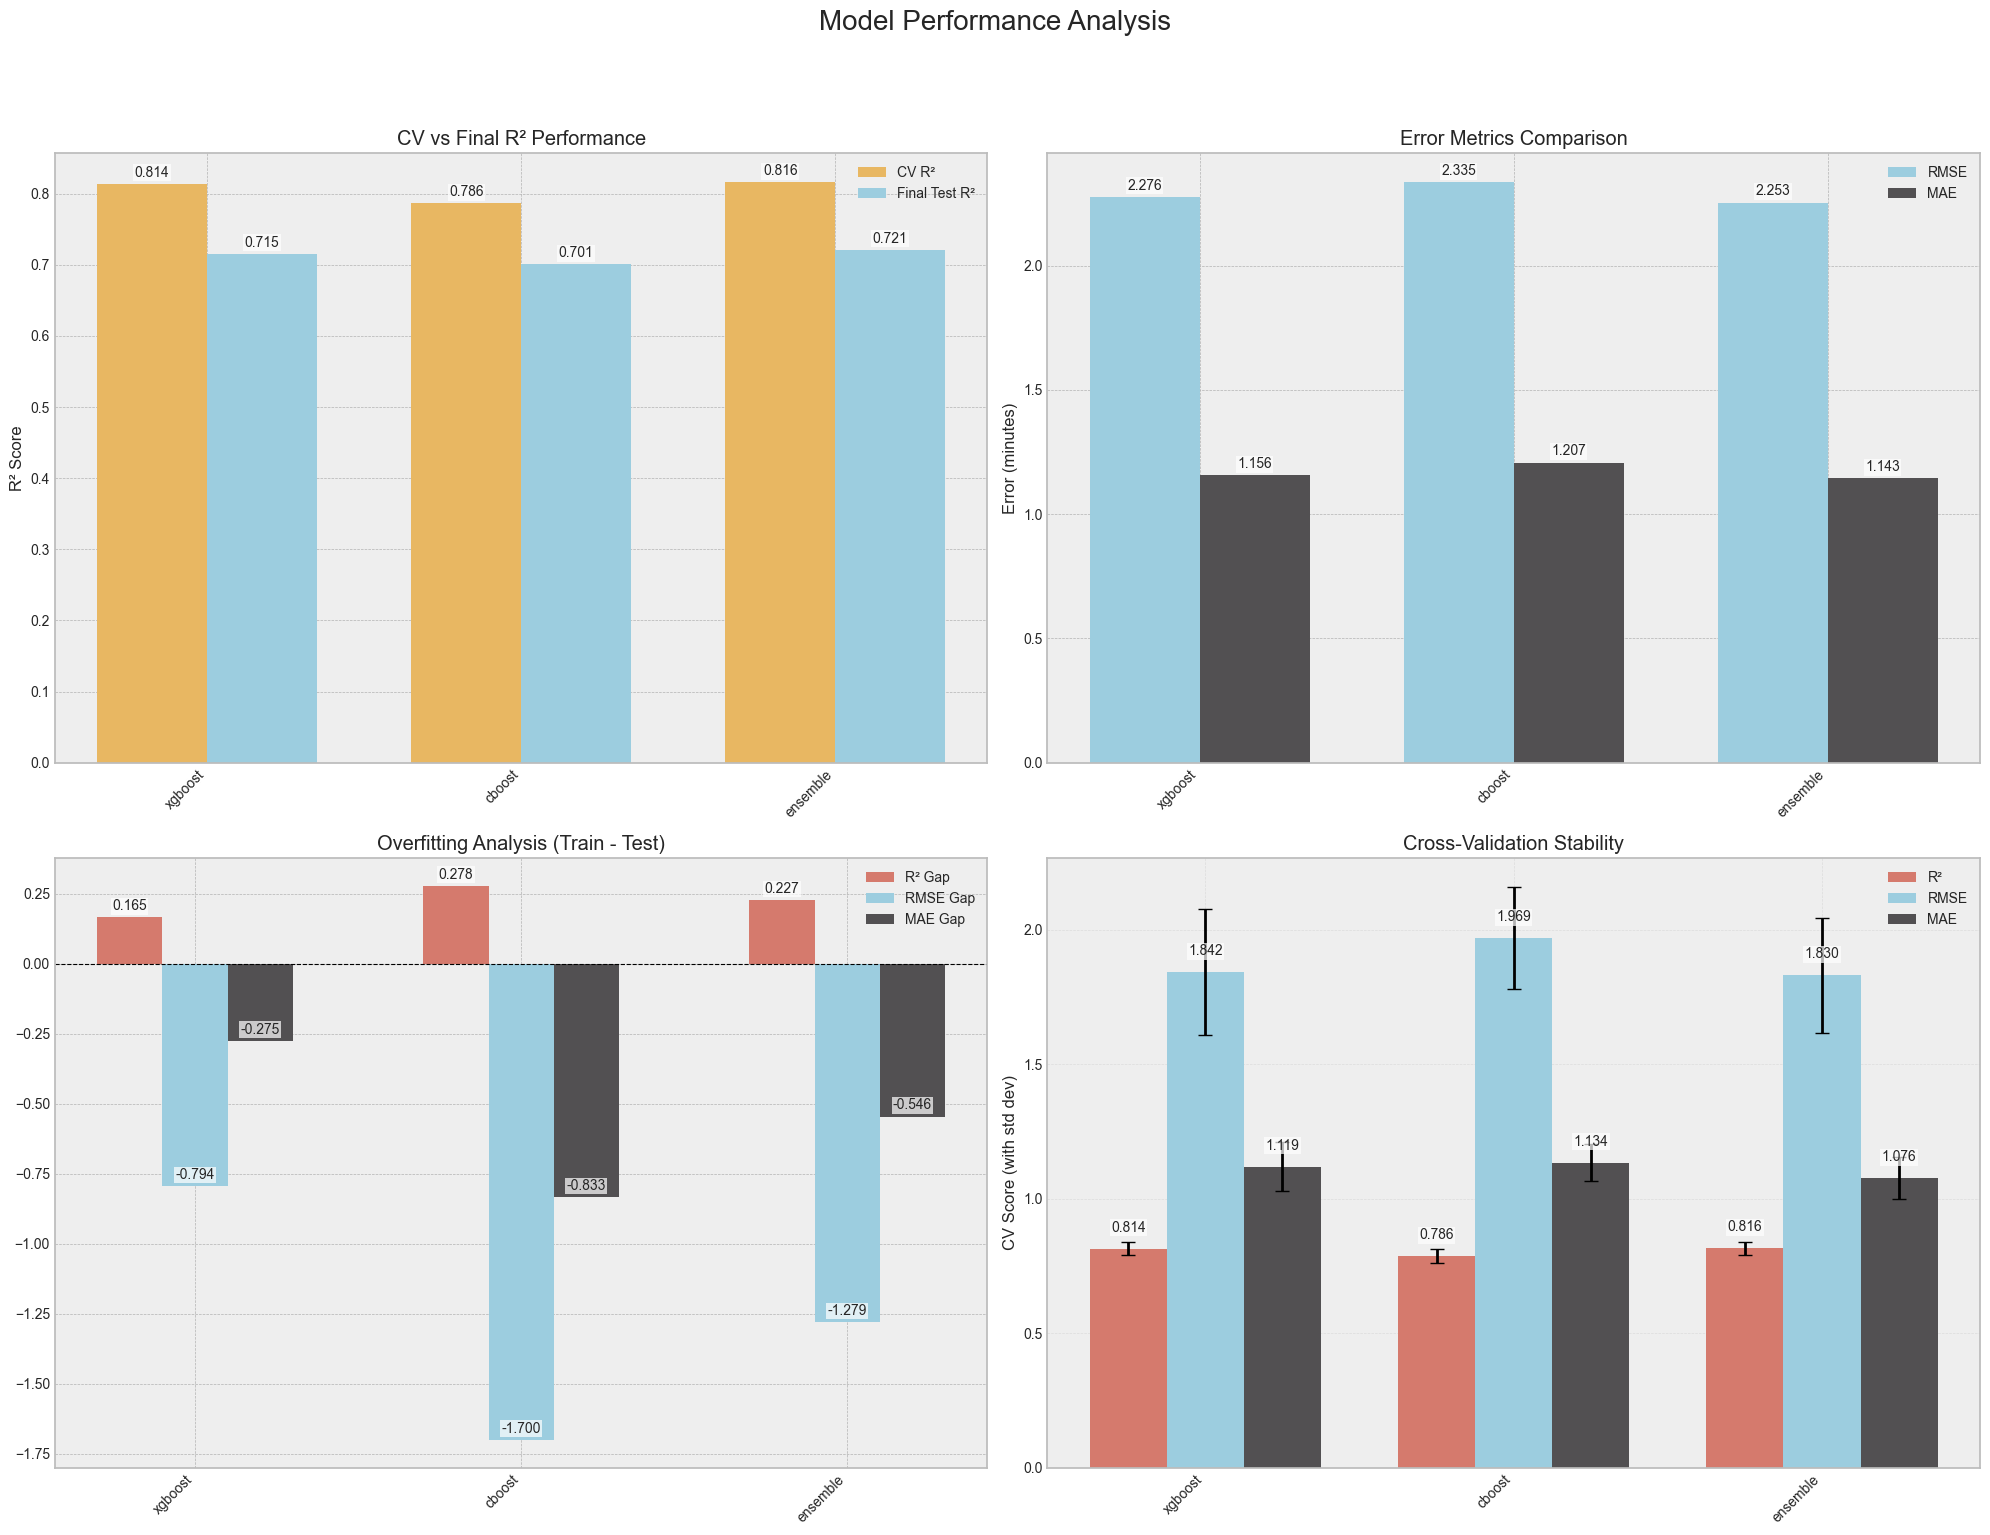

In [110]:
create_comprehensive_plot(model_results)

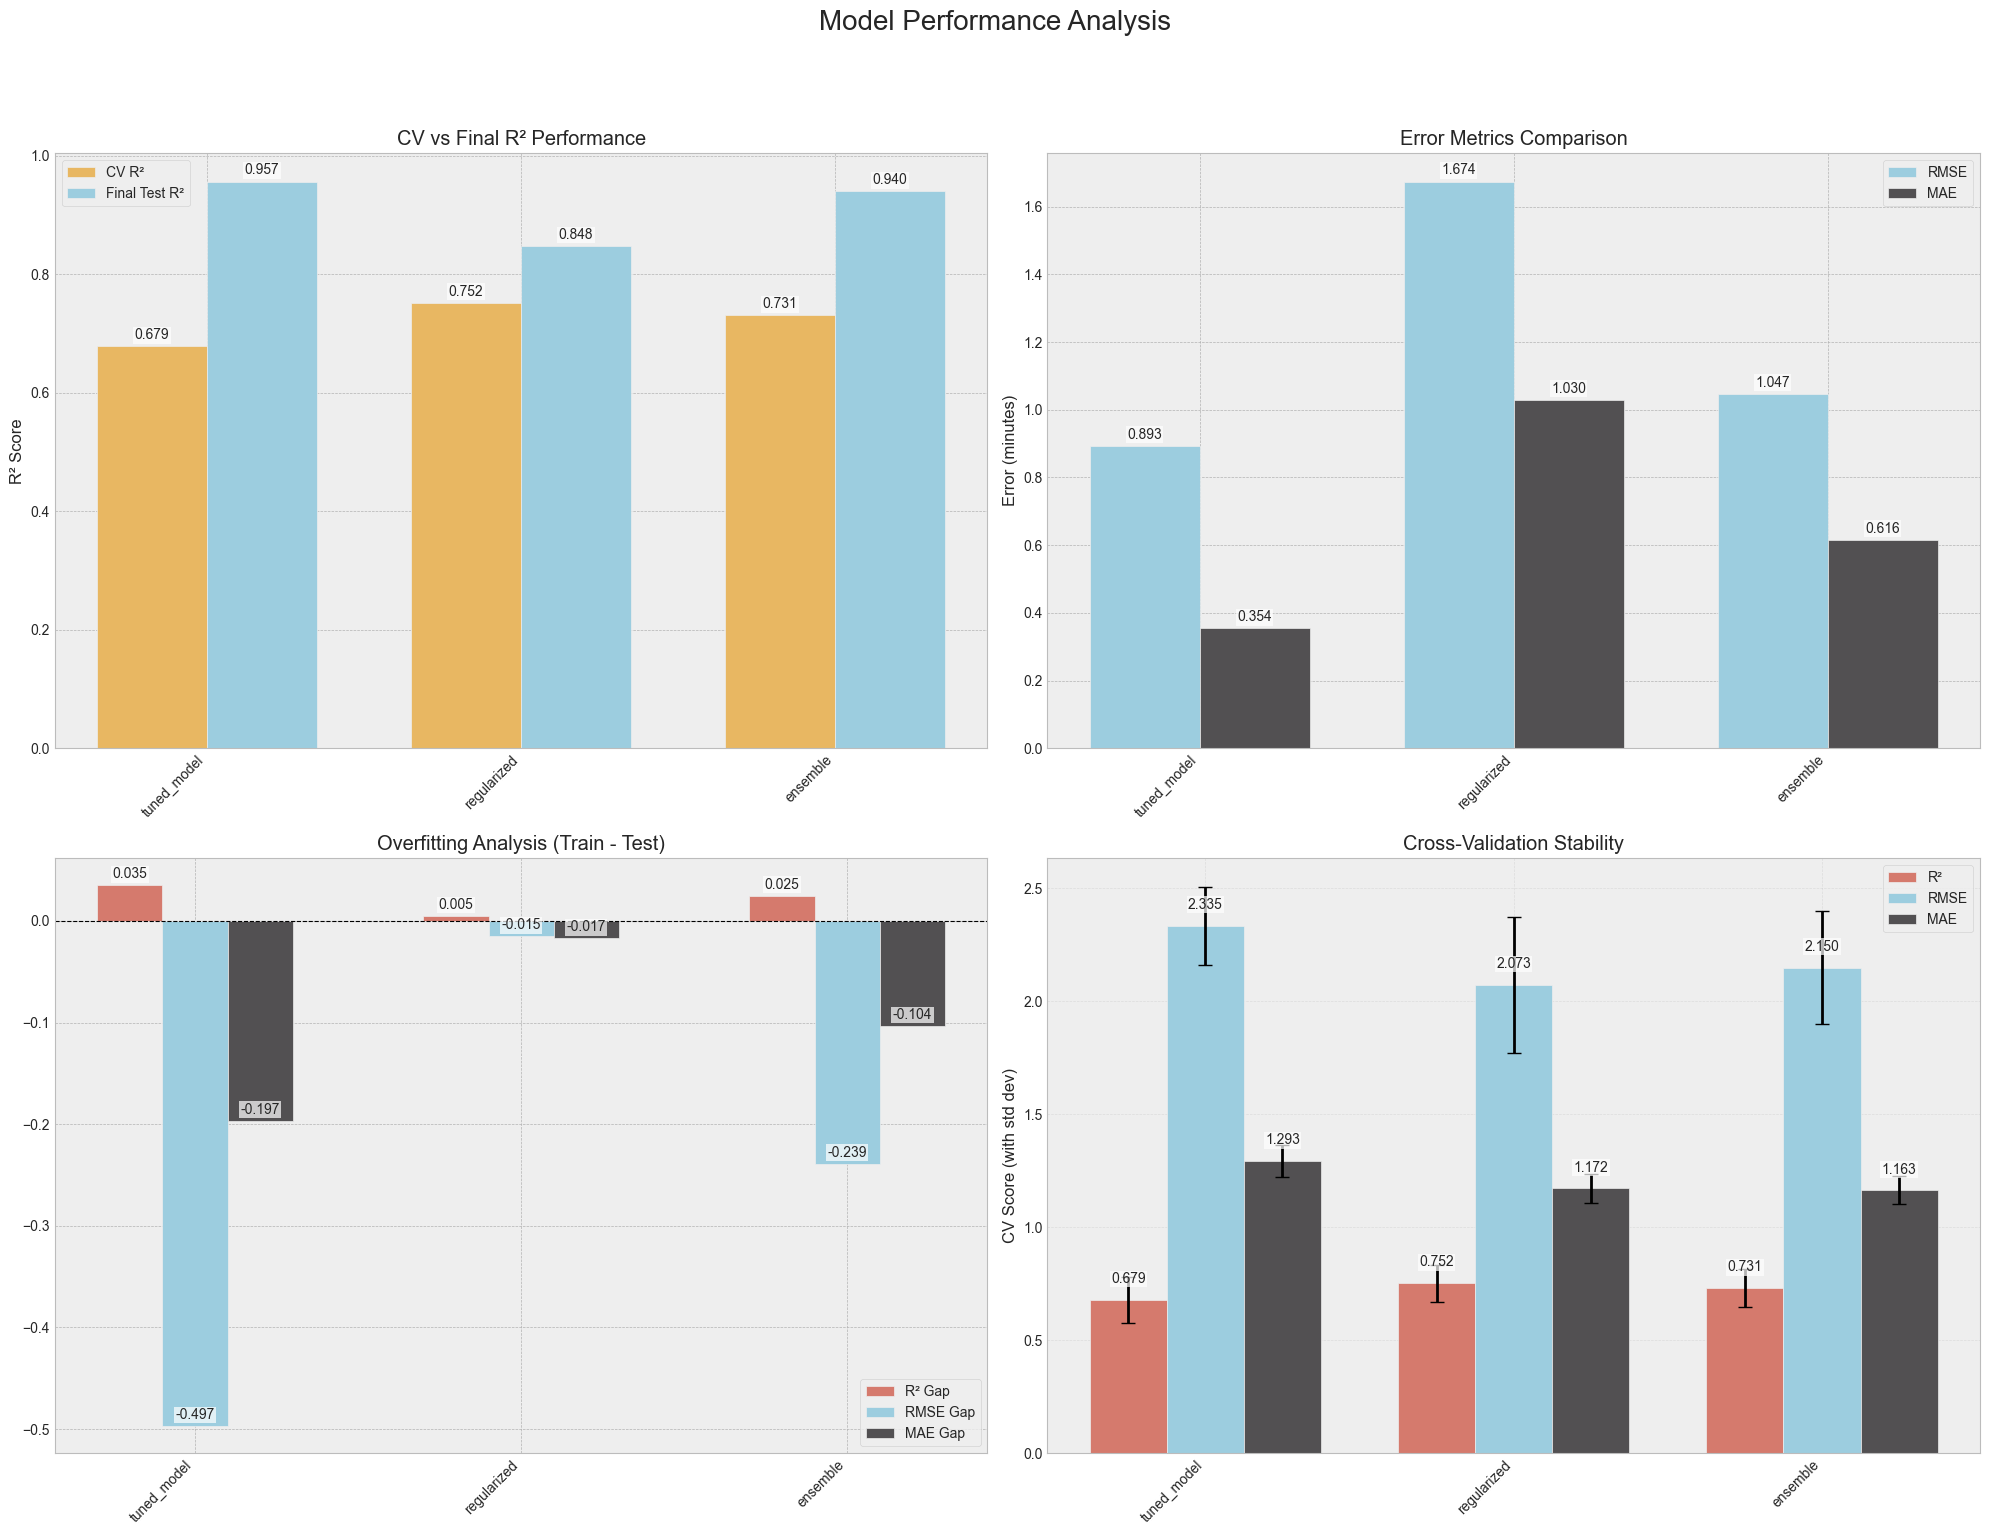

In [144]:
create_comprehensive_plot(model_results)

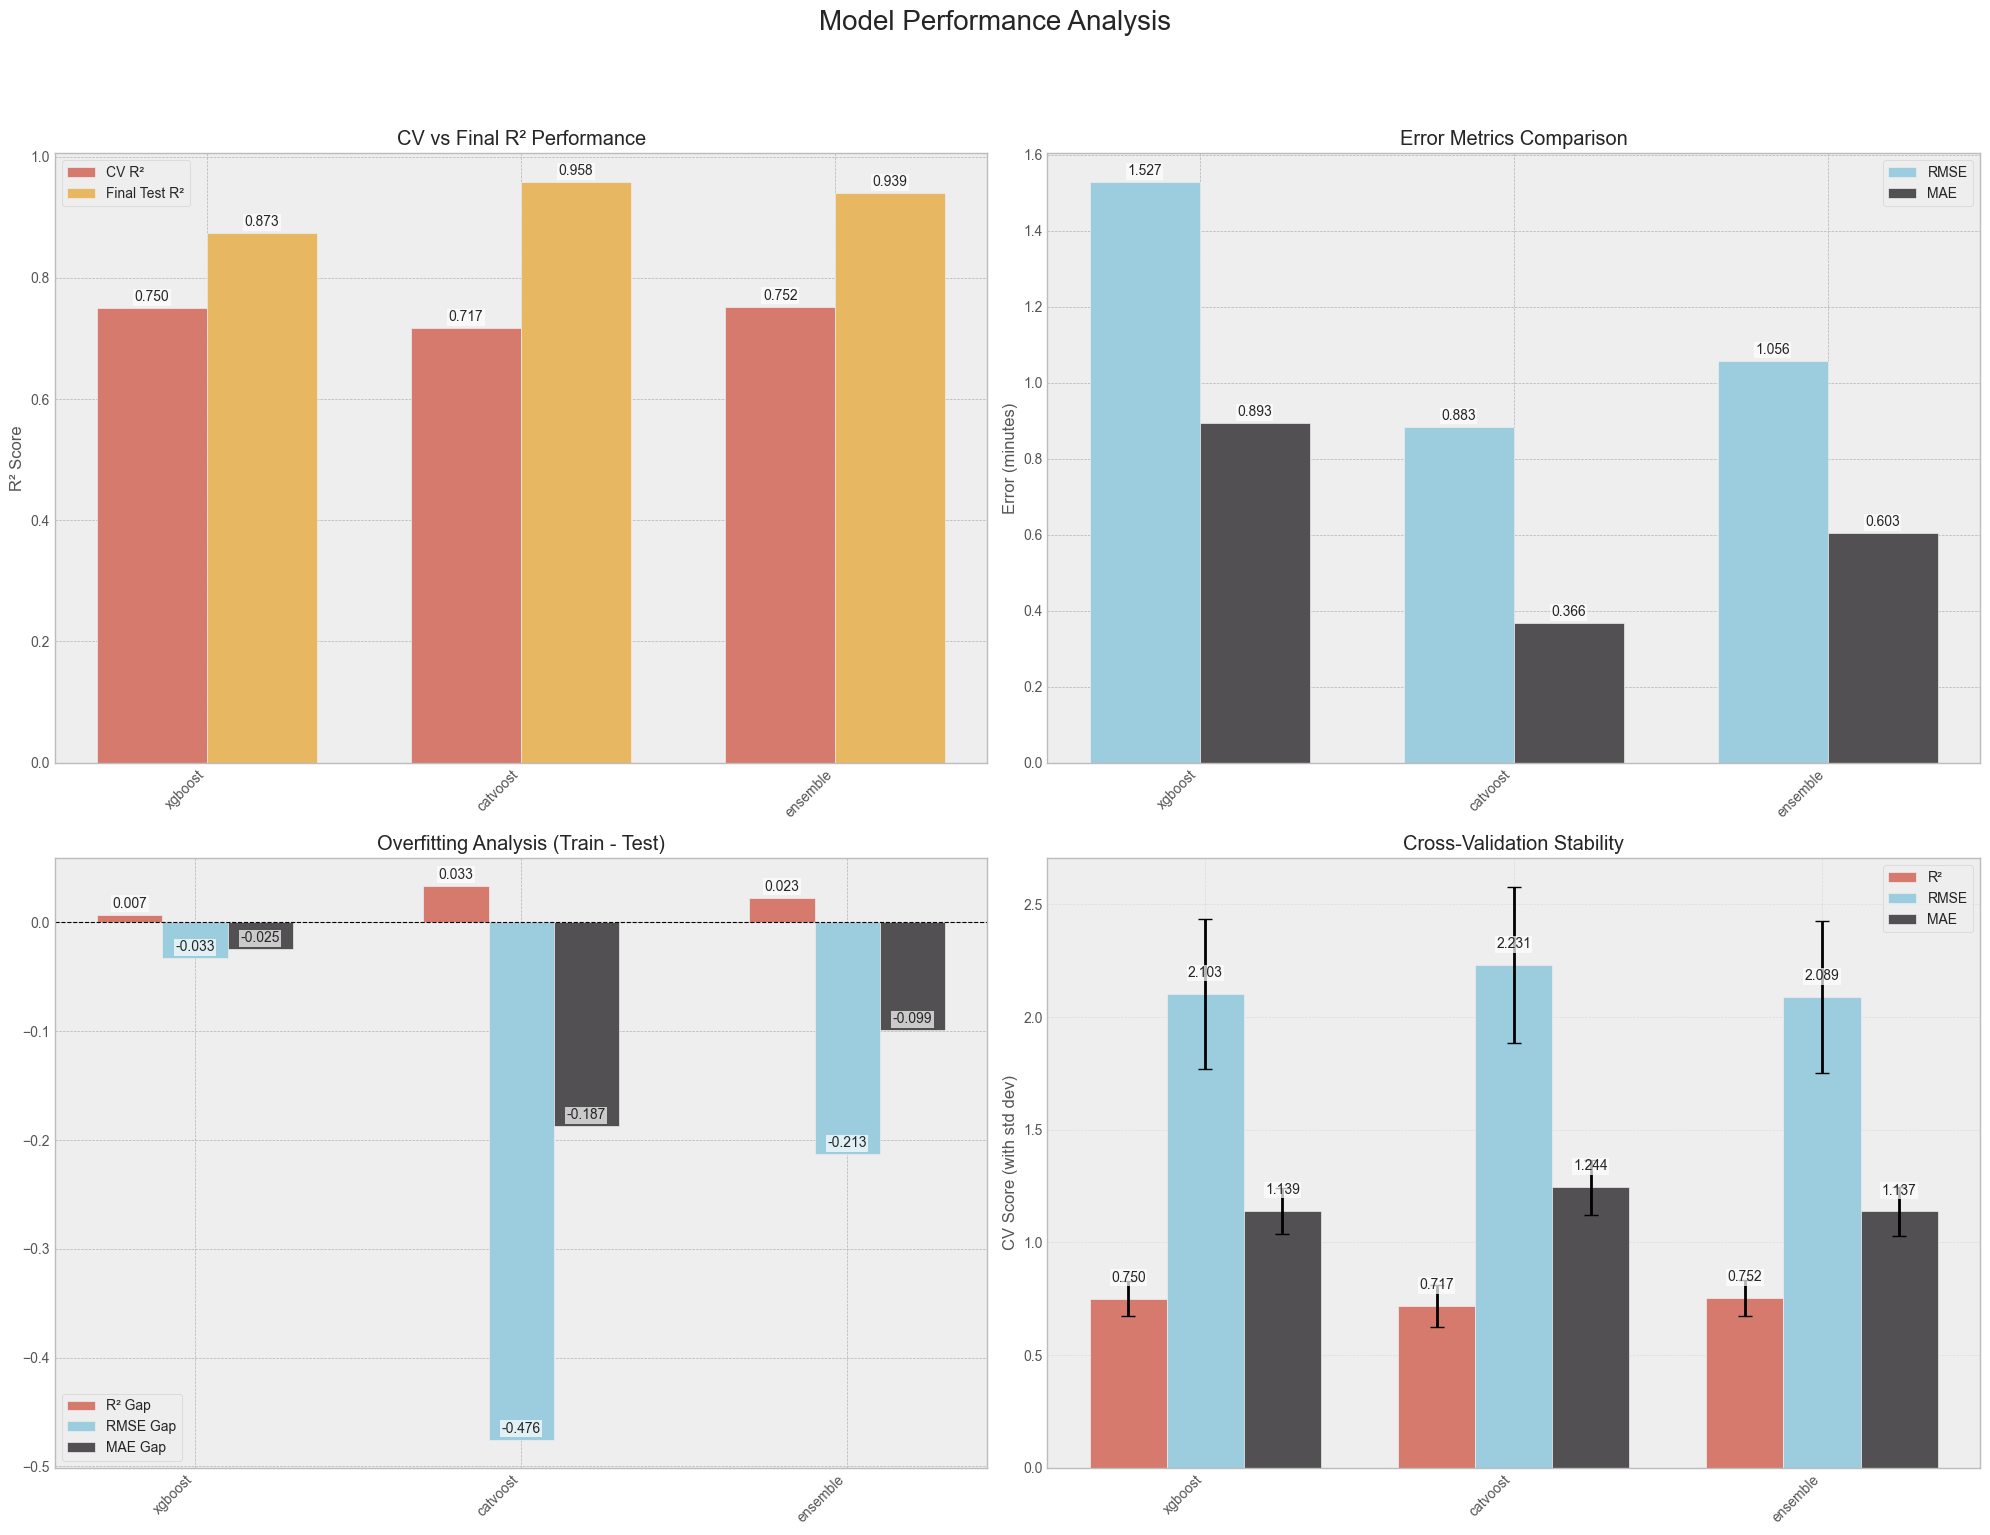

In [215]:
create_comprehensive_plot(model_results)

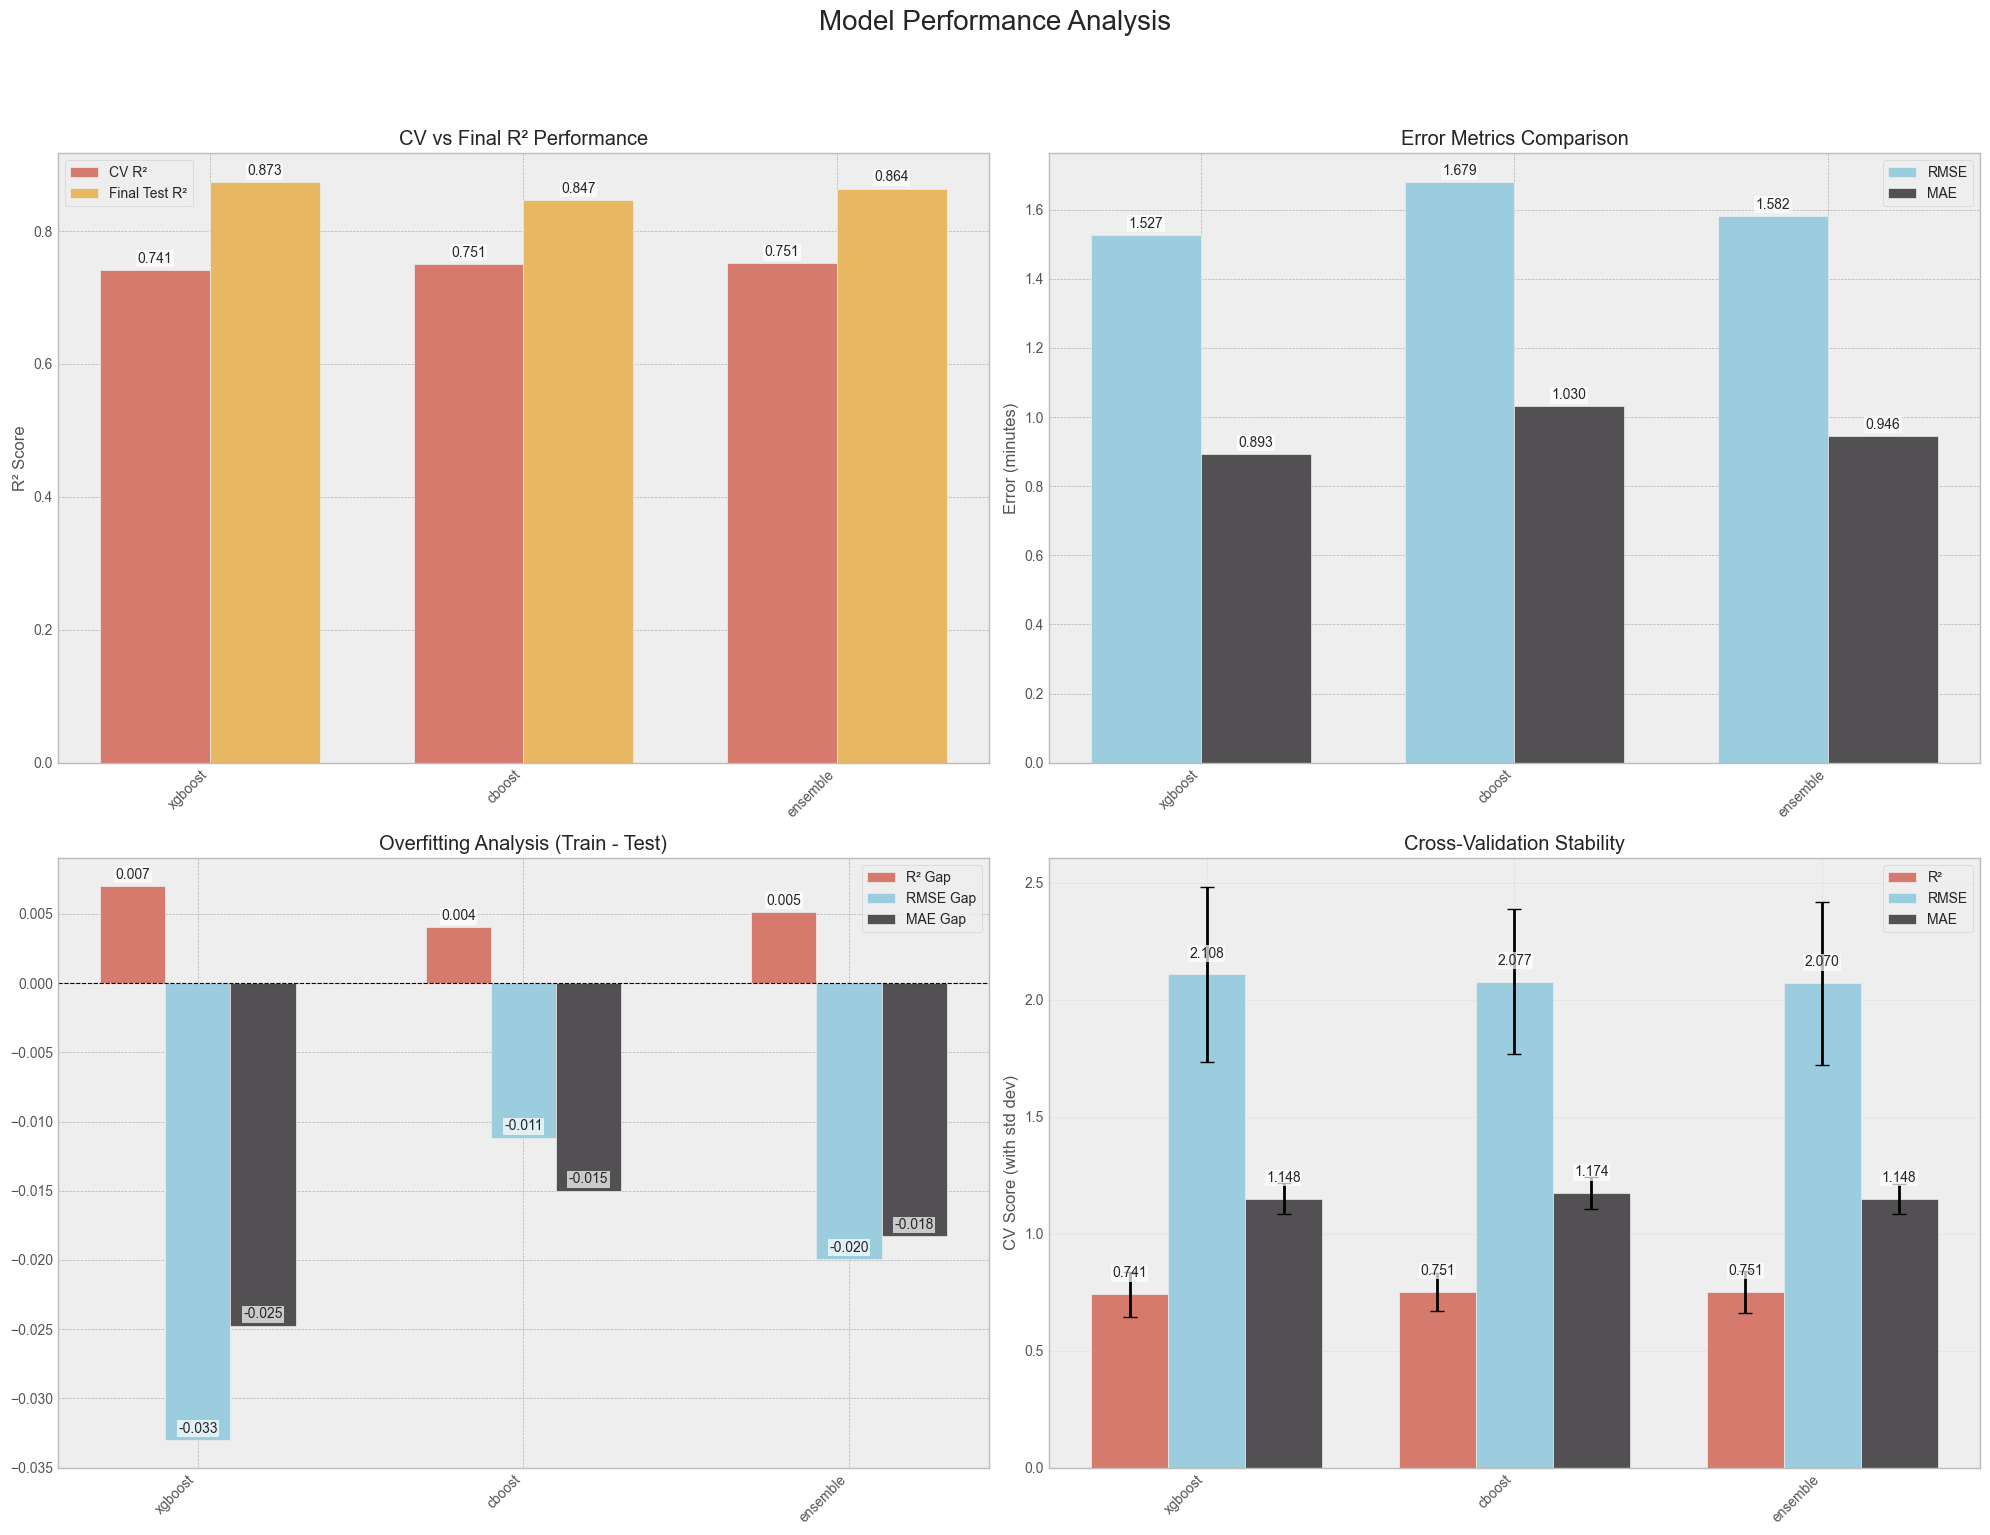

In [220]:
create_comprehensive_plot(model_results)

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

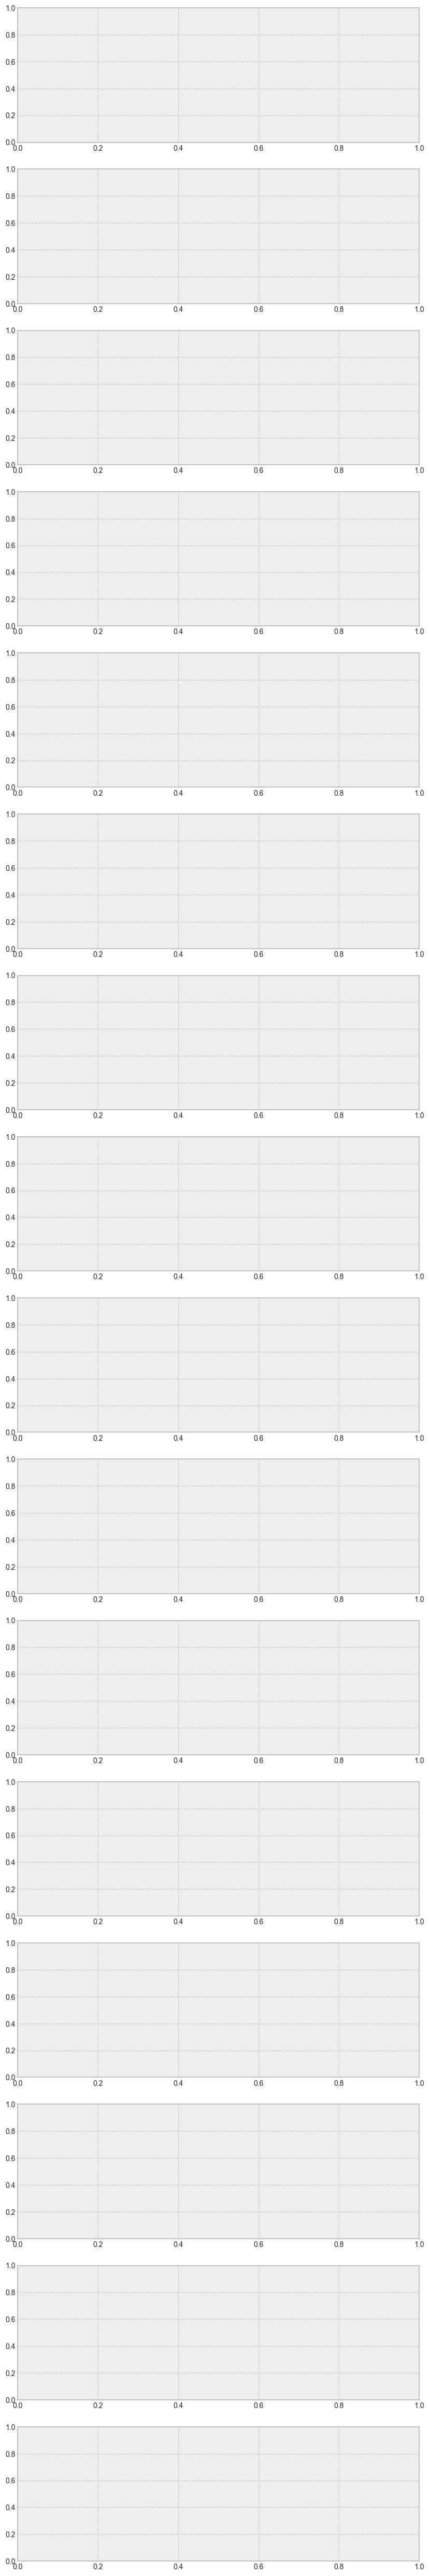

In [114]:
def compare_distributions(X_train, X_test, features_to_check):
    """Compare feature distributions between train and test sets"""
    fig, axes = plt.subplots(len(features_to_check), 1, figsize=(10, 4*len(features_to_check)))
    
    for i, feature in enumerate(features_to_check):
        sns.kdeplot(data=X_train[feature], ax=axes[i], label='Train')
        sns.kdeplot(data=X_test[feature], ax=axes[i], label='Test')
        axes[i].set_title(f'{feature} Distribution')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

compare_distributions(X_train, X_test, X_train.columns)

## Tuning Base Models

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import HuberRegressor
from catboost import CatBoostRegressor


def tune_randomforest(X, y, n_trials=100):
    """Tune RandomForest parameters using Optuna"""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.3, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }
        
        model = RandomForestRegressor(**params)
        scores = cross_val_score(
            model, X, y, 
            scoring='neg_root_mean_squared_error',
            cv=5,
            n_jobs=-1
        )
        return -scores.mean()
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params


def tune_catboost(X, y, n_trials=100):
    """Tune CatBoost parameters using Optuna"""
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_strength': trial.suggest_float('random_strength', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
            'task_type': 'GPU',
            'random_seed': 42
        }
        
        model = CatBoostRegressor(**params, verbose=False)
        scores = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error', 
            cv=5,
            n_jobs=-1
        )
        return -scores.mean()
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params


def tune_adaboost(X, y, n_trials=100):
    """Tune AdaBoost parameters using Optuna"""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential']),
            'random_state': 42
        }
        
        model = AdaBoostRegressor(**params)
        scores = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error',
            cv=5, 
            n_jobs=-1
        )
        return -scores.mean()
        
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params


# Tune models
print("Tuning RandomForest...")
rf_best_params = tune_randomforest(
    X_train[default_features].values,
    y_train.values,
    n_trials=100
)

print("\nTuning CatBoost...")
catboost_best_params = tune_catboost(
    X_train[default_features].values, 
    y_train.values,
    n_trials=100
)

print("\nTuning AdaBoost...")
adaboost_best_params = tune_adaboost(
    X_train[default_features].values,
    y_train.values, 
    n_trials=100
)

# Ensemble Models

In [293]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Union
import pandas as pd

class RobustEnsemble(BaseEstimator, RegressorMixin):
    """Enhanced robust ensemble with improved feature selection and regularization"""
    def __init__(
        self,
        cv=3,
        n_feature_subsets=3,
        feature_sample_size=0.8,
        weight_method='stacking',  # 'inverse_mse', 'stacking', or 'optimal'
        random_state=42
    ):
        self.cv = cv
        self.n_feature_subsets = n_feature_subsets
        self.feature_sample_size = feature_sample_size
        self.weight_method = weight_method
        self.random_state = random_state
        self.models = []
        self.feature_sets = []
        self.model_weights = None
        self.meta_learner = None
        
    def _create_base_models(self):
        """Create diverse base models with complementary strengths"""
        return [
            ('xgb', XGBRegressor(
                **xgb_best_params,
                tree_method='hist',
                device='cuda'
            )),
            ('rf', RandomForestRegressor(
                **rf_best_params,
                n_jobs=-1
            )),
            ('ridge', Ridge(
                alpha=1.0,
                random_state=self.random_state
            ))
        ]
    
    def _select_features(self, X, y):
        """Intelligent feature selection using importance-based sampling"""
        feature_importances = []
        
        # Get feature importance from tree-based models
        for name, model in self._create_base_models():
            if isinstance(model, (XGBRegressor, RandomForestRegressor)):
                model.fit(X, y)
                importances = model.feature_importances_
                feature_importances.append(importances)
        
        # Average feature importances
        mean_importance = np.mean(feature_importances, axis=0)
        
        # Create feature subsets with probability proportional to importance
        feature_sets = []
        n_features = X.shape[1]
        n_sample_features = int(n_features * self.feature_sample_size)
        
        for _ in range(self.n_feature_subsets):
            probs = mean_importance / mean_importance.sum()
            features = np.random.choice(
                n_features,
                size=n_sample_features,
                replace=False,
                p=probs
            )
            feature_sets.append(features)
        
        return feature_sets

    def fit(self, X, y):
        """Enhanced fit method with proper cross-validation and stacking"""
        np.random.seed(self.random_state)
        
        # Select features intelligently
        self.feature_sets = self._select_features(X, y)
        
        # Initialize time series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv)
        
        # Initialize meta-features array for stacking
        meta_features = np.zeros((X.shape[0], len(self._create_base_models()) * len(self.feature_sets)))
        
        # Train base models and generate meta-features
        for feature_idx, features in enumerate(self.feature_sets):
            X_subset = X[:, features]
            
            for model_idx, (name, model) in enumerate(self._create_base_models()):
                print(f"Training {name} on feature subset {feature_idx + 1}/{len(self.feature_sets)}")
                
                # Clone model once outside the CV loop
                base_model = clone(model)
                
                # Generate out-of-fold predictions for meta-features
                for fold, (train_idx, val_idx) in enumerate(tscv.split(X_subset)):
                    X_train, X_val = X_subset[train_idx], X_subset[val_idx]
                    y_train = y[train_idx]
                    
                    base_model.fit(X_train, y_train)
                    meta_features[val_idx, feature_idx * len(self._create_base_models()) + model_idx] = \
                        base_model.predict(X_val)
                
                # Train final model on full data
                final_model = clone(model)
                final_model.fit(X_subset, y)
                self.models.append((final_model, features))
        
        # Train meta-learner
        if self.weight_method == 'stacking':
            self.meta_learner = Ridge(alpha=1.0, random_state=self.random_state)
            self.meta_learner.fit(meta_features, y)
        else:
            # Calculate weights based on validation performance
            self.model_weights = np.zeros(len(self.models))
            for i in range(len(self.models)):
                if self.weight_method == 'inverse_mse':
                    mse = mean_squared_error(y, meta_features[:, i])
                    self.model_weights[i] = 1.0 / (mse + 1e-10)
                else:  # optimal weights
                    r2 = r2_score(y, meta_features[:, i])
                    self.model_weights[i] = max(0, r2)  # Only use positive R²
            
            # Normalize weights
            self.model_weights /= np.sum(self.model_weights)
        
        return self
    
    def predict(self, X):
        """Enhanced prediction with proper weighting"""
        predictions = np.zeros((X.shape[0], len(self.models)))
        
        for i, (model, features) in enumerate(self.models):
            predictions[:, i] = model.predict(X[:, features])
        
        if self.weight_method == 'stacking':
            return self.meta_learner.predict(predictions)
        else:
            return np.average(predictions, weights=self.model_weights, axis=1)

def train_and_evaluate_models(X_train: np.ndarray, 
                            X_test: np.ndarray, 
                            y_train: np.ndarray, 
                            y_test: np.ndarray, 
                            cv: int = 5) -> Dict:
    """
    Train and evaluate individual models and ensemble
    
    Parameters:
    -----------
    X_train : np.ndarray
        Training features
    X_test : np.ndarray
        Test features
    y_train : np.ndarray
        Training target
    y_test : np.ndarray
        Test target
    cv : int
        Number of cross-validation folds
        
    Returns:
    --------
    Dict
        Dictionary containing model results
    """
    
    # Initialize results dictionary
    results = {}
    
    # Base models to evaluate
    base_models = {
        'xgboost': XGBRegressor(**xgb_best_params, tree_method='hist', device='cuda'),
        'randomforest': RandomForestRegressor(**rf_best_params, n_jobs=-1),
        'ridge': Ridge(random_state=42)
    }
    
    # Train and evaluate base models
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    
    # Train and evaluate ensemble
    print("\nTraining ensemble...")
    ensemble_models = {
        'stacking': RobustEnsemble(cv=cv, weight_method='stacking'),
        'optimal': RobustEnsemble(cv=cv, weight_method='optimal'),
        'inverse_mse': RobustEnsemble(cv=cv, weight_method='inverse_mse')
    }
    
    for name, model in ensemble_models.items():
        print(f"\nTraining {name} ensemble...")
        results[f'ensemble_{name}'] = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    
    return results

def evaluate_model(model: BaseEstimator,
                  X_train: np.ndarray,
                  X_test: np.ndarray,
                  y_train: np.ndarray,
                  y_test: np.ndarray,
                  cv: int) -> Dict:
    """
    Evaluate a single model using cross-validation and final performance
    
    Parameters:
    -----------
    model : BaseEstimator
        The model to evaluate
    X_train : np.ndarray
        Training features
    X_test : np.ndarray
        Test features
    y_train : np.ndarray
        Training target
    y_test : np.ndarray
        Test target
    cv : int
        Number of cross-validation folds
        
    Returns:
    --------
    Dict
        Dictionary containing model performance metrics
    """
    
    # Initialize cross-validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Cross-validation scores
    cv_scores = {
        'r2': [],
        'rmse': [],
        'mae': []
    }
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        # Split data
        X_fold_train = X_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_train = y_train[train_idx]
        y_fold_val = y_train[val_idx]
        
        # Train model
        model_clone = clone(model)
        model_clone.fit(X_fold_train, y_fold_train)
        
        # Make predictions
        y_fold_pred = model_clone.predict(X_fold_val)
        
        # Calculate metrics
        cv_scores['r2'].append(r2_score(y_fold_val, y_fold_pred))
        cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))
        cv_scores['mae'].append(mean_absolute_error(y_fold_val, y_fold_pred))
    
    # Train final model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Return results
    return {
        'model': model,
        'cv_performance': {
            'r2_mean': np.mean(cv_scores['r2']),
            'r2_std': np.std(cv_scores['r2']),
            'rmse_mean': np.mean(cv_scores['rmse']),
            'rmse_std': np.std(cv_scores['rmse']),
            'mae_mean': np.mean(cv_scores['mae']),
            'mae_std': np.std(cv_scores['mae'])
        },
        'final_performance': {
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test)
        }
    }

def plot_model_comparison(results: Dict):
    """
    Create comprehensive visualization of model performance
    
    Parameters:
    -----------
    results : Dict
        Dictionary containing model results
    """
    
    plt.style.use('bmh')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. R² Score Comparison
    plt.subplot(221)
    model_names = list(results.keys())
    train_r2 = [res['final_performance']['train_r2'] for res in results.values()]
    test_r2 = [res['final_performance']['test_r2'] for res in results.values()]
    cv_r2 = [res['cv_performance']['r2_mean'] for res in results.values()]
    cv_r2_std = [res['cv_performance']['r2_std'] for res in results.values()]
    
    x = np.arange(len(model_names))
    width = 0.25
    
    plt.bar(x - width, train_r2, width, label='Train R²')
    plt.bar(x, test_r2, width, label='Test R²')
    plt.bar(x + width, cv_r2, width, yerr=cv_r2_std, label='CV R² (mean ± std)')
    
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.title('R² Score Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    # 2. RMSE Comparison
    plt.subplot(222)
    train_rmse = [res['final_performance']['train_rmse'] for res in results.values()]
    test_rmse = [res['final_performance']['test_rmse'] for res in results.values()]
    cv_rmse = [res['cv_performance']['rmse_mean'] for res in results.values()]
    cv_rmse_std = [res['cv_performance']['rmse_std'] for res in results.values()]
    
    plt.bar(x - width, train_rmse, width, label='Train RMSE')
    plt.bar(x, test_rmse, width, label='Test RMSE')
    plt.bar(x + width, cv_rmse, width, yerr=cv_rmse_std, label='CV RMSE (mean ± std)')
    
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    # 3. MAE Comparison
    plt.subplot(223)
    train_mae = [res['final_performance']['train_mae'] for res in results.values()]
    test_mae = [res['final_performance']['test_mae'] for res in results.values()]
    cv_mae = [res['cv_performance']['mae_mean'] for res in results.values()]
    cv_mae_std = [res['cv_performance']['mae_std'] for res in results.values()]
    
    plt.bar(x - width, train_mae, width, label='Train MAE')
    plt.bar(x, test_mae, width, label='Test MAE')
    plt.bar(x + width, cv_mae, width, yerr=cv_mae_std, label='CV MAE (mean ± std)')
    
    plt.xlabel('Model')
    plt.ylabel('MAE')
    plt.title('MAE Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    # 4. Overfitting Analysis
    plt.subplot(224)
    r2_gap = [res['final_performance']['train_r2'] - res['final_performance']['test_r2'] 
              for res in results.values()]
    rmse_gap = [res['final_performance']['train_rmse'] - res['final_performance']['test_rmse'] 
                for res in results.values()]
    mae_gap = [res['final_performance']['train_mae'] - res['final_performance']['test_mae'] 
               for res in results.values()]
    
    plt.bar(x - width, r2_gap, width, label='R² Gap')
    plt.bar(x, rmse_gap, width, label='RMSE Gap')
    plt.bar(x + width, mae_gap, width, label='MAE Gap')
    
    plt.xlabel('Model')
    plt.ylabel('Metric Gap (Train - Test)')
    plt.title('Overfitting Analysis')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Train and evaluate models
model_results = train_and_evaluate_models(
    X_train[default_features].values,
    X_test[default_features].values,
    y_train.values,
    y_test.values,
    cv=5
)

# Plot results
plot_model_comparison(model_results)

# Print detailed results
for name, results in model_results.items():
    print(f"\n{name} Results:")
    print("-" * 50)
    print("Cross-validation Performance:")
    for metric, value in results['cv_performance'].items():
        print(f"{metric}: {value:.4f}")
    print("\nFinal Performance:")
    for metric, value in results['final_performance'].items():
        print(f"{metric}: {value:.4f}")


Training xgboost...

Training randomforest...

Training ridge...

Training ensemble...

Training stacking ensemble...
Training xgb on feature subset 1/3
Training rf on feature subset 1/3
Training ridge on feature subset 1/3
Training xgb on feature subset 2/3
Training rf on feature subset 2/3
Training ridge on feature subset 2/3
Training xgb on feature subset 3/3
Training rf on feature subset 3/3
Training ridge on feature subset 3/3


KeyboardInterrupt: 

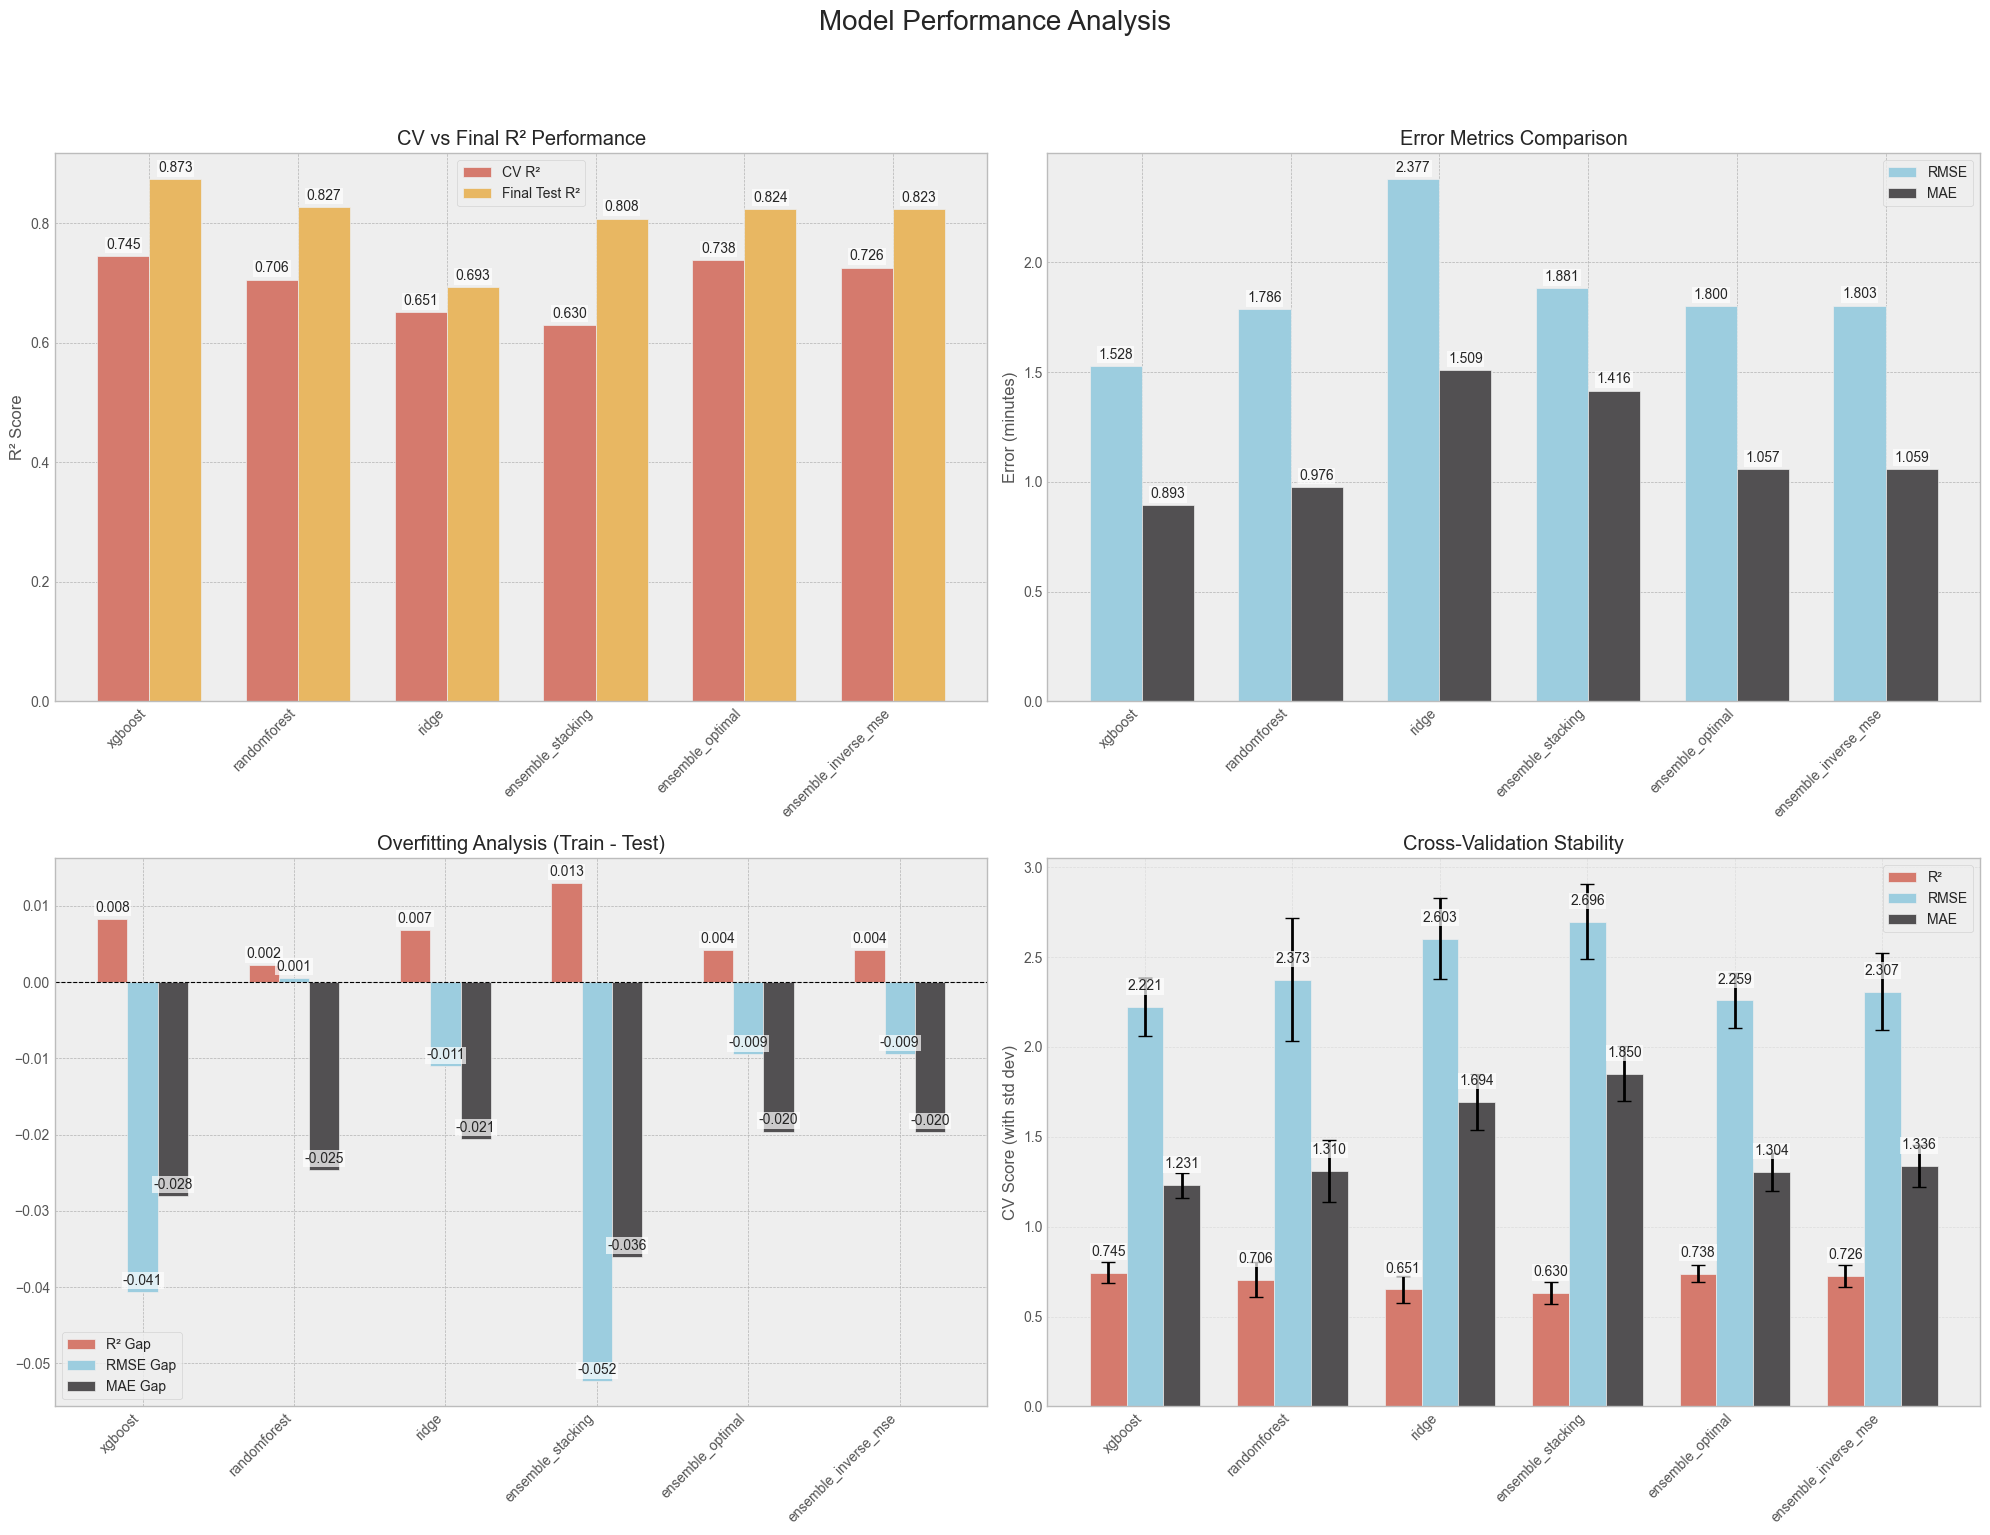

In [261]:
create_comprehensive_plot(model_results)

## Regularized KNN

[I 2024-11-15 21:11:43,566] A new study created in memory with name: no-name-5d1b4a48-d0d9-48cd-ac2e-68e941578f3c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-15 21:11:43,673] Trial 0 finished with value: 0.744133304607109 and parameters: {'n_neighbors': 20, 'feature_lambda': 2.536999076681771, 'power': 2.46398788362281, 'metric': 'minkowski'}. Best is trial 0 with value: 0.744133304607109.
[I 2024-11-15 21:11:43,708] Trial 1 finished with value: 0.2770500601581437 and parameters: {'n_neighbors': 10, 'feature_lambda': 0.12184186502221767, 'power': 2.73235229154987, 'metric': 'cosine'}. Best is trial 0 with value: 0.744133304607109.
[I 2024-11-15 21:11:43,793] Trial 2 finished with value: 0.6911926248456467 and parameters: {'n_neighbors': 3, 'feature_lambda': 2.7081608642499675, 'power': 2.6648852816008435, 'metric': 'minkowski'}. Best is trial 0 with value: 0.744133304607109.
[I 2024-11-15 21:11:43,871] Trial 3 finished with value: 0.7258610493387414 and parameters: {'n_neighbors': 11, 'feature_lambda': 0.28145092716060655, 'power': 2.049512863264476, 'metric': 'minkowski'}. Best is trial 0 with value: 0.744133304607109.
[I 2024-1

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_43072\2740966724.py:300: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



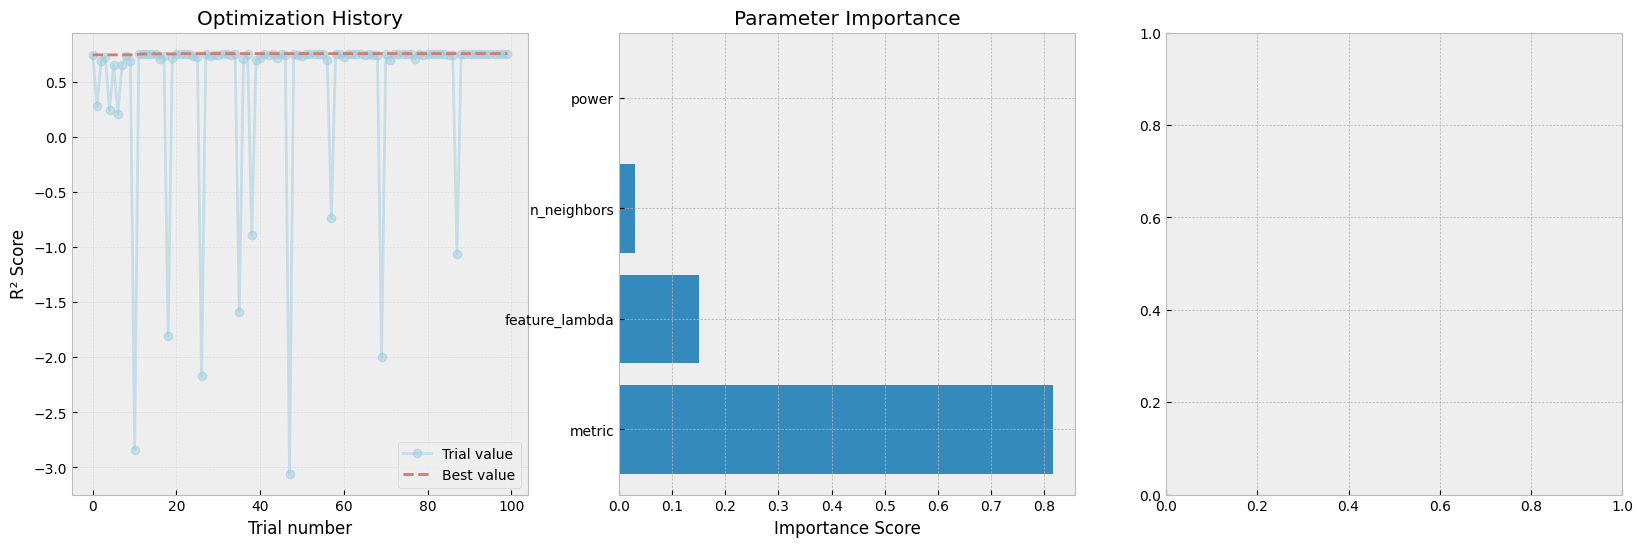

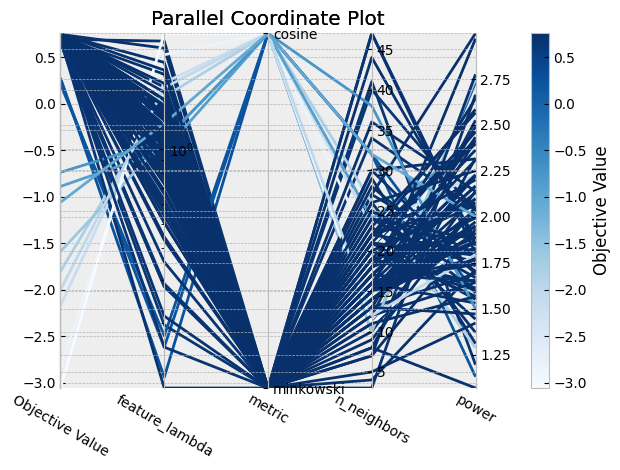

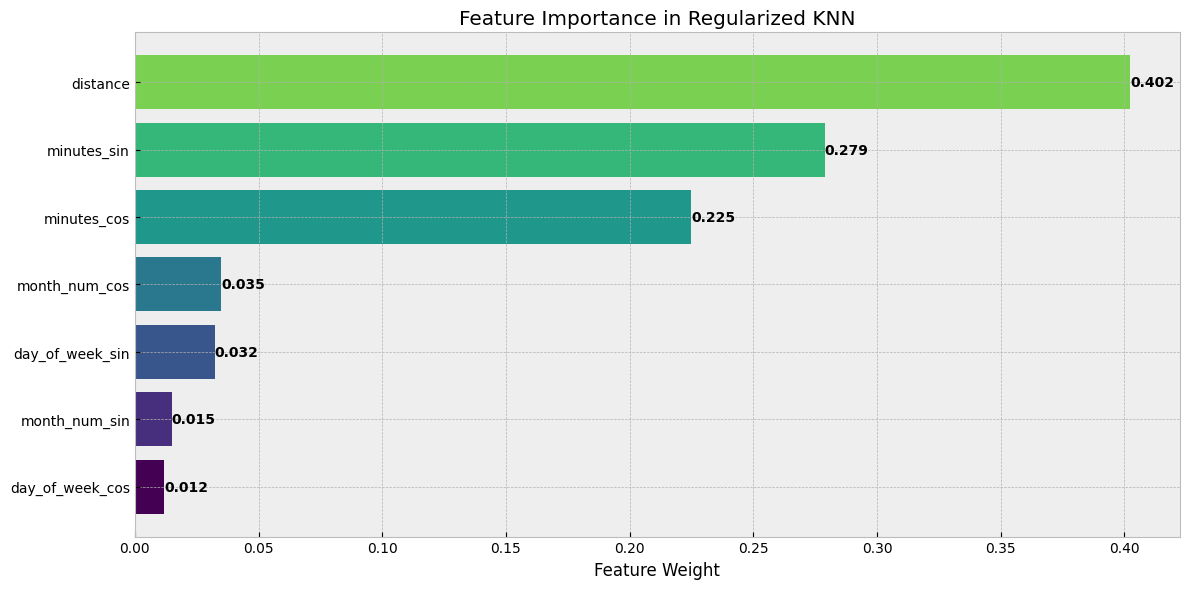

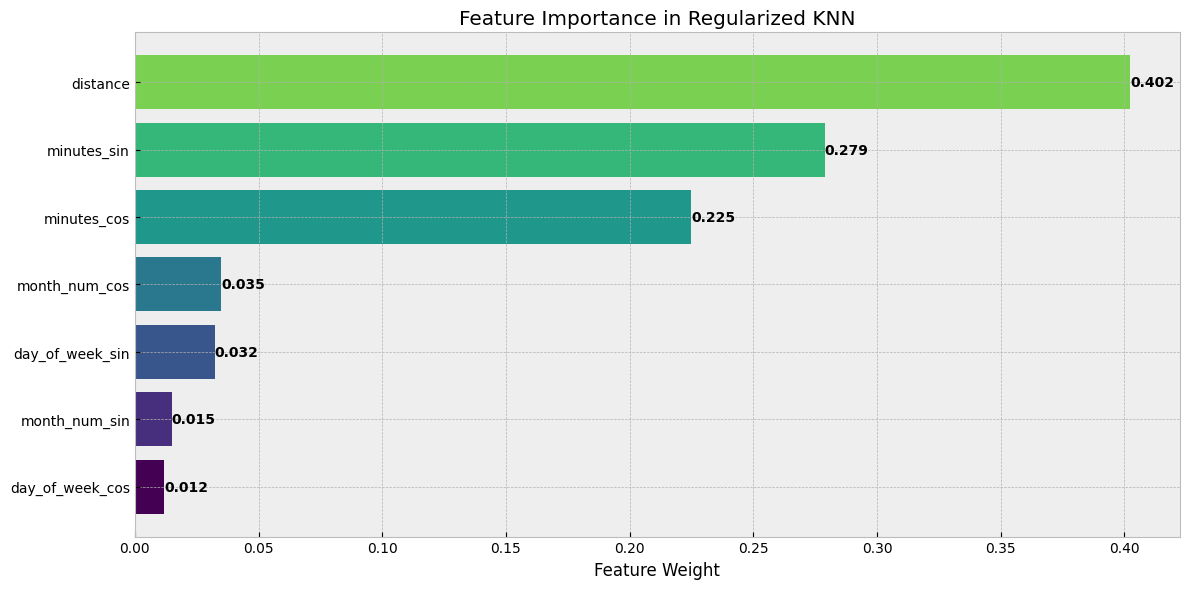


Feature Importance:
distance: 0.4024
minutes_sin: 0.2789
minutes_cos: 0.2250
day_of_week_sin: 0.0323
day_of_week_cos: 0.0117
month_num_sin: 0.0149
month_num_cos: 0.0349


In [349]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
from typing import Tuple, Optional, Union
import warnings

class RegularizedKNN(BaseEstimator, RegressorMixin):
    """
    K-Nearest Neighbors regressor with correlation-based feature regularization
    and efficient distance calculations.
    
    Parameters:
    -----------
    n_neighbors : int
        Number of neighbors to use for prediction
    feature_lambda : float
        Regularization strength for feature weights (higher values = stronger correlation impact)
    power : float
        Power parameter for Minkowski distance (1=Manhattan, 2=Euclidean)
    metric : str
        Distance metric to use ('minkowski' or 'cosine')
    """
    def __init__(
        self,
        n_neighbors: int = 5,
        feature_lambda: float = 1.0,
        power: float = 2.0,
        metric: str = 'minkowski',
        distance_threshold: Optional[float] = None,
        weight_method: str = 'uniform',
        leaf_size: int = 30,
        p_norm: float = 2.0,
        feature_weights: Optional[np.ndarray] = None,
        adaptive_weights: bool = False,
        min_weight: float = 0.1,
        max_weight: float = 10.0,
        random_state: Optional[int] = None
    ):
        self.n_neighbors = n_neighbors
        self.feature_lambda = feature_lambda
        self.power = power
        self.metric = metric
        self.distance_threshold = distance_threshold
        self.weight_method = weight_method
        self.leaf_size = leaf_size
        self.p_norm = p_norm
        self.feature_weights = feature_weights
        self.adaptive_weights = adaptive_weights
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.random_state = random_state
        
        # Initialize attributes
        self.feature_weights_ = None
        self.X_train_ = None
        self.y_train_ = None
        self.feature_names_ = None
        
    def _validate_data(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """Validate and convert input data to numpy arrays"""
        if isinstance(X, (pd.DataFrame, pd.Series)):
            if not self.feature_names_:
                self.feature_names_ = X.columns.tolist()
            X = X.values
        
        if y is not None and isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values.ravel()
            
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        return X, y
    
    def _compute_feature_weights(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute feature weights based on correlation with target"""
        weights = np.zeros(X.shape[1])
        
        for i in range(X.shape[1]):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                correlation = pearsonr(X[:, i], y)[0]
                weights[i] = abs(correlation) ** self.feature_lambda
                
        # Handle features with zero correlation
        weights = np.maximum(weights, 1e-10)
        return weights / np.sum(weights)  # Normalize weights
    
    def _compute_distances(self, X: np.ndarray) -> np.ndarray:
        """Compute distances between test points and training points efficiently"""
        if self.metric == 'minkowski':
            # Vectorized Minkowski distance calculation
            weighted_X = X * self.feature_weights_
            weighted_X_train = self.X_train_ * self.feature_weights_
            
            # Compute differences
            diff = weighted_X[:, np.newaxis, :] - weighted_X_train[np.newaxis, :, :]
            
            # Compute distances
            distances = np.power(
                np.sum(np.abs(diff) ** self.power, axis=2),
                1.0 / self.power
            )
            
        elif self.metric == 'cosine':
            # Normalize vectors
            X_norm = np.sqrt(np.sum(X ** 2, axis=1))[:, np.newaxis]
            X_train_norm = np.sqrt(np.sum(self.X_train_ ** 2, axis=1))[np.newaxis, :]
            
            # Compute cosine similarity
            similarity = np.dot(X * self.feature_weights_, (self.X_train_ * self.feature_weights_).T)
            similarity /= (X_norm * X_train_norm + 1e-10)
            
            # Convert to distance
            distances = 1 - similarity
            
        else:
            raise ValueError(f"Unknown metric: {self.metric}")
            
        return distances
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'RegularizedKNN':
        """Fit the model by storing training data and computing feature weights"""
        # Validate and convert input data
        X, y = self._validate_data(X, y)
        
        # Store training data
        self.X_train_ = X
        self.y_train_ = y
        
        # Compute feature weights
        self.feature_weights_ = self._compute_feature_weights(X, y)
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict target values for test data"""
        # Validate input data
        X, _ = self._validate_data(X)
        
        # Compute distances
        distances = self._compute_distances(X)
        
        # Get indices of k nearest neighbors
        neighbor_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        
        # Compute weights based on distances
        neighbor_distances = np.take_along_axis(distances, neighbor_indices, axis=1)
        weights = 1.0 / (neighbor_distances + 1e-10)
        weights /= np.sum(weights, axis=1, keepdims=True)
        
        # Compute weighted average of target values
        predictions = np.sum(
            weights * self.y_train_[neighbor_indices],
            axis=1
        )
        
        return predictions
    
    def get_feature_importance(self) -> Union[dict, np.ndarray]:
        """Return feature importance based on correlation weights"""
        if self.feature_names_:
            return dict(zip(self.feature_names_, self.feature_weights_))
        return self.feature_weights_

def objective(trial, X_train, y_train, cv=5):
    """
    Optuna objective function for tuning RegularizedKNN with proper time series validation
    and comprehensive metrics tracking.
    """
    # Define hyperparameter search space
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'feature_lambda': trial.suggest_float('feature_lambda', 0.1, 3.0, log=True),
        'power': trial.suggest_float('power', 1.0, 3.0),
        'metric': trial.suggest_categorical('metric', ['minkowski', 'cosine'])
    }
    
    # Initialize model
    model = RegularizedKNN(**params)
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Initialize metrics storage
    fold_metrics = {
        'r2': [],
        'rmse': [],
        'mae': []
    }
    
    # Perform time series cross-validation
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        # Split data for this fold
        X_fold_train = X_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_train = y_train[train_idx]
        y_fold_val = y_train[val_idx]
        
        try:
            # Train model
            model.fit(X_fold_train, y_fold_train)
            
            # Make predictions
            y_pred = model.predict(X_fold_val)
            
            # Calculate metrics
            fold_metrics['r2'].append(r2_score(y_fold_val, y_pred))
            fold_metrics['rmse'].append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
            fold_metrics['mae'].append(mean_absolute_error(y_fold_val, y_pred))
            
        except Exception as e:
            print(f"Error in fold {fold}: {str(e)}")
            return float('-inf')
    
    # Calculate mean metrics
    mean_r2 = np.mean(fold_metrics['r2'])
    mean_rmse = np.mean(fold_metrics['rmse'])
    mean_mae = np.mean(fold_metrics['mae'])
    
    # Store metrics in trial
    trial.set_user_attr('rmse', mean_rmse)  # Changed from rmse_mean
    trial.set_user_attr('mae', mean_mae)    # Changed from mae_mean
    trial.set_user_attr('r2', mean_r2)      # Added for consistency
    
    # Store standard deviations
    trial.set_user_attr('rmse_std', np.std(fold_metrics['rmse']))
    trial.set_user_attr('mae_std', np.std(fold_metrics['mae']))
    trial.set_user_attr('r2_std', np.std(fold_metrics['r2']))
    
    # Store best and worst performance
    trial.set_user_attr('best_fold_r2', max(fold_metrics['r2']))
    trial.set_user_attr('worst_fold_r2', min(fold_metrics['r2']))
    
    return mean_r2

def tune_knn(X_train, y_train, cv=5, n_trials=100):
    """Tune RegularizedKNN using Optuna"""
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, cv),
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    print("\nBest parameters:", study.best_params)
    print(f"Best R² score: {study.best_value:.4f}")
    print(f"Best RMSE: {study.best_trial.user_attrs['rmse']:.4f}")  # Matches the stored name
    print(f"Best MAE: {study.best_trial.user_attrs['mae']:.4f}")    # Matches the stored name
    
    # Print additional information
    print("\nCross-validation details:")
    print(f"R² std: ±{study.best_trial.user_attrs['r2_std']:.4f}")
    print(f"Best fold R²: {study.best_trial.user_attrs['best_fold_r2']:.4f}")
    print(f"Worst fold R²: {study.best_trial.user_attrs['worst_fold_r2']:.4f}")
    
    return study.best_params, study

def plot_optimization_results(study):
    """Plot optimization results with proper figure sizes and data checks"""
    
    # Create a figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. Optimization History
    plt.subplot(131)
    if study.trials:
        trial_numbers = [t.number for t in study.trials]
        values = [t.value for t in study.trials]
        best_values = np.maximum.accumulate([v if v is not None else -np.inf for v in values])
        
        plt.plot(trial_numbers, values, 'o-', color='#9CCDDFFF', label='Trial value', alpha=0.5)
        plt.plot(trial_numbers, best_values, '--', color='#D57A6DFF', label='Best value')
        plt.xlabel('Trial number')
        plt.ylabel('R² Score')
        plt.title('Optimization History')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # 2. Parameter Importance
    plt.subplot(132)
    importances = optuna.importance.get_param_importances(study)
    if importances:
        params = list(importances.keys())
        scores = list(importances.values())
        pos = np.arange(len(params))
        plt.barh(pos, scores, align='center')
        plt.yticks(pos, params)
        plt.xlabel('Importance Score')
        plt.title('Parameter Importance')
    
    # 3. Parallel Coordinate Plot
    plt.subplot(133)
    if len(study.trials) > 1:
        optuna.visualization.matplotlib.plot_parallel_coordinate(study)
        plt.title('Parallel Coordinate Plot')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names=None):
    """Plot feature importance with proper labels and formatting"""
    importance = model.get_feature_importance()
    
    plt.figure(figsize=(12, 6))
    
    if isinstance(importance, dict):
        features = list(importance.keys())
        weights = list(importance.values())
    else:
        weights = importance
        features = (feature_names if feature_names is not None 
                   else [f'Feature {i}' for i in range(len(weights))])
    
    # Sort by importance
    sorted_idx = np.argsort(weights)
    pos = np.arange(len(features))
    
    # Create bar plot
    plt.barh(pos, np.array(weights)[sorted_idx], align='center',
             color=plt.cm.viridis(np.linspace(0, 0.8, len(features))))
    
    # Add labels and formatting
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.xlabel('Feature Weight')
    plt.title('Feature Importance in Regularized KNN')
    
    # Add value labels on bars
    for i, v in enumerate(np.array(weights)[sorted_idx]):
        plt.text(v, i, f'{v:.3f}', 
                va='center', 
                fontweight='bold',
                fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Usage
knn_best_params, study = tune_knn(  # Changed from tune_regularized_knn
    X_train[default_features].values,
    y_train.values,
    cv=5,
    n_trials=100
)

# Plot results with feature names
plot_optimization_results(study)

# Create and train the best model
best_knn = RegularizedKNN(**knn_best_params)
best_knn.fit(X_train[default_features].values, y_train.values)

# Plot feature importance
plot_feature_importance(best_knn, feature_names=default_features)
plot_feature_importance(best_knn, feature_names=default_features)

# Print feature importance with names
print("\nFeature Importance:")
importance = best_knn.get_feature_importance()
for i, weight in enumerate(importance):
    feature_name = default_features[i] if i < len(default_features) else f"Feature_{i}"
    print(f"{feature_name}: {weight:.4f}")

In [305]:
 # Random Forest with selected interactions
rf_poly = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
        ('rf', RandomForestRegressor(**rf_best_params))
    ])

In [318]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Union
import pandas as pd

class RobustEnsemble(BaseEstimator, RegressorMixin):
    """Enhanced robust ensemble with improved feature selection and regularization"""
    def __init__(
        self,
        cv=3,
        n_feature_subsets=3,
        feature_sample_size=0.8,
        weight_method='stacking',  # 'inverse_mse', 'stacking', or 'optimal'
        random_state=42
    ):
        self.cv = cv
        self.n_feature_subsets = n_feature_subsets
        self.feature_sample_size = feature_sample_size
        self.weight_method = weight_method
        self.random_state = random_state
        self.models = []
        self.feature_sets = []
        self.model_weights = None
        self.meta_learner = None
        
    def _create_base_models(self):
        """Create diverse base models with complementary strengths"""
        return [
            ('xgb', XGBRegressor(
                **xgb_best_params,
                tree_method='hist',
                device='cuda'
            )),
            ('rf_poly', rf_poly),
            ('regularized_knn', RegularizedKNN(
                **knn_best_params
            ))
        ]
    
    def _select_features(self, X, y):
        """Intelligent feature selection using importance-based sampling"""
        feature_importances = []
        
        # Get feature importance from tree-based models
        for name, model in self._create_base_models():
            if isinstance(model, (XGBRegressor, RandomForestRegressor)):
                model.fit(X, y)
                importances = model.feature_importances_
                feature_importances.append(importances)
        
        # Average feature importances
        mean_importance = np.mean(feature_importances, axis=0)
        
        # Create feature subsets with probability proportional to importance
        feature_sets = []
        n_features = X.shape[1]
        n_sample_features = int(n_features * self.feature_sample_size)
        
        for _ in range(self.n_feature_subsets):
            probs = mean_importance / mean_importance.sum()
            features = np.random.choice(
                n_features,
                size=n_sample_features,
                replace=False,
                p=probs
            )
            feature_sets.append(features)
        
        return feature_sets

    def fit(self, X, y):
        """Enhanced fit method with proper cross-validation and stacking"""
        np.random.seed(self.random_state)
        
        # Select features intelligently
        self.feature_sets = self._select_features(X, y)
        
        # Initialize time series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv)
        
        # Initialize meta-features array for stacking
        meta_features = np.zeros((X.shape[0], len(self._create_base_models()) * len(self.feature_sets)))
        
        # Train base models and generate meta-features
        for feature_idx, features in enumerate(self.feature_sets):
            X_subset = X[:, features]
            
            for model_idx, (name, model) in enumerate(self._create_base_models()):
                print(f"Training {name} on feature subset {feature_idx + 1}/{len(self.feature_sets)}")
                
                # Clone model once outside the CV loop
                base_model = clone(model)
                
                # Generate out-of-fold predictions for meta-features
                for fold, (train_idx, val_idx) in enumerate(tscv.split(X_subset)):
                    X_train, X_val = X_subset[train_idx], X_subset[val_idx]
                    y_train = y[train_idx]
                    
                    base_model.fit(X_train, y_train)
                    meta_features[val_idx, feature_idx * len(self._create_base_models()) + model_idx] = \
                        base_model.predict(X_val)
                
                # Train final model on full data
                final_model = clone(model)
                final_model.fit(X_subset, y)
                self.models.append((final_model, features))
        
        # Train meta-learner
        if self.weight_method == 'stacking':
            self.meta_learner = Ridge(alpha=1.0, random_state=self.random_state)
            self.meta_learner.fit(meta_features, y)
        else:
            # Calculate weights based on validation performance
            self.model_weights = np.zeros(len(self.models))
            for i in range(len(self.models)):
                if self.weight_method == 'inverse_mse':
                    mse = mean_squared_error(y, meta_features[:, i])
                    self.model_weights[i] = 1.0 / (mse + 1e-10)
                else:  # optimal weights
                    r2 = r2_score(y, meta_features[:, i])
                    self.model_weights[i] = max(0, r2)  # Only use positive R²
            
            # Normalize weights
            self.model_weights /= np.sum(self.model_weights)
        
        return self
    
    def predict(self, X):
        """Enhanced prediction with proper weighting"""
        predictions = np.zeros((X.shape[0], len(self.models)))
        
        for i, (model, features) in enumerate(self.models):
            predictions[:, i] = model.predict(X[:, features])
        
        if self.weight_method == 'stacking':
            return self.meta_learner.predict(predictions)
        else:
            return np.average(predictions, weights=self.model_weights, axis=1)

def train_and_evaluate_models(X_train: np.ndarray, 
                            X_test: np.ndarray, 
                            y_train: np.ndarray, 
                            y_test: np.ndarray, 
                            cv: int = 5) -> Dict:
    """
    Train and evaluate individual models and ensemble
    
    Parameters:
    -----------
    X_train : np.ndarray
        Training features
    X_test : np.ndarray
        Test features
    y_train : np.ndarray
        Training target
    y_test : np.ndarray
        Test target
    cv : int
        Number of cross-validation folds
        
    Returns:
    --------
    Dict
        Dictionary containing model results
    """
    
    # Initialize results dictionary
    results = {}
    
    # Base models to evaluate
    base_models = {
        'xgboost': XGBRegressor(**xgb_best_params, tree_method='hist', device='cuda'),
        'rf_poly': rf_poly,
        'regularized_knn': RegularizedKNN(**knn_best_params)
    }
    
    # Train and evaluate base models
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    
    # Train and evaluate ensemble
    print("\nTraining ensemble...")
    ensemble_models = {
        'stacking': RobustEnsemble(cv=cv, weight_method='stacking'),
        'optimal': RobustEnsemble(cv=cv, weight_method='optimal'),
        'inverse_mse': RobustEnsemble(cv=cv, weight_method='inverse_mse')
    }
    
    for name, model in ensemble_models.items():
        print(f"\nTraining {name} ensemble...")
        results[f'ensemble_{name}'] = evaluate_model(model, X_train, X_test, y_train, y_test, cv)
    
    return results

def evaluate_model(model: BaseEstimator,
                  X_train: np.ndarray,
                  X_test: np.ndarray,
                  y_train: np.ndarray,
                  y_test: np.ndarray,
                  cv: int) -> Dict:
    """
    Evaluate a single model using cross-validation and final performance
    
    Parameters:
    -----------
    model : BaseEstimator
        The model to evaluate
    X_train : np.ndarray
        Training features
    X_test : np.ndarray
        Test features
    y_train : np.ndarray
        Training target
    y_test : np.ndarray
        Test target
    cv : int
        Number of cross-validation folds
        
    Returns:
    --------
    Dict
        Dictionary containing model performance metrics
    """
    
    # Initialize cross-validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Cross-validation scores
    cv_scores = {
        'r2': [],
        'rmse': [],
        'mae': []
    }
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        # Split data
        X_fold_train = X_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_train = y_train[train_idx]
        y_fold_val = y_train[val_idx]
        
        # Train model
        model_clone = clone(model)
        model_clone.fit(X_fold_train, y_fold_train)
        
        # Make predictions
        y_fold_pred = model_clone.predict(X_fold_val)
        
        # Calculate metrics
        cv_scores['r2'].append(r2_score(y_fold_val, y_fold_pred))
        cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))
        cv_scores['mae'].append(mean_absolute_error(y_fold_val, y_fold_pred))
    
    # Train final model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Return results
    return {
        'model': model,
        'cv_performance': {
            'r2_mean': np.mean(cv_scores['r2']),
            'r2_std': np.std(cv_scores['r2']),
            'rmse_mean': np.mean(cv_scores['rmse']),
            'rmse_std': np.std(cv_scores['rmse']),
            'mae_mean': np.mean(cv_scores['mae']),
            'mae_std': np.std(cv_scores['mae'])
        },
        'final_performance': {
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test)
        }
    }


# Train and evaluate models
model_results = train_and_evaluate_models(
    X_train[default_features].values,
    X_test[default_features].values,
    y_train.values,
    y_test.values,
    cv=5
)

# Print detailed results
for name, results in model_results.items():
    print(f"\n{name} Results:")
    print("-" * 50)
    print("Cross-validation Performance:")
    for metric, value in results['cv_performance'].items():
        print(f"{metric}: {value:.4f}")
    print("\nFinal Performance:")
    for metric, value in results['final_performance'].items():
        print(f"{metric}: {value:.4f}")


Training xgboost...

Training rf_poly...

Training regularized_knn...

Training ensemble...

Training stacking ensemble...
Training xgb on feature subset 1/3
Training rf_poly on feature subset 1/3
Training regularized_knn on feature subset 1/3
Training xgb on feature subset 2/3
Training rf_poly on feature subset 2/3
Training regularized_knn on feature subset 2/3
Training xgb on feature subset 3/3
Training rf_poly on feature subset 3/3
Training regularized_knn on feature subset 3/3
Training xgb on feature subset 1/3
Training rf_poly on feature subset 1/3
Training regularized_knn on feature subset 1/3
Training xgb on feature subset 2/3
Training rf_poly on feature subset 2/3
Training regularized_knn on feature subset 2/3
Training xgb on feature subset 3/3
Training rf_poly on feature subset 3/3
Training regularized_knn on feature subset 3/3
Training xgb on feature subset 1/3
Training rf_poly on feature subset 1/3
Training regularized_knn on feature subset 1/3
Training xgb on feature subse

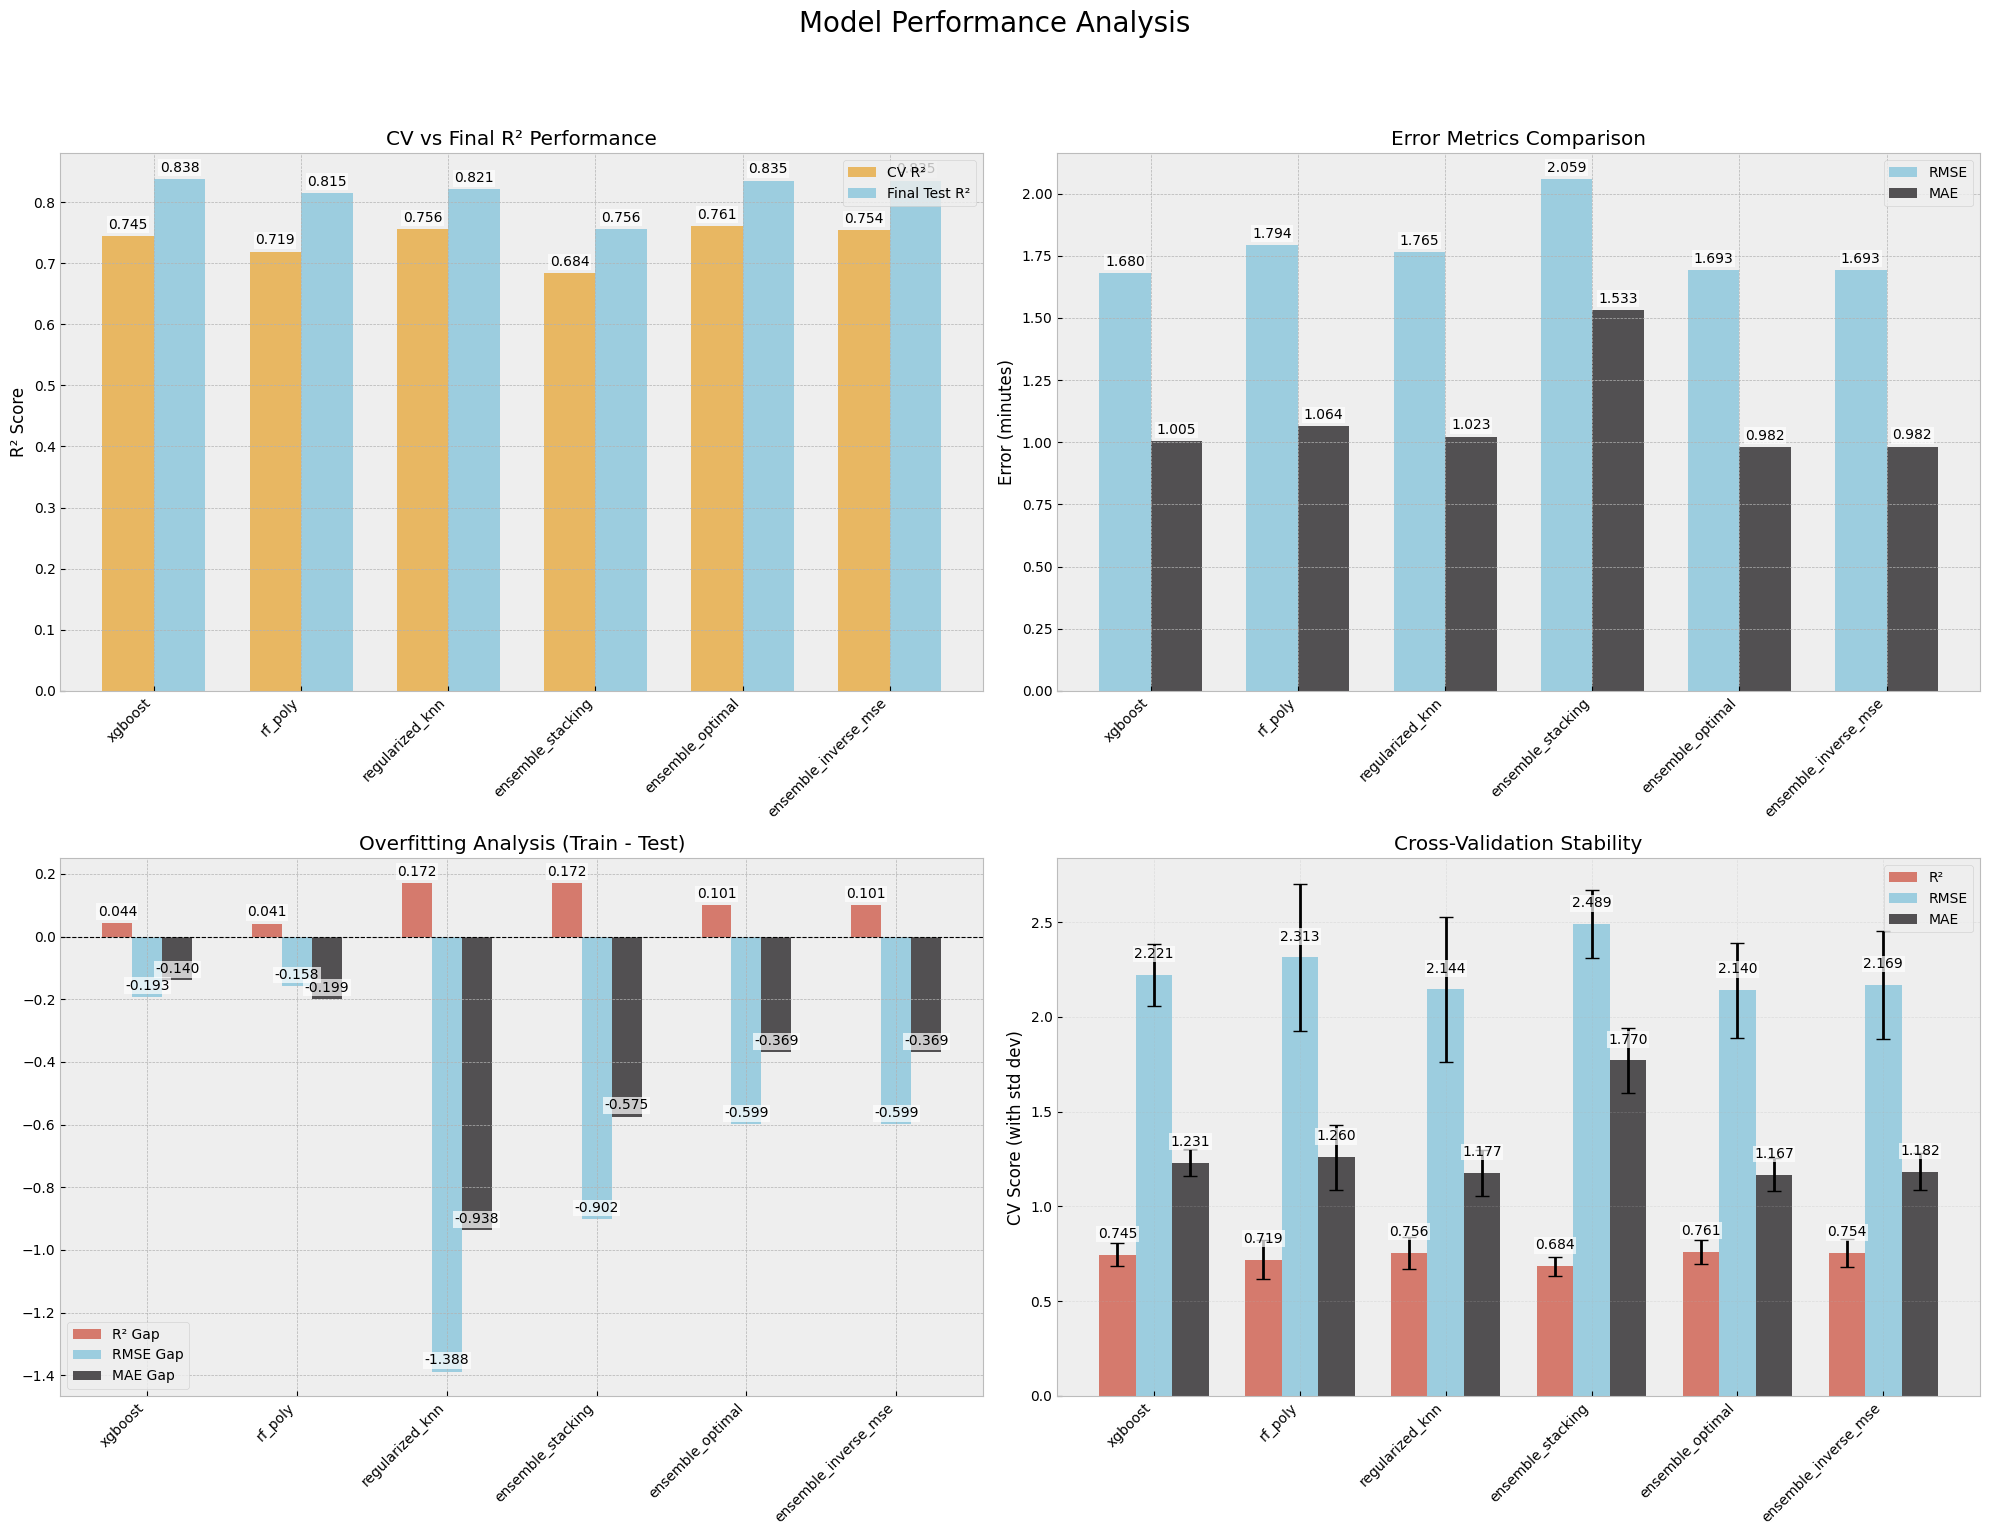

In [319]:
create_comprehensive_plot(model_results)

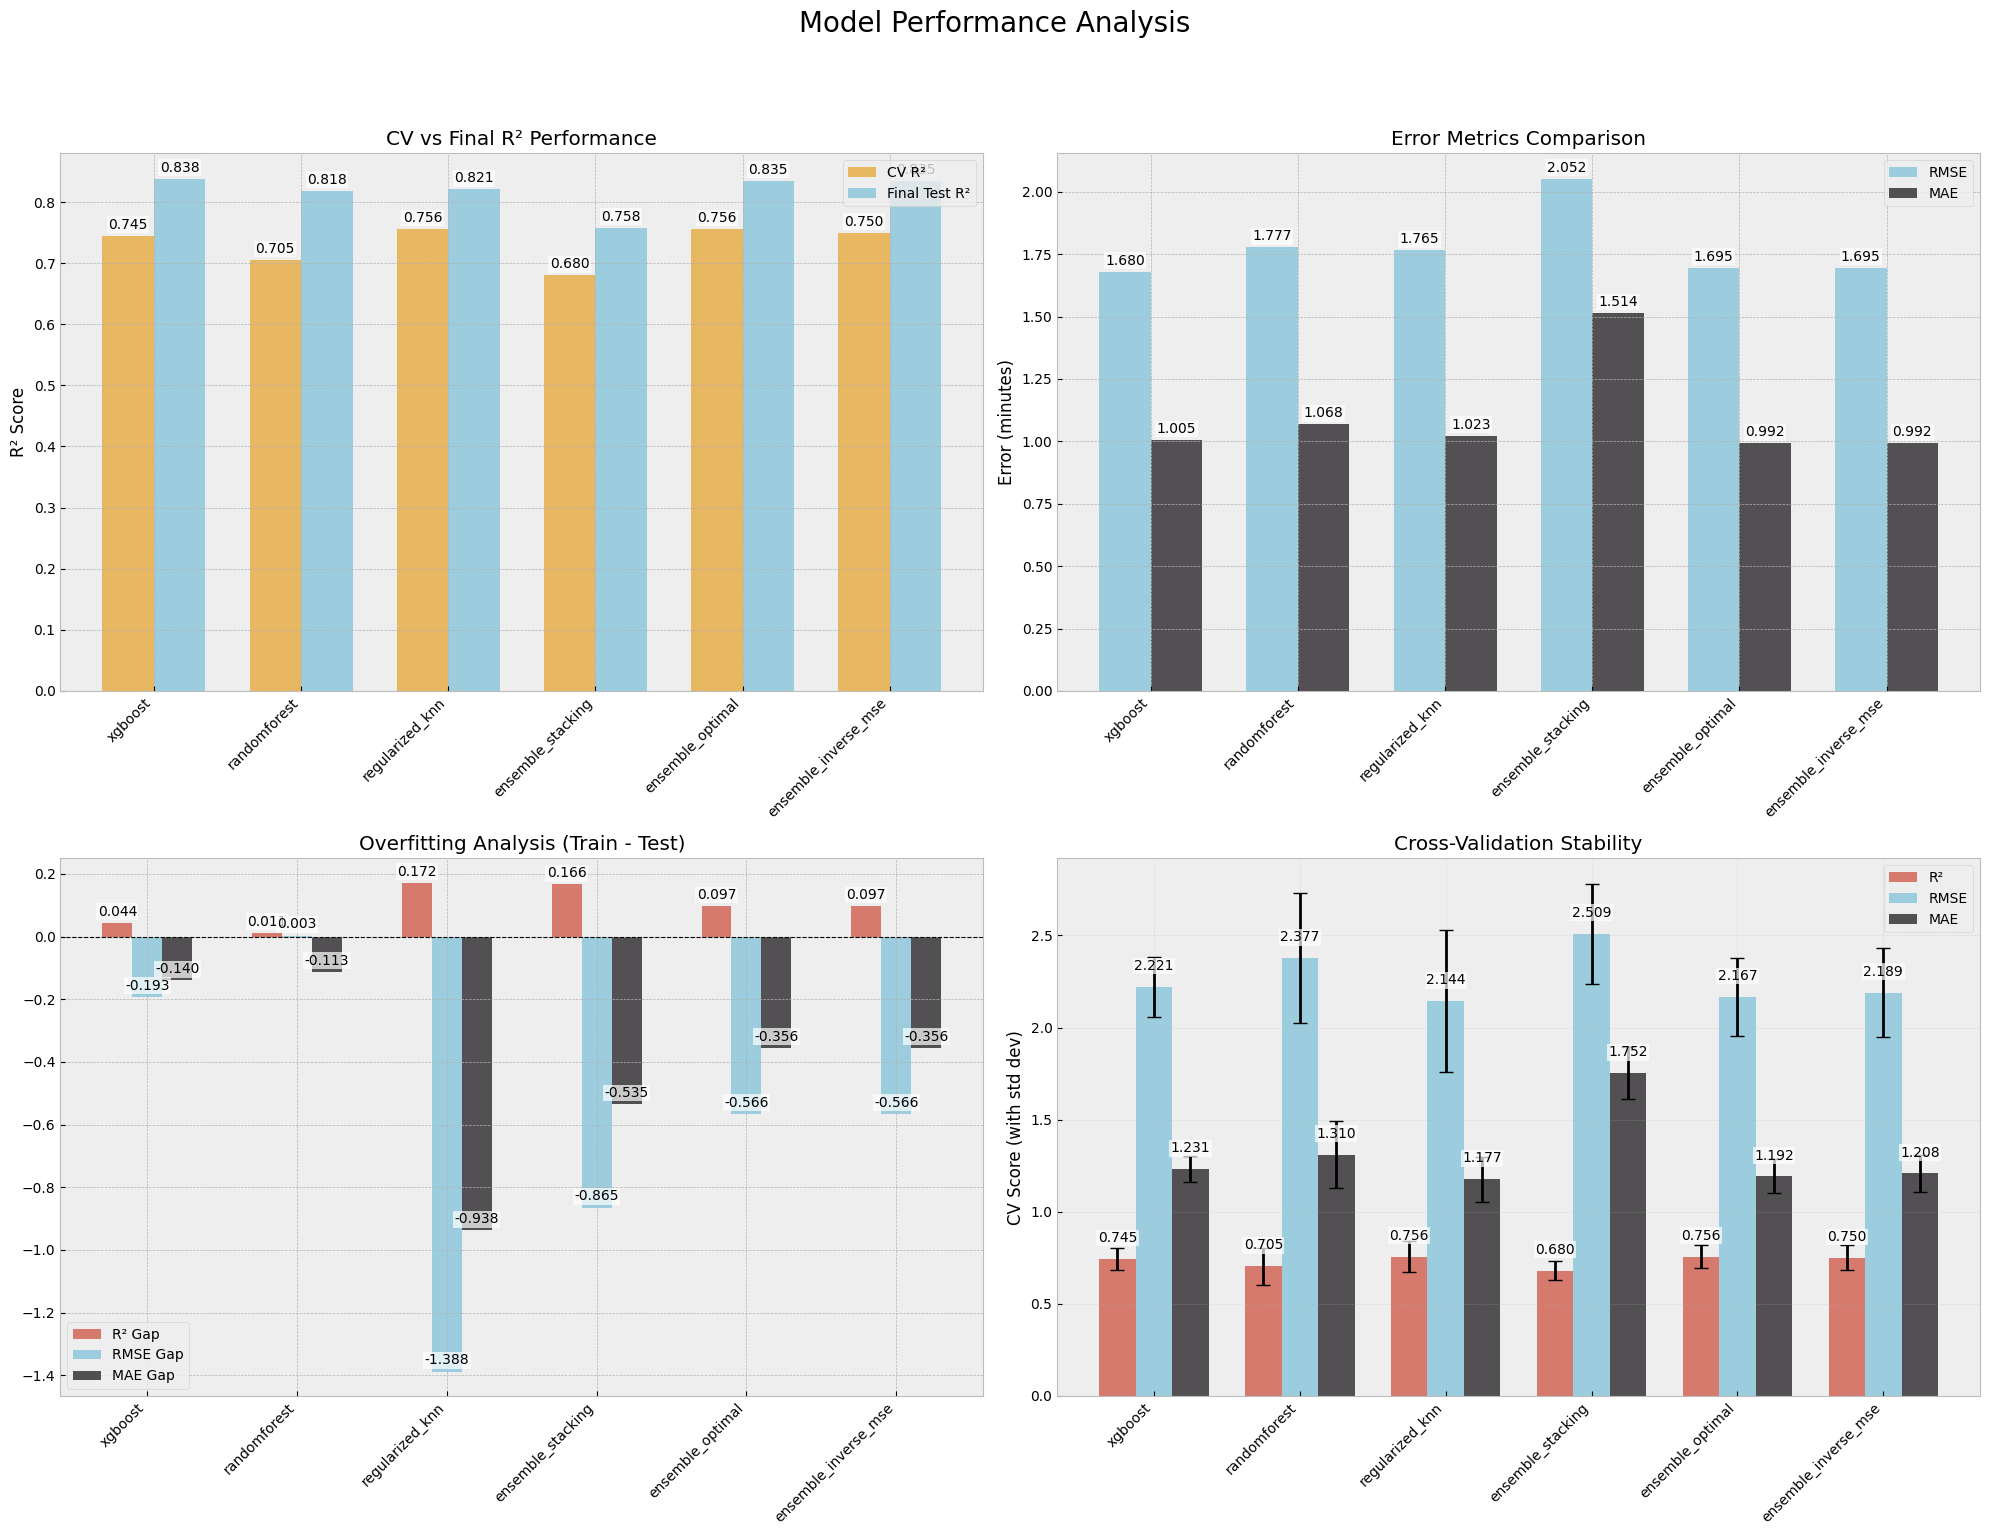

In [303]:
create_comprehensive_plot(model_results)

In [302]:
model_results

{'xgboost': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7776604740668679, device='cuda',
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0.9530478060208746,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.012326343232720999,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1600, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
  'cv_performance': {'r2_mean': 0.7446520763347731,
   'r2_std': 0.05980145788911447,
   'rmse_mean': 2.2207113047914224,
   'rmse_std': 0.162463889192908

In [ ]:
# Apply cube transformation to distance feature
X_train['distance'] = np.power(X_train['distance'], 3)
X_test['distance'] = np.power(X_test['distance'], 3)

# Create polynomial features for selected numerical columns
from sklearn.preprocessing import PolynomialFeatures

# Select numerical features for polynomial transformation
poly_features = ['temperature', 'wind_speed', 'cloud_cover', 'temp_range']

# Initialize polynomial transformer
poly = PolynomialFeatures(degree=2, include_bias=False)

# Create polynomial features for training data
poly_train = poly.fit_transform(X_train[poly_features])
poly_feature_names = [f"{col}_poly{i}" for i, col in enumerate(poly.get_feature_names(poly_features)[len(poly_features):])]
poly_train_df = pd.DataFrame(poly_train[:, len(poly_features):], columns=poly_feature_names)
X_train = pd.concat([X_train, poly_train_df], axis=1)

# Create polynomial features for test data
poly_test = poly.transform(X_test[poly_features])
poly_test_df = pd.DataFrame(poly_test[:, len(poly_features):], columns=poly_feature_names)
X_test = pd.concat([X_test, poly_test_df], axis=1)

# Train and evaluate models with polynomial features
model_results = train_and_evaluate_models(
    X_train[default_features + poly_feature_names].values,
    X_test[default_features + poly_feature_names].values,
    y_train,
    y_test,
    cv=5
)


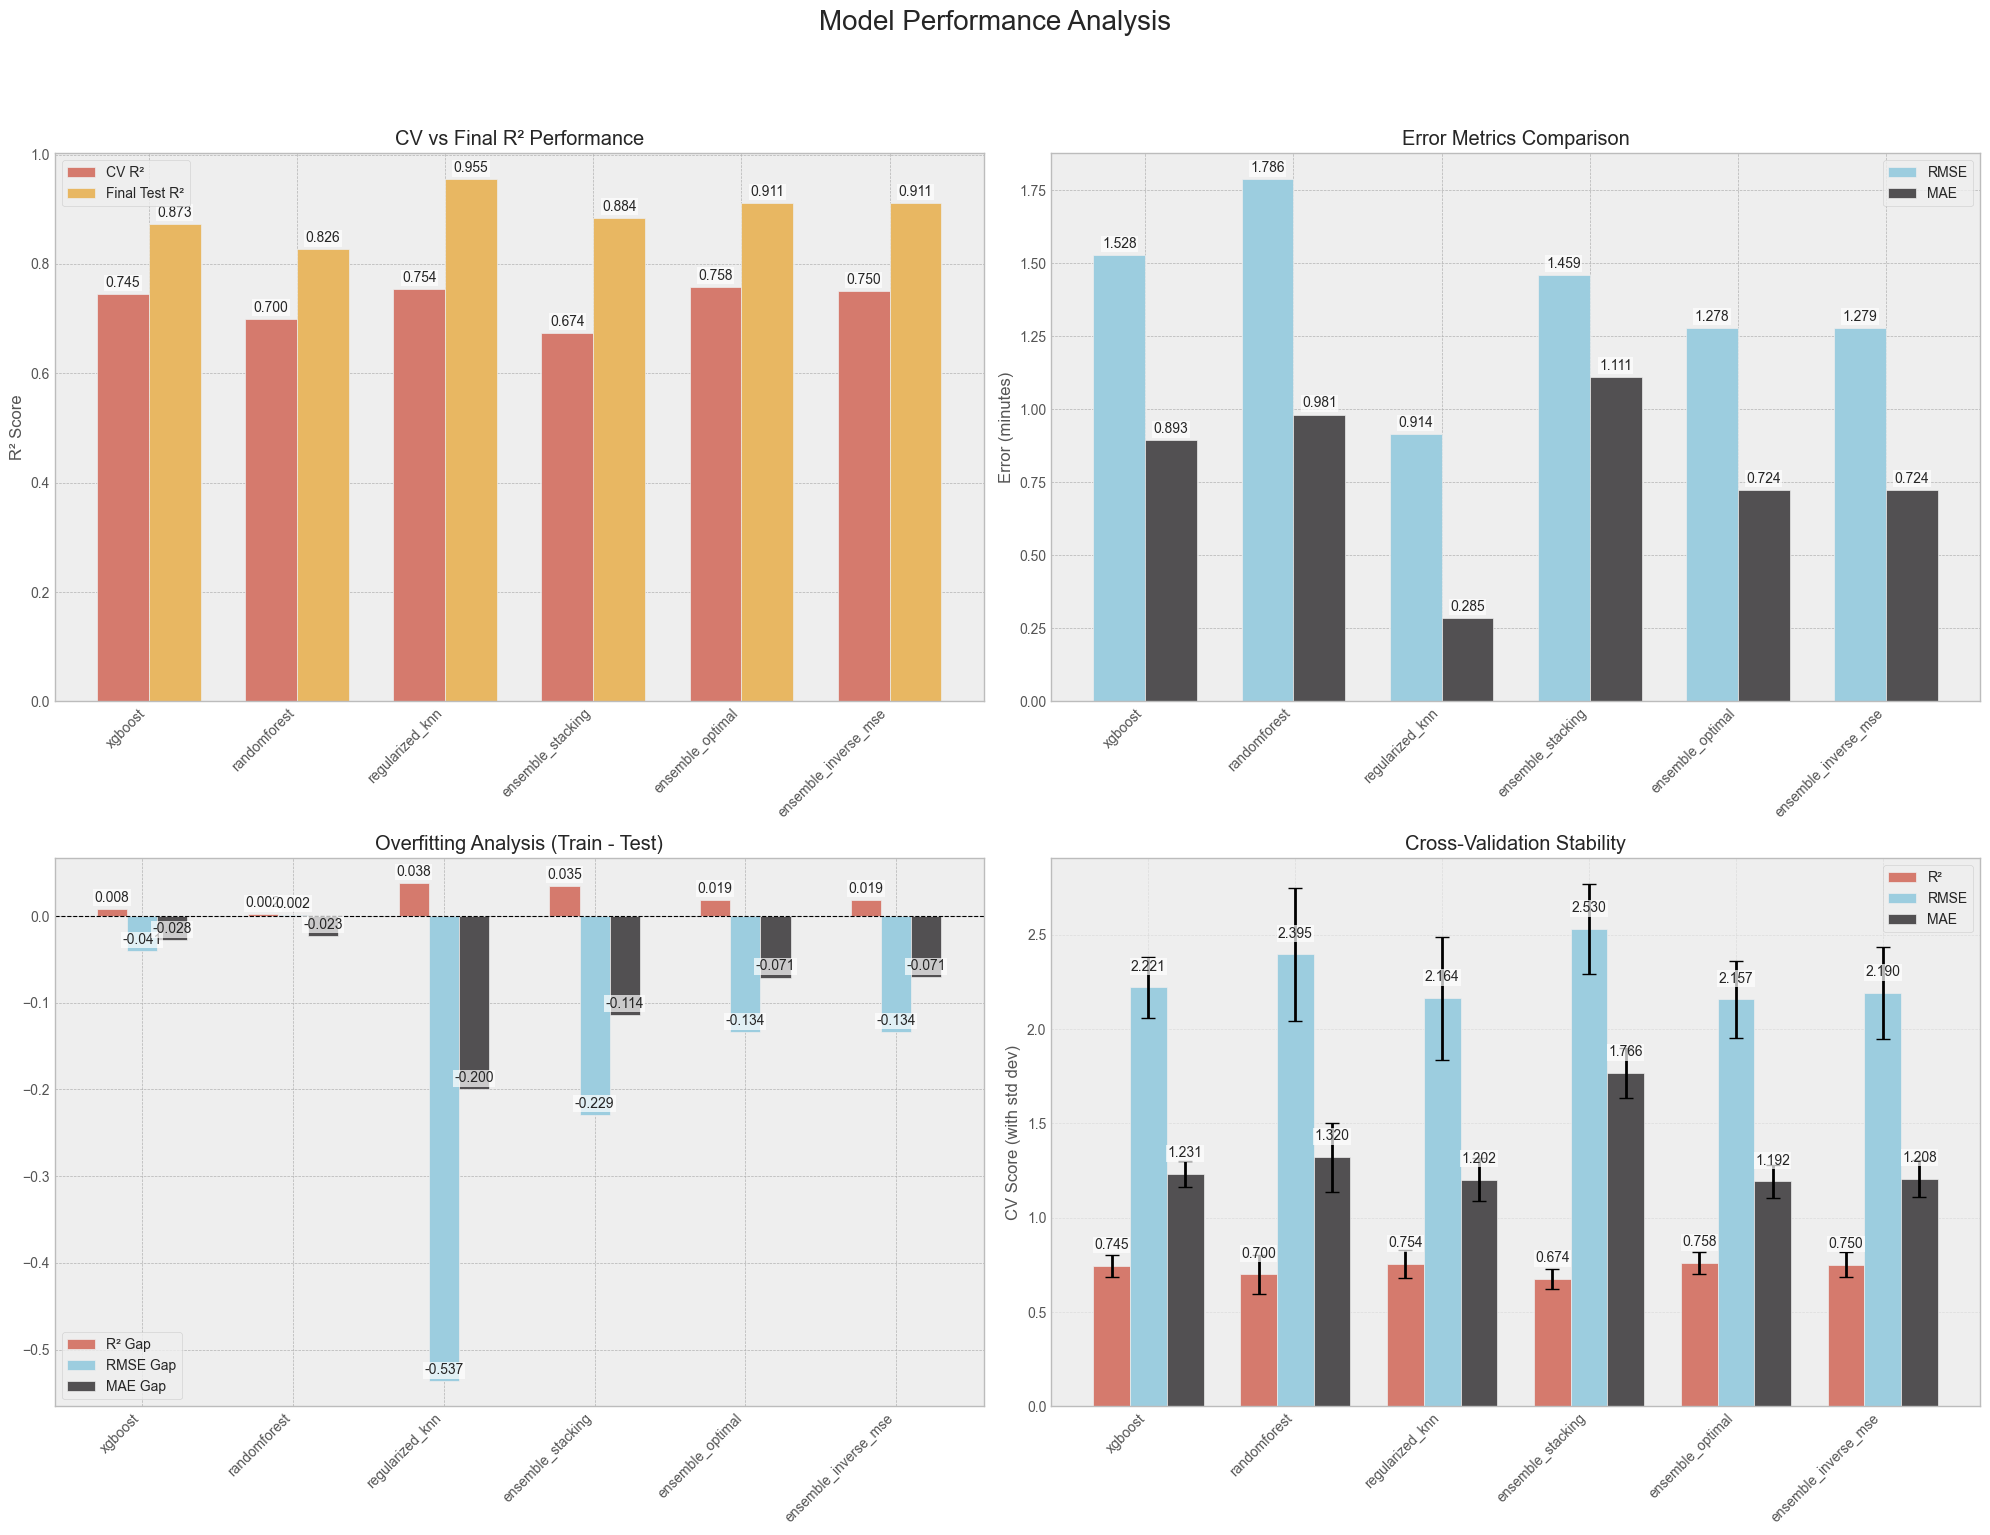

In [271]:
create_comprehensive_plot(model_results)

# Feature Specialized Ensemble

In [310]:
selected_features

['distance',
 'minutes_sin',
 'minutes_cos',
 'month_num_sin',
 'cloud_cover',
 'month_num_cos',
 'temp_range',
 'temperature',
 'wind_speed',
 'day_of_week_cos',
 'day_of_week_sin',
 'duration']

In [334]:
class FeatureSpecializedEnsemble(BaseEstimator, RegressorMixin):
    """
    Specialized ensemble using pre-tuned models for spatial and cyclic temporal features.
    Assumes input data is already scaled.
    """
    
    def __init__(
        self,
        random_state: int = 42
    ):
        # Initialize models with pre-tuned parameters
        self.distance_model = CatBoostRegressor(**catboost)
        self.temporal_model = XGBRegressor(
            **xgb_best_params,
            tree_method='hist',
            random_state=random_state
        )
        self.seasonal_model = RandomForestRegressor(
            **rf_best_params,
            random_state=random_state
        )
        
        # Meta-learner using XGBoost
        self.meta_learner = XGBRegressor(
            **xgb_best_params,
            tree_method='hist',
            random_state=random_state
        )
        
        # Feature groups
        self.feature_groups = {
            'spatial': ['distance'],
            'temporal': ['minutes_sin', 'minutes_cos', 'day_of_week_cos', 'day_of_week_sin'],
            'seasonal': ['month_num_sin', 'month_num_cos']
        }
    
    def _validate_features(self, X: pd.DataFrame) -> None:
        """Validate that all required features are present"""
        required_features = sum(self.feature_groups.values(), [])
        missing_features = set(required_features) - set(X.columns)
        if missing_features:
            raise ValueError(f"Missing features: {missing_features}")
    
    def _prepare_features(self, X: pd.DataFrame) -> Dict[str, np.ndarray]:
        """Prepare feature groups for specialized models"""
        return {
            'spatial': X[self.feature_groups['spatial']].values,
            'temporal': X[self.feature_groups['temporal']].values,
            'seasonal': X[self.feature_groups['seasonal']].values
        }
    
    def fit(self, X: pd.DataFrame, y: np.ndarray) -> 'FeatureSpecializedEnsemble':
        """
        Fit all specialized models and meta-learner
        
        Parameters:
        -----------
        X : pd.DataFrame
            Training features (pre-scaled)
        y : np.ndarray
            Target values
        """
        # Validate features
        self._validate_features(X)
        
        # Prepare features
        features = self._prepare_features(X)
        
        # Fit specialized models
        print("Fitting distance model...")
        self.distance_model.fit(features['spatial'], y)
        
        print("Fitting temporal model...")
        self.temporal_model.fit(features['temporal'], y)
        
        print("Fitting seasonal model...")
        self.seasonal_model.fit(features['seasonal'], y)
        
        # Generate meta-features
        meta_features = self._generate_meta_features(features)
        
        # Fit meta-learner
        print("Fitting meta-learner...")
        self.meta_learner.fit(meta_features, y)
        
        return self
    
    def _generate_meta_features(self, features: Dict[str, np.ndarray]) -> np.ndarray:
        """Generate predictions from specialized models for meta-learning"""
        # Get predictions from each model
        distance_pred = self.distance_model.predict(features['spatial'])
        temporal_pred = self.temporal_model.predict(features['temporal'])
        seasonal_pred = self.seasonal_model.predict(features['seasonal'])
        
        # Combine predictions with original features
        meta_features = np.column_stack([
            distance_pred,
            temporal_pred,
            seasonal_pred,
            features['temporal'],  # Include temporal patterns
            features['seasonal']   # Include seasonal patterns
        ])
        
        return meta_features
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Generate predictions using the ensemble
        
        Parameters:
        -----------
        X : pd.DataFrame
            Features for prediction (pre-scaled)
        
        Returns:
        --------
        np.ndarray
            Predicted values
        """
        # Validate features
        self._validate_features(X)
        
        # Prepare features
        features = self._prepare_features(X)
        
        # Generate meta-features
        meta_features = self._generate_meta_features(features)
        
        # Make final prediction
        predictions = self.meta_learner.predict(meta_features)
        
        return predictions
    
    def get_feature_importance(self) -> Dict[str, float]:
        """Get feature importance from tree-based models"""
        importance = {}
        
        # Get temporal feature importance
        if hasattr(self.temporal_model, 'feature_importances_'):
            for feat, imp in zip(self.feature_groups['temporal'], 
                               self.temporal_model.feature_importances_):
                importance[f'temporal_{feat}'] = imp
        
        # Get seasonal feature importance
        if hasattr(self.seasonal_model, 'feature_importances_'):
            for feat, imp in zip(self.feature_groups['seasonal'],
                               self.seasonal_model.feature_importances_):
                importance[f'seasonal_{feat}'] = imp
        
        return importance

In [335]:
# Train the ensemble
ensemble = FeatureSpecializedEnsemble(random_state=42)
ensemble.fit(X_train[default_features], y_train)

# Make predictions
y_pred_train = ensemble.predict(X_train[default_features])
y_pred_test = ensemble.predict(X_test[default_features])

# Evaluate
metrics = {
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'train_mae': mean_absolute_error(y_train, y_pred_train),
    'test_mae': mean_absolute_error(y_test, y_pred_test)
}

# Print results
print("\nEnsemble Performance:")
print("-" * 50)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Get feature importance
importance = ensemble.get_feature_importance()
print("\nFeature Importance:")
print("-" * 50)
for feature, imp in importance.items():
    print(f"{feature}: {imp:.4f}")

Fitting distance model...
Fitting temporal model...
Fitting seasonal model...
Fitting meta-learner...

Ensemble Performance:
--------------------------------------------------
train_r2: 0.9127
test_r2: 0.8031
train_rmse: 1.2754
test_rmse: 1.8505
train_mae: 0.7629
test_mae: 1.1113

Feature Importance:
--------------------------------------------------
temporal_minutes_sin: 0.4798
temporal_minutes_cos: 0.3904
temporal_day_of_week_cos: 0.0569
temporal_day_of_week_sin: 0.0730
seasonal_month_num_sin: 0.4597
seasonal_month_num_cos: 0.5403


Ensemble Performance:
--------------------------------------------------
train_r2: 0.9924
test_r2: 0.7719
train_rmse: 0.3775
test_rmse: 1.9917
train_mae: 0.0849
test_mae: 1.1164

Feature Importance:
--------------------------------------------------
temporal_minutes_sin: 0.4798
temporal_minutes_cos: 0.3904
temporal_day_of_week_cos: 0.0569
temporal_day_of_week_sin: 0.0730
seasonal_month_num_sin: 0.4597
seasonal_month_num_cos: 0.5403

In [339]:
class FeatureSpecializedEnsemble:
    def analyze_feature_contributions(self):
        """Analyze how each feature group contributes to predictions"""
        contributions = {}
        
        # Get individual model predictions
        spatial_pred = self.distance_model.predict(self.last_features['spatial'])
        temporal_pred = self.temporal_model.predict(self.last_features['temporal'])
        seasonal_pred = self.seasonal_model.predict(self.last_features['seasonal'])
        
        # Calculate correlation with final predictions
        final_pred = self.predict(self.last_features_combined)
        
        contributions['spatial'] = np.corrcoef(spatial_pred, final_pred)[0,1]
        contributions['temporal'] = np.corrcoef(temporal_pred, final_pred)[0,1]
        contributions['seasonal'] = np.corrcoef(seasonal_pred, final_pred)[0,1]
        
        return contributions

    def plot_feature_importance(self):
        """Plot feature importance for each specialized model"""
        plt.figure(figsize=(12, 6))
        
        # Plot temporal importance
        plt.subplot(131)
        temporal_imp = pd.Series(
            self.temporal_model.feature_importances_,
            index=self.feature_groups['temporal']
        ).sort_values()
        temporal_imp.plot(kind='barh')
        plt.title('Temporal Features')
        
        # Plot seasonal importance
        plt.subplot(132)
        seasonal_imp = pd.Series(
            self.seasonal_model.feature_importances_,
            index=self.feature_groups['seasonal']
        ).sort_values()
        seasonal_imp.plot(kind='barh')
        plt.title('Seasonal Features')
        
        # Plot meta-learner importance
        plt.subplot(133)
        meta_features = ['spatial_pred', 'temporal_pred', 'seasonal_pred']
        meta_imp = pd.Series(
            self.meta_learner.feature_importances_,
            index=meta_features
        ).sort_values()
        meta_imp.plot(kind='barh')
        plt.title('Meta-learner Features')
        
        plt.tight_layout()
        plt.show()

Fitting distance model...
Fitting temporal model...
Fitting seasonal model...
Fitting meta-learner...

Feature Group Contributions (correlation with final predictions):
--------------------------------------------------
spatial: 0.8908
temporal: 0.8081
seasonal: -0.0807


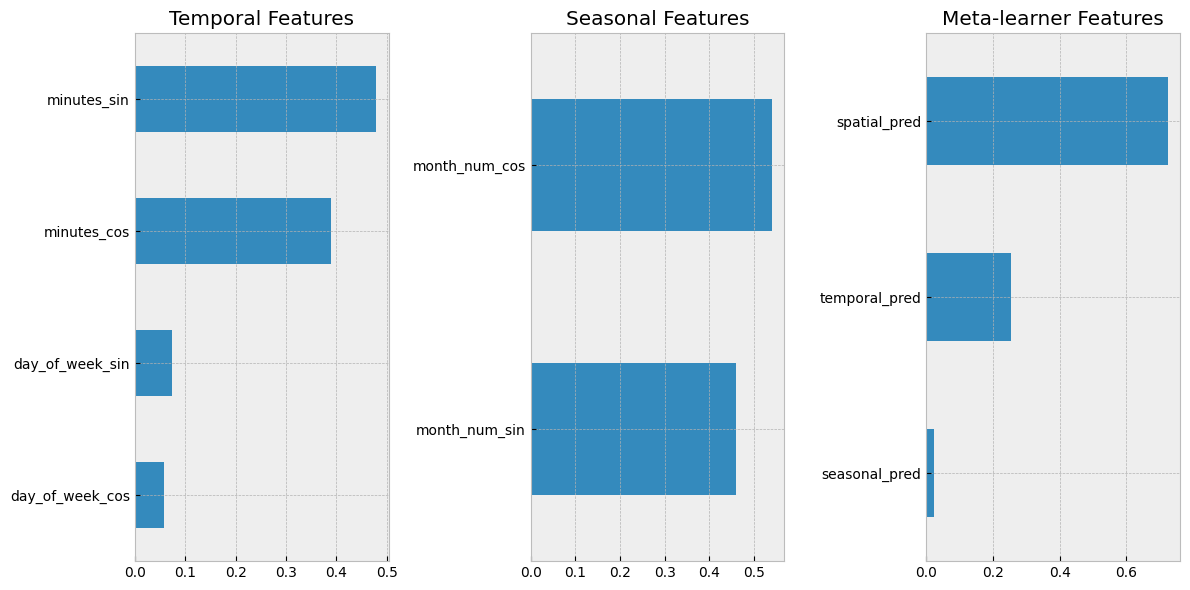

In [346]:
class FeatureSpecializedEnsemble:
    """
    Specialized ensemble using pre-tuned models for spatial and cyclic temporal features.
    """
    
    def __init__(self, random_state: int = 42):
        # Initialize models with pre-tuned parameters
        self.distance_model = RegularizedKNN(**knn_best_params)
        self.temporal_model = XGBRegressor(
            **xgb_best_params,
            tree_method='hist',
            random_state=random_state
        )
        self.seasonal_model = RandomForestRegressor(
            **rf_best_params,
            random_state=random_state
        )
        
        # Meta-learner using XGBoost
        self.meta_learner = XGBRegressor(
            **xgb_best_params,
            tree_method='hist',
            random_state=random_state
        )
        
        # Feature groups
        self.feature_groups = {
            'spatial': ['distance'],
            'temporal': ['minutes_sin', 'minutes_cos', 'day_of_week_cos', 'day_of_week_sin'],
            'seasonal': ['month_num_sin', 'month_num_cos']
        }
    
    def fit(self, X: pd.DataFrame, y: np.ndarray) -> 'FeatureSpecializedEnsemble':
        """
        Fit all specialized models and meta-learner
        """
        # Validate features
        self._validate_features(X)
        
        # Prepare features
        features = self._prepare_features(X)
        
        # Fit specialized models
        print("Fitting distance model...")
        self.distance_model.fit(features['spatial'], y)
        
        print("Fitting temporal model...")
        self.temporal_model.fit(features['temporal'], y)
        
        print("Fitting seasonal model...")
        self.seasonal_model.fit(features['seasonal'], y)
        
        # Generate meta-features
        meta_features = self._generate_meta_features(features)
        
        # Fit meta-learner
        print("Fitting meta-learner...")
        self.meta_learner.fit(meta_features, y)
        
        return self
    
    def _validate_features(self, X: pd.DataFrame) -> None:
        """Validate that all required features are present"""
        required_features = sum(self.feature_groups.values(), [])
        missing_features = set(required_features) - set(X.columns)
        if missing_features:
            raise ValueError(f"Missing features: {missing_features}")
    
    def _prepare_features(self, X: pd.DataFrame) -> Dict[str, np.ndarray]:
        """Prepare feature groups for specialized models"""
        return {
            'spatial': X[self.feature_groups['spatial']].values,
            'temporal': X[self.feature_groups['temporal']].values,
            'seasonal': X[self.feature_groups['seasonal']].values
        }
    
    def _generate_meta_features(self, features: Dict[str, np.ndarray]) -> np.ndarray:
        """Generate predictions from specialized models for meta-learning"""
        # Get predictions from each model
        spatial_pred = self.distance_model.predict(features['spatial'])
        temporal_pred = self.temporal_model.predict(features['temporal'])
        seasonal_pred = self.seasonal_model.predict(features['seasonal'])
        
        # Combine predictions
        meta_features = np.column_stack([
            spatial_pred,
            temporal_pred,
            seasonal_pred
        ])
        
        return meta_features
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Generate predictions using the ensemble"""
        # Store last features for analysis
        self.last_features = {
            'spatial': X[self.feature_groups['spatial']].values,
            'temporal': X[self.feature_groups['temporal']].values,
            'seasonal': X[self.feature_groups['seasonal']].values
        }
        self.last_features_combined = X
        
        # Get predictions from specialized models
        spatial_pred = self.distance_model.predict(self.last_features['spatial'])
        temporal_pred = self.temporal_model.predict(self.last_features['temporal'])
        seasonal_pred = self.seasonal_model.predict(self.last_features['seasonal'])
        
        # Generate meta-features
        meta_features = np.column_stack([
            spatial_pred,
            temporal_pred,
            seasonal_pred
        ])
        
        # Make final prediction
        return self.meta_learner.predict(meta_features)
    
    def analyze_feature_contributions(self):
        """Analyze how each feature group contributes to predictions"""
        contributions = {}
        
        # Get individual model predictions
        spatial_pred = self.distance_model.predict(self.last_features['spatial'])
        temporal_pred = self.temporal_model.predict(self.last_features['temporal'])
        seasonal_pred = self.seasonal_model.predict(self.last_features['seasonal'])
        
        # Calculate correlation with final predictions
        final_pred = self.predict(self.last_features_combined)
        
        contributions['spatial'] = np.corrcoef(spatial_pred, final_pred)[0,1]
        contributions['temporal'] = np.corrcoef(temporal_pred, final_pred)[0,1]
        contributions['seasonal'] = np.corrcoef(seasonal_pred, final_pred)[0,1]
        
        return contributions
    
    def plot_feature_importance(self):
        """Plot feature importance for each specialized model"""
        plt.figure(figsize=(12, 6))
        
        # Plot temporal importance
        plt.subplot(131)
        temporal_imp = pd.Series(
            self.temporal_model.feature_importances_,
            index=self.feature_groups['temporal']
        ).sort_values()
        temporal_imp.plot(kind='barh')
        plt.title('Temporal Features')
        
        # Plot seasonal importance
        plt.subplot(132)
        seasonal_imp = pd.Series(
            self.seasonal_model.feature_importances_,
            index=self.feature_groups['seasonal']
        ).sort_values()
        seasonal_imp.plot(kind='barh')
        plt.title('Seasonal Features')
        
        # Plot meta-learner importance
        plt.subplot(133)
        meta_features = ['spatial_pred', 'temporal_pred', 'seasonal_pred']
        meta_imp = pd.Series(
            self.meta_learner.feature_importances_,
            index=meta_features
        ).sort_values()
        meta_imp.plot(kind='barh')
        plt.title('Meta-learner Features')
        
        plt.tight_layout()
        plt.show()

# Now try it:
ensemble = FeatureSpecializedEnsemble(random_state=42)
ensemble.fit(X_train[default_features], y_train)

# Make some predictions (this will store the features for analysis)
_ = ensemble.predict(X_test[default_features])

# Analyze feature contributions
contributions = ensemble.analyze_feature_contributions()
print("\nFeature Group Contributions (correlation with final predictions):")
print("-" * 50)
for group, corr in contributions.items():
    print(f"{group}: {corr:.4f}")

# Plot feature importance for all models
ensemble.plot_feature_importance()

Hybrid XGBoost-Kalman Performance:
--------------------------------------------------
train_r2: 0.9367
test_r2: 0.7606
train_rmse: 1.0865
test_rmse: 2.0406
train_mae: 0.6368
test_mae: 1.2311